In [2]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"

import tensorflow as tf
# tf.enable_eager_execution()
# tf.enable_v2_behavior()
# sess = tf.InteractiveSession()
# sess.as_default()

import util_funcs
from importlib import reload
import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import constants
import clinical_text_analysis as cta
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path
# import predictSeizureConvExp as psce
import keras_models.dataGen as dg
from addict import Dict
# reload(psce)
from keras.utils import multi_gpu_model
import keras.optimizers
import ensembleReader as er
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, log_loss
from functools import lru_cache

Using TensorFlow backend.


# edss analysis, pulling segments and seizure labels
how to generate the edss files, we have to run the generateCachedClean.py script.
Then run through below to generate proper indexDict files.

In [3]:
eds = er.EdfDatasetSegments(pre_cooldown=0, post_cooldown=0, sample_time=0, num_seconds=2, n_process=8)
train_label_files_segs = eds.get_train_split()

Starting 8 processes
retrieving: 0
Starting 8 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000
starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [4]:
train_label_files_segs[0]

('/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
 00:00:00    bckg
 00:00:02    bckg
 00:00:04    bckg
 00:00:06    bckg
 00:00:08    bckg
 00:00:10    bckg
 00:00:12    bckg
 00:00:14    bckg
 00:00:16    bckg
 00:00:18    bckg
 00:00:20    bckg
 00:00:22    bckg
 00:00:24    bckg
 00:00:26    bckg
 00:00:28    bckg
 00:00:30    bckg
 00:00:32    bckg
 00:00:34    bckg
 00:00:36    bckg
 00:00:38    bckg
 00:00:40    bckg
 00:00:42    bckg
 00:00:44    bckg
 00:00:46    bckg
 00:00:48    bckg
 00:00:50    bckg
 00:00:52    bckg
 00:00:54    bckg
 00:00:56    bckg
 00:00:58    bckg
             ... 
 00:20:42    bckg
 00:20:44    bckg
 00:20:46    bckg
 00:20:48    bckg
 00:20:50    bckg
 00:20:52    bckg
 00:20:54    bckg
 00:20:56    bckg
 00:20:58    bckg
 00:21:00    bckg
 00:21:02    bckg
 00:21:04    bckg
 00:21:06    bckg
 00:21:08    bckg
 00:21:10    bckg
 00:21:12    bckg
 00:21:14    bckg
 00:21:16    bckg
 00:21:18    bckg
 00:2

In [2]:
import pickle as pkl
@lru_cache(40)
def get_pickle_data(edf, start_seconds, split="train"):
    #to keep all pickles manageable, we split for every 500 into temporary files
    pickle_no = int(np.floor(start_seconds/1000)) + 1
    ref, patient, session, token = read.parse_edf_token_path_structure(edf)
    basePath = f"/n/scratch2/ms994/medium_size/{split}/{patient}/{session}/{token}/intermediate_{pickle_no}"
    return pkl.load(open(basePath, "rb"))
def get_data_from_start(edf, start_seconds, split="train"):
    data = get_pickle_data(edf, start_seconds, split)
    return data[start_seconds/2].data[:][0]

NameError: name 'lru_cache' is not defined

In [21]:
data = get_data_from_start(train_label_files_segs[0][0], 1000)

In [5]:
data[0].shape

(1000,)

In [35]:
train_label_files_segs[0][1].index.max()/pd.Timedelta(seconds=1)/2

650.0

In [22]:
train_split_preprocessed = "/n/scratch2/ms994/medium_size/train"
test_split_preprocessed = "/n/scratch2/ms994/medium_size/test"
valid_split_preprocessed = "/n/scratch2/ms994/medium_size/valid"

class FileDataReader(util_funcs.MultiProcessingDataset):
    def __init__(self, cachedIndex=None, split="train", directory=train_split_preprocessed, train_seg_files=None, overlap=2, unit_size=4, max_size=20):
        self.directory = directory
        self.overlap = overlap
        self.unit_size = unit_size
        self.train_seg_files = train_seg_files
        self.max_size = max_size
        self.split = split
        self.use_mp  = False
        if cachedIndex is None:
            self.indexDict = Dict() #used to grab and set the indexes used to grab data from the fs
            currentInd = 0
            for i in range(len(train_seg_files)):
                max_segment_index = train_label_files_segs[i][1].index.max()/pd.Timedelta(seconds=self.overlap)
                for j in range(int(np.floor(max_segment_index/self.max_size))):
                    startTime = j * self.max_size
                    self.indexDict[currentInd].start = startTime
                    self.indexDict[currentInd].edf_file = train_label_files_segs[i][0]

                    labelSlice = train_label_files_segs[i][1][ \
                                                              pd.Timedelta(seconds=startTime): \
                                                              pd.Timedelta(seconds=startTime)+pd.Timedelta(seconds=self.max_size) \
                                                             ]
                    self.indexDict[currentInd].label = not (labelSlice == "bckg").all()
                    self.indexDict[currentInd].time_seizure_label =  (labelSlice != "bckg")
                    self.indexDict[currentInd].time_seizure_subtypes = labelSlice.apply(lambda x: constants.SEIZURE_SUBTYPES.index(x))
                    currentInd+=1
        else:
            self.indexDict = cachedIndex
    def __len__(self):
        return len(self.indexDict)
    def  __getitem__(self, i):
        if self.should_use_mp(i):
            return self.getItemSlice(i)
        label = self.indexDict[i].time_seizure_label
        data = np.ndarray((11,21,1000))
        for j in range(11):
            data[j] = get_data_from_start(self.indexDict[i].edf_file, self.indexDict[i].start + j * 2, split=self.split)
        return data, label.values

In [23]:
class RULDataReader(util_funcs.MultiProcessingDataset):
    def __init__(self, cachedIndex=None, split="train"):
        self.indexDict = cachedIndex
        self.rebalance()
        self.use_mp = False
        self.split = split
    def rebalance(self):
        self.newIndexDict = Dict()
        oldIndicesByLabels = Dict()
        allLabels = Dict()
        for i in range(len(self.indexDict)):
            label = self.indexDict[i].label #use the first label
            if label not in oldIndicesByLabels.keys():
                oldIndicesByLabels[label] = []
                allLabels[label] = 0
            oldIndicesByLabels[label].append(i)
            allLabels[label] += 1

        min_label_count = min([allLabels[label] for label in allLabels.keys()])
        self.list_IDs = []
        for label in oldIndicesByLabels.keys():
            oldIndicesByLabels[label] = np.random.choice(oldIndicesByLabels[label], size=min_label_count, replace=False)
            for oldInd in oldIndicesByLabels[label]:
                self.list_IDs.append(oldInd)
        np.random.shuffle(self.list_IDs)
    def __len__(self):
        return len(self.list_IDs)
    def  __getitem__(self, i):
        if self.should_use_mp(i):
            return self.getItemSlice(i)
        new_i = self.list_IDs[i]
        label = self.indexDict[new_i].time_seizure_label
        data = np.ndarray((11,21,1000))
        for j in range(11):
            data[j] = get_data_from_start(self.indexDict[new_i].edf_file, self.indexDict[new_i].start + j * 2, split=self.split)
        return data, label.values

In [35]:
sessions = ["/n/scratch2/ms994/medium_size/test/" + directory for directory in  os.listdir("/n/scratch2/ms994/medium_size/test/")]

In [49]:
reload(util_funcs)

<module 'util_funcs' from '/home/ms994/dbmi_eeg_clustering/util_funcs.py'>

In [9]:
indexDict = pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb"))

In [87]:
read.parse_edf_token_path_structure(trainValidSess[0][0])

('01_tcp_ar', '00013182', 's001_2015_10_07', '00013182_s001_t000.edf')

In [88]:
read.parse_edf_token_path_structure(slicedIndices[0])

('medium_size', '00008453', 's007_2012_03_06', '00008453_s007_t011.edf')

In [4]:
trainValidPairs = eds.get_train_valid_split()

In [5]:
slicedIndices

'/n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf'

## apparently i forgot that train and valid sets are randomly made each time, edss doesn't match up exactly with first time script ran

In [5]:
slicedIndices = util_funcs.get_abs_files(util_funcs.get_abs_files(util_funcs.get_abs_files("/n/scratch2/ms994/medium_size/train/")), False)

In [9]:
newSliced = []
for slicedIndex in slicedIndices:
    split, patient, session, token = read.parse_edf_token_path_structure(slicedIndex)
    for pair in trainValidPairs:
        split, patient2, session2, token2 = read.parse_edf_token_path_structure(pair[0])
        if patient == patient2 and token == token2:
            newSliced.append(pair)

In [10]:
import preprocessingV2.preprocessingV2 as ppv2
reload(ppv2)
dr = ppv2.FileDataReader(split="train", directory="/n/scratch2/ms994/train", train_label_files_segs=newSliced)

In [11]:
pkl.dump(dr.indexDict, open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "wb"))

In [12]:
trainDatum = dr[0]

In [78]:
trainDatum[0].shape

(9, 21, 1000)

In [33]:
%%bash
ls /n/scratch2/ms994/medium_size/train

00000254
00000272
00000458
00000492
00000529
00000569
00000577
00000598
00000630
00000659
00000850
00000883
00000924
00001030
00001034
00001204
00001543
00001820
00001981
00002322
00002348
00002384
00002521
00002707
00002868
00002991
00003005
00003101
00003437
00004456
00005169
00005427
00005469
00005740
00005765
00005936
00006175
00006230
00006236
00006444
00006452
00006455
00006514
00006515
00006535
00006546
00006562
00006563
00006607
00006699
00006774
00006811
00006864
00006904
00007032
00007094
00007130
00007216
00007279
00007296
00007374
00007431
00007446
00007458
00007504
00007555
00007584
00007617
00007656
00007772
00007773
00007839
00007929
00007936
00007937
00008053
00008056
00008092
00008100
00008143
00008164
00008204
00008292
00008295
00008345
00008444
00008461
00008471
00008476
00008480
00008481
00008487
00008492
00008527
00008561
00008574
00008579
00008608
00008615
00008628
00008643
00008660
00008730
00008738
00008760
00008829
00008884
00008886
00008941
00008953
00008980
0

In [5]:
slicedIndices = util_funcs.get_abs_files(util_funcs.get_abs_files(util_funcs.get_abs_files("/n/scratch2/ms994/medium_size/valid/")), False)
newSliced = []
for slicedIndex in slicedIndices:
    split, patient, session, token = read.parse_edf_token_path_structure(slicedIndex)
    for pair in trainValidPairs:
        split, patient2, session2, token2 = read.parse_edf_token_path_structure(pair[0])
        if patient == patient2 and token == token2:
            newSliced.append(pair)

In [6]:
import preprocessingV2.preprocessingV2 as ppv2
reload(ppv2)
dr = ppv2.FileDataReader(split="valid", directory="/n/scratch2/ms994/valid", train_label_files_segs=newSliced)

In [12]:
%
ls /n/scratch2/ms994/valid

ls: cannot access /n/scratch2/ms994/valid: No such file or directory


CalledProcessError: Command 'b'ls /n/scratch2/ms994/valid\n'' returned non-zero exit status 2.

In [51]:
datum = dr[0]

In [81]:
datum[0].shape

(9, 21, 1000)

In [49]:
dr.max_size / dr.unit_size

5.0

In [7]:
pkl.dump(dr.indexDict, open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "wb"))

In [83]:
indexDict = pkl.load(open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "rb"))

In [84]:
len(indexDict.keys())

15594

In [19]:
import preprocessingV2.preprocessingV2 as ppv2
dr = ppv2.FileDataReader(split="test", directory="/n/scratch2/ms994/medium_size/test", train_label_files_segs=eds.get_test_split())

starting custom_annotater
Starting 20 processes
retrieving: 0


In [20]:
pkl.dump(dr.indexDict,  open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "wb"))

In [18]:
reload(ppv2)
edg = dg.EdfDataGenerator(dr, precache=False, batch_size=4)
edg[0][0].shape

FileNotFoundError: [Errno 2] No such file or directory: '/n/scratch2/ms994/medium_size/test/00009540/s002_2012_11_12/00009540_s002_t000.edf/intermediate_1'

In [ ]:
edg[0]

In [87]:
trainDatum[1].shape

(10,)

In [84]:
def getFnAnn(tknFn):
                labelFile = read.read_tse_file(tknFn + "/label.tse")
                ann = er.generate_label_rolling_window(labelFile, pre_cooldown=0, post_cooldown=0,sample_time=0, num_seconds=2)
                return tknFn, ann

In [ ]:
pkl.dump(dr.indexDict, open(dr.directory + "/20sindex.pkl", "wb"))

In [71]:
slicedIndices[0]

'/n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf'

In [72]:
%%bash 
ls /n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf

intermediate_1
label.tse
montage.lbl
notes.txt


In [76]:
labelFile = read.read_tse_file("/n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf/label.tse")

In [78]:
import ensembleReader as er
ann = er.generate_label_rolling_window(labelFile, pre_cooldown=0, post_cooldown=0,sample_time=0, num_seconds=2)

In [29]:
edg = dg.EdfDataGenerator(rdr, precache=False, batch_size=32)

In [52]:
trainValidSess = eds.get_train_valid_split()

In [62]:
trainValidSessFN = [pair[0] for pair in trainValidSess].index("/home/ms994/v1.5.0/edf/" + ind) for ind in slicedIndices]

In [70]:
slicedIndices[0][30:]

'test/00008453/s007_2012_03_06/00008453_s007_t011.edf'

In [63]:
trainValidSessFN[0]

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf'

In [63]:
pkl.dump(dataReader.indexDict, open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "wb"))

In [69]:
len(pkl.load( open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb")))

35390

In [64]:
validDataReader = FileDataReader(train_seg_files=eds.get_valid_split())

starting custom_annotater
Starting 20 processes
retrieving: 0


In [70]:
pkl.dump(validDataReader.indexDict, open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "wb"))

In [ ]:
pkl.dump(testDataReader.indexDict, open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "wb"))

In [ ]:
testDataReader = FileDataReader(cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb")), split="test")

## Go through and separate indexDict into seizure and nonseizure classes for the train set only based on 20s indexDict to make reads faster.

In [3]:
import pickle as pkl
trainIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb"))

In [23]:
trainIndexDict[31]

{'start': 620,
 'edf_file': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t005.edf',
 'label': True,
 'time_seizure_label': 00:10:20     True
 00:10:22     True
 00:10:24     True
 00:10:26    False
 00:10:28    False
 00:10:30     True
 00:10:32     True
 00:10:34     True
 00:10:36     True
 00:10:38     True
 Freq: 2S, dtype: bool,
 'time_seizure_subtypes': 00:10:20    1
 00:10:22    1
 00:10:24    1
 00:10:26    0
 00:10:28    0
 00:10:30    1
 00:10:32    1
 00:10:34    1
 00:10:36    1
 00:10:38    1
 Freq: 2S, dtype: int64}

In [11]:
from pyedflib import EdfReader

In [12]:
read = EdfReader('/home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t005.edf')

In [17]:
read.readSignal(0).shape, read.getSampleFrequency(0)

((176384,), 256)

In [18]:
176384/256

689.0

In [4]:
labels = [trainIndexDict[i].label for i in range(len(trainIndexDict))]

In [5]:
sum(labels)/len(labels)

0.06799206537186167

In [6]:
from pathlib import Path

In [8]:
Path("/n/scratch2/ms994/medium_size/train/seizure_only").mkdir(parents=True, exist_ok=True)
Path("/n/scratch2/ms994/medium_size/train/non_seizure_only").mkdir(parents=True, exist_ok=True)

In [9]:
seizureIndices = []
nonSeizureIndices = []
for i in range(len(trainIndexDict)):
    if trainIndexDict[i].label:
        seizureIndices.append(trainIndexDict[i])
    else:
        nonSeizureIndices.append(trainIndexDict[i])

In [10]:
np.random.shuffle(seizureIndices)
np.random.shuffle(nonSeizureIndices)

In [22]:
from preprocessingV2 import preprocessingV2 as ppv2
# import util_funcs
# reload(ppv2)

In [23]:
for i in range(len(seizureIndices)):
    currIndex = seizureIndices[i]
    seizureIndices[i].old_ref_fn = ppv2.get_edf_pickle_name(currIndex.edf_file, currIndex.start, "train")
    seizureIndices[i].oldStart = seizureIndices[i].start
    del seizureIndices[i]["start"]
for i in range(len(nonSeizureIndices)):
    currIndex = nonSeizureIndices[i]
    nonSeizureIndices[i].old_ref_fn = ppv2.get_edf_pickle_name(currIndex.edf_file, currIndex.start, "train")
    nonSeizureIndices[i].oldStart = nonSeizureIndices[i].start
    del nonSeizureIndices[i]["start"]

In [62]:
seizureIndexDict = Dict()
nonSeizureIndexDict = Dict()

In [63]:
for i in range(len(seizureIndices)):
    seizureIndexDict[i] = seizureIndices[i]
    seizureIndexDict[i].start_sec = seizureIndexDict[i].oldStart 
    seizureIndexDict[i].end_sec = seizureIndexDict[i].oldStart  + 20
    seizureIndexDict[i].new_class_path = "/n/scratch2/ms994/medium_size/train/seizure_only/data_{}".format(int(np.ceil(i/500)))
for i in range(len(nonSeizureIndices)):
    nonSeizureIndexDict[i] = nonSeizureIndices[i]
    nonSeizureIndexDict[i].start_sec = nonSeizureIndexDict[i].oldStart 
    nonSeizureIndexDict[i].end_sec = nonSeizureIndexDict[i].oldStart + 20
    nonSeizureIndexDict[i].new_class_path = "/n/scratch2/ms994/medium_size/train/non_seizure_only/data_{}".format(int(np.ceil(i/500)))

In [6]:
from joblib import Parallel, delayed

In [65]:
seizureIndexDict[0]

{'edf_file': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t000.edf',
 'label': True,
 'time_seizure_label': 00:02:40    True
 00:02:42    True
 00:02:44    True
 00:02:46    True
 00:02:48    True
 00:02:50    True
 00:02:52    True
 00:02:54    True
 00:02:56    True
 00:02:58    True
 00:03:00    True
 Freq: 2S, dtype: bool,
 'time_seizure_subtypes': 00:02:40    2
 00:02:42    2
 00:02:44    2
 00:02:46    2
 00:02:48    2
 00:02:50    2
 00:02:52    2
 00:02:54    2
 00:02:56    2
 00:02:58    2
 00:03:00    2
 Freq: 2S, dtype: int64,
 'old_ref_fn': '/n/scratch2/ms994/medium_size/train/00012941/s002_2015_04_19/00012941_s002_t000.edf/intermediate_1',
 'oldStart': 160,
 'new_class_only': '/n/scratch2/ms994/medium_size/train/seizure_only/data_0',
 'start_sec': 160,
 'end_sec': 180,
 'new_class_path': '/n/scratch2/ms994/medium_size/train/seizure_only/data_0'}

In [73]:
singleClassIndexDict[0].new_class_path

'/n/scratch2/ms994/medium_size/train/seizure_only/data_0'

In [74]:
%%bash
ls /n/scratch2/ms994/medium_size/train/seizure_only/

data_1


In [ ]:
len(seizureIndex)

In [60]:
i = 0
singleClassIndexDict = seizureIndexDict
data = ppv2.get_data_from_start(edf=singleClassIndexDict[i].edf_file, start_seconds=int(singleClassIndexDict[i].start_sec), split="train")

In [61]:
data.shape

(21, 1000)

In [56]:
data[80]

{'index': 80,
 'data': <RawEDF  |  00012941_s002_t000.edf, n_channels x n_times : 21 x 1000 (4.0 sec), ~226 kB, data loaded>,
 'start': 160,
 'end': 164}

In [82]:
pkl.dump(seizureIndexDict, open("/n/scratch2/ms994/medium_size/train/seizure_only/indexDict.pkl", "wb"))
pkl.dump(nonSeizureIndexDict, open("/n/scratch2/ms994/medium_size/train/non_seizure_only/indexDict.pkl", "wb"))

In [7]:
seizureIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/seizure_only/indexDict.pkl", "rb"))
nonSeizureIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/non_seizure_only/indexDict.pkl", "rb"))

In [21]:
def writeSingleClassOnlyIndices(singleClassIndexDict, index):
    with open("out.out", "a") as writer:
        writer.write(f"running {index}\n")
    try:
        start = 500 * index
        allData = np.ndarray((500,21,1000))
        maxIndex = min((500*index+500), len(singleClassIndexDict)) - start
        for i in range(maxIndex):
            allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
        pkl.dump(allData, open(singleClassIndexDict[start+i].new_class_path, "wb"))
    except:
        print(f"we failed here at {index}")
        pkl.dump("we failed", singleClassIndexDict[start+i].new_class_path + "_fail", "wb")
p = Parallel(4)( [delayed(writeSingleClassOnlyIndices)(seizureIndexDict, i) for i in range(int(np.ceil(len(seizureIndexDict)/500)))])

KeyboardInterrupt: 

In [ ]:
for i in range()

In [96]:
nonSeizureIndexDict[8*500].start_sec

160

In [23]:
from multiprocessing import Queue, Manager, Process

In [34]:
def writeSingleClassOnlyIndicesHelper(toRunQ):
    for i in iter(toRunQ.get, None):
        writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
m = Manager()
toRunQ = m.Queue()
p = [Process(target=writeSingleClassOnlyIndicesHelper, args=(toRunQ,)) for i in range(13)]
[toRunQ.put(i) for i in range(int(np.ceil(len(nonSeizureIndexDict)/500)))]
[process.start() for process in p]


we failed here at 5


Process Process-153:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 400.0
Traceback (most recent call last):

During handling of the above exception, another exception occurred:

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

[None, None, None, None, None, None, None, None, None, None, None, None, None]

we failed here at 10


Process Process-158:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 300.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 19


Process Process-159:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 220.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 17


Process Process-160:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 310.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 20


Process Process-148:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 20.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython-

we failed here at 21


Process Process-151:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 360.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 24


Process Process-152:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 190.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 26


Process Process-150:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 120.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 36


Process Process-157:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 450.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 37


Process Process-154:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 350.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

[<Process(Process-132, stopped[1])>,
 <Process(Process-133, stopped[1])>,
 <Process(Process-134, stopped[1])>,
 <Process(Process-135, stopped[1])>,
 <Process(Process-136, stopped[1])>,
 <Process(Process-137, stopped[1])>,
 <Process(Process-138, stopped[1])>,
 <Process(Process-139, stopped[SIGKILL])>,
 <Process(Process-140, stopped[1])>,
 <Process(Process-141, stopped[1])>]

In [35]:
import time
time.sleep(60*60*2)

In [36]:
%%bash
scancel 549180

In [22]:
from preprocessingV2 import preprocessingV2 as ppv2
reload(ppv2)
p = Parallel(4)( [delayed(writeSingleClassOnlyIndices)(nonSeizureIndexDict, i+10) for i in range(int(np.ceil(len(nonSeizureIndexDict)/500)) - 5)])

TypeError: an integer is required (got type str)

In [ ]:
%%bash
scancel 510834

In [78]:
ppv2.get_pickle_data.get_cached_info()

AttributeError: 'functools._lru_cache_wrapper' object has no attribute 'get_cached_info'

## Try to validate that this was correct

In [2]:
data_1 = pkl.load(open("/n/scratch2/ms994/medium_size/train/non_seizure_only/data_1", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/n/scratch2/ms994/medium_size/train/non_seizure_only/data_1'

In [106]:
data_1[0]

array([[ 1.04114257e-05,  1.01886236e-05,  9.94818227e-06, ...,
         8.44988692e-06,  8.25989542e-06,  7.59253882e-06],
       [ 2.80864713e-06,  3.50522700e-06,  3.90564724e-06, ...,
         1.20943360e-06,  1.17500349e-06,  1.30519172e-06],
       [ 5.69377140e-06,  5.74784961e-06,  5.80643044e-06, ...,
         4.06862746e-06,  4.26815784e-06,  5.01411570e-06],
       ...,
       [ 7.26226631e-06,  7.46426629e-06,  7.81895302e-06, ...,
         4.92116181e-06,  5.36489592e-06,  5.15046081e-06],
       [-9.64903399e-07, -8.20104018e-07, -5.89463978e-07, ...,
         1.74388792e-07,  1.05437277e-06,  1.78702260e-06],
       [-6.57337244e-06, -6.45551797e-06, -6.68614662e-06, ...,
        -3.06541045e-06, -3.13407404e-06, -3.68360443e-06]])

In [108]:
nonSeizureIndexDict[0].edf_file

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/00011321_s006_t000.edf'

In [109]:
from pyedflib import EdfReader

In [110]:
reader = EdfReader(nonSeizureIndexDict[0].edf_file)

In [125]:
reader.getSignalHeaders()[14]
# actualSignal = reader.readSignal()

{'label': 'EEG T5-REF',
 'dimension': 'uV',
 'sample_rate': 256,
 'physical_max': 5482.288,
 'physical_min': -5482.28,
 'digital_max': 32767,
 'digital_min': -32767,
 'prefilter': 'HP:0.000 Hz LP:0.0 Hz N:0.0',
 'transducer': 'Unknown'}

In [114]:
nonSeizureIndexDict[0].start_sec

220

In [115]:
util_funcs.get_common_channel_names()

['EEG T5-REF',
 'EEG C3-REF',
 'EEG A1-REF',
 'EEG P4-REF',
 'EEG F8-REF',
 'EEG F3-REF',
 'EEG CZ-REF',
 'EEG O2-REF',
 'EEG A2-REF',
 'EEG P3-REF',
 'EEG C4-REF',
 'EEG O1-REF',
 'EEG T4-REF',
 'EEG F4-REF',
 'EEG F7-REF',
 'EEG PZ-REF',
 'EEG FP1-REF',
 'EEG FZ-REF',
 'EEG T3-REF',
 'EEG T6-REF',
 'EEG FP2-REF']

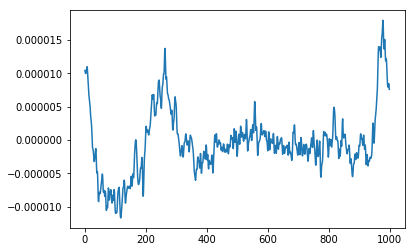

In [128]:
plt.plot(data_1[0][0].T)

In [126]:
chn_14 = reader.readSignal(14)

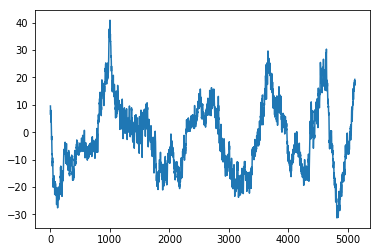

In [131]:
plt.plot(chn_14[256*220:256*240])

## gonna try tfrecords to speed up training

In [2]:
fullDataPage = ppv2.get_pickle_data(trainIndexDict[0].edf_file, 0)

NameError: name 'ppv2' is not defined

In [ ]:
fullDataPage[2].start

In [ ]:
import tensorflow as tf

# Helperfunctions to make your feature definition more readable
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_feature_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
# Helperfunctions to make your feature definition more readable
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))



# Helperfunctions to make your feature definition more readable
def _float_feature_list(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [10]:
trainIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb"))

In [66]:
trainIndexDict[0].start

0

In [68]:
trainIndexDict[2].start

40

In [9]:
validIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "rb"))
testIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb"))

In [25]:
len(trainIndexDict), len(validIndexDict), len(testIndexDict)

(67552, 15594, 24097)

In [31]:
for i in trainIndexDict.keys():
    trainIndexDict[i].original_ind = i
for i in validIndexDict.keys():
    validIndexDict[i].original_ind = i
for i in testIndexDict.keys():
    testIndexDict[i].original_ind = i

In [6]:
reload(read)
allTrainPatients = read.getAllTrainPatients()

In [8]:
xData = ppv2.get_data_from_start(trainIndexDict[0].edf_file, trainIndexDict[0].start)

In [9]:
xData.shape

(21, 1000)

In [35]:
import preprocessingV2.preprocessingV2 as ppv2
def get_data_from_index_datum(index_datum, is_train = True, split="train"):
    xData = ppv2.get_data_from_start(index_datum.edf_file, index_datum.start, split=split)
    yData = index_datum.time_seizure_label
    ySubtypeData = index_datum.time_seizure_subtypes
    split, patient, session, token = read.parse_edf_token_path_structure(index_datum.edf_file)
    montage_data = read.gen_seizure_channel_labels(index_datum.edf_file[:-4] + ".lbl", width=pd.Timedelta(seconds=2)).loc[pd.Timedelta(seconds=index_datum.start):pd.Timedelta(seconds=index_datum.start+20)]
    feature = { \
               'original_index': _int64_feature(index_datum.original_ind),
               'data': _float_feature_list(xData.reshape(-1)), \
               'label': _int64_feature_list(yData.to_numpy().reshape(-1)), \
               'subtypeLabel': _int64_feature_list(ySubtypeData.to_numpy().reshape(-1)), \
               'patient': _int64_feature(read.getAllTrainPatients().index(patient) if is_train else 0), \
               'session': _int64_feature(read.getAllTrainSessions().index(session) if is_train else 0)
              }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [19]:
def train_generator(givenRange):
    def give_gen():
        for i in givenRange:
            print("{}/{}".format(i, len(givenRange)))
            yield get_data_from_index_datum(trainIndexDict[i]).SerializeToString()
    return give_gen

In [20]:
def valid_generator(givenRange):
    def give_gen():
        for i in givenRange:
            print("{}/{}".format(i, len(givenRange)))
            yield get_data_from_index_datum(validIndexDict[i], is_train=False, split="valid").SerializeToString()
    return give_gen
def test_generator(givenRange):
    def give_gen():
        for i in givenRange:
            print("{}/{}".format(i, len(givenRange)))
            yield get_data_from_index_datum(testIndexDict[i], is_train=False, split="test").SerializeToString()
    return give_gen

In [9]:
from joblib import Parallel, delayed

In [11]:
totalTrainLen = len(trainIndexDict)
totalTrainLen

67552

In [12]:
67552/4

16888.0

In [22]:
valid_data_1 = tf.data.Dataset.from_generator(valid_generator(range(0,3898)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
valid_data_2 = tf.data.Dataset.from_generator(valid_generator(range(3898, 3898*2)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
valid_data_3 = tf.data.Dataset.from_generator(valid_generator(range(3898*2, 3898*3)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
valid_data_4 = tf.data.Dataset.from_generator(valid_generator(range(3898*3, 15594)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [23]:
data_1 = tf.data.Dataset.from_generator(train_generator(range(0,16888)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
data_2 = tf.data.Dataset.from_generator(train_generator(range(16888, 16888*2)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
data_3 = tf.data.Dataset.from_generator(train_generator(range(16888*2, 16888*3)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
data_4 = tf.data.Dataset.from_generator(train_generator(range(16888*3, 16888*4)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))

In [36]:
len(testIndexDict)

24097

In [24]:
test_data_1 = tf.data.Dataset.from_generator(test_generator(range(0,6024)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
test_data_2 = tf.data.Dataset.from_generator(test_generator(range(6024, 6024*2)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
test_data_3 = tf.data.Dataset.from_generator(test_generator(range(6024*2, 6024*3)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))
test_data_4 = tf.data.Dataset.from_generator(test_generator(range(6024*3, 24097)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([])))

In [ ]:
def write(data, fn):
    writer = tf.data.experimental.TFRecordWriter(fn)
    writer.write(data)
write(data_1, "/n/scratch2/ms994/train_1.v2.tfrecords")

0/16888
1/16888
2/16888
3/16888
4/16888
5/16888
6/16888
7/16888
8/16888
9/16888
10/16888
11/16888
12/16888
13/16888
14/16888
15/16888
16/16888
17/16888
18/16888
19/16888
20/16888
21/16888
22/16888
23/16888
24/16888
25/16888
26/16888
27/16888
28/16888
29/16888
30/16888
31/16888
32/16888
33/16888
34/16888
35/16888
36/16888
37/16888
38/16888
39/16888
40/16888
41/16888
42/16888
43/16888
44/16888
45/16888
46/16888
47/16888
48/16888
49/16888
50/16888
51/16888
52/16888
53/16888
54/16888
55/16888
56/16888
57/16888
58/16888
59/16888
60/16888
61/16888
62/16888
63/16888
64/16888
65/16888
66/16888
67/16888
68/16888
69/16888
70/16888
71/16888
72/16888
73/16888
74/16888
75/16888
76/16888
77/16888
78/16888
79/16888
80/16888
81/16888
82/16888
83/16888
84/16888
85/16888
86/16888
87/16888
88/16888
89/16888
90/16888
91/16888
92/16888
93/16888
94/16888
95/16888
96/16888
97/16888
98/16888
99/16888
100/16888
101/16888
102/16888
103/16888
104/16888
105/16888
106/16888
107/16888
108/16888
109/16888
110/16888


In [ ]:
def write(data, fn):
    writer = tf.data.experimental.TFRecordWriter(fn)
    writer.write(data)
write(data_1, "/n/scratch2/ms994/train_1.tfrecords")
write(data_2, "/n/scratch2/ms994/train_2.tfrecords") 
write(data_3, "/n/scratch2/ms994/train_3.tfrecords")
write(data_4, "/n/scratch2/ms994/train_4.tfrecords")
write(valid_data_1, "/n/scratch2/ms994/valid_1.tfrecords")
write(test_data_1, "/n/scratch2/ms994/test_1.tfrecords")
write(valid_data_2, "/n/scratch2/ms994/valid_2.tfrecords")
write(test_data_2, "/n/scratch2/ms994/test_2.tfrecords")
write(valid_data_3, "/n/scratch2/ms994/valid_3.tfrecords")
write(test_data_3, "/n/scratch2/ms994/test_3.tfrecords")
write(valid_data_4, "/n/scratch2/ms994/valid_4.tfrecords")
write(test_data_4, "/n/scratch2/ms994/test_4.tfrecords")


0/16888
1/16888
2/16888
3/16888
4/16888
5/16888
6/16888
7/16888
8/16888
9/16888
10/16888
11/16888
12/16888
13/16888
14/16888
15/16888
16/16888
17/16888
18/16888
19/16888
20/16888
21/16888
22/16888
23/16888
24/16888
25/16888
26/16888
27/16888
28/16888
29/16888
30/16888
31/16888
32/16888
33/16888
34/16888
35/16888
36/16888
37/16888
38/16888
39/16888
40/16888
41/16888
42/16888
43/16888
44/16888
45/16888
46/16888
47/16888
48/16888
49/16888
50/16888
51/16888
52/16888
53/16888
54/16888
55/16888
56/16888
57/16888
58/16888
59/16888
60/16888
61/16888
62/16888
63/16888
64/16888
65/16888
66/16888
67/16888
68/16888
69/16888
70/16888
71/16888
72/16888
73/16888
74/16888
75/16888
76/16888
77/16888
78/16888
79/16888
80/16888
81/16888
82/16888
83/16888
84/16888
85/16888
86/16888
87/16888
88/16888
89/16888
90/16888
91/16888
92/16888
93/16888
94/16888
95/16888
96/16888
97/16888
98/16888
99/16888
100/16888
101/16888
102/16888
103/16888
104/16888
105/16888
106/16888
107/16888
108/16888
109/16888
110/16888


833/16888
834/16888
835/16888
836/16888
837/16888
838/16888
839/16888
840/16888
841/16888
842/16888
843/16888
844/16888
845/16888
846/16888
847/16888
848/16888
849/16888
850/16888
851/16888
852/16888
853/16888
854/16888
855/16888
856/16888
857/16888
858/16888
859/16888
860/16888
861/16888
862/16888
863/16888
864/16888
865/16888
866/16888
867/16888
868/16888
869/16888
870/16888
871/16888
872/16888
873/16888
874/16888
875/16888
876/16888
877/16888
878/16888
879/16888
880/16888
881/16888
882/16888
883/16888
884/16888
885/16888
886/16888
887/16888
888/16888
889/16888
890/16888
891/16888
892/16888
893/16888
894/16888
895/16888
896/16888
897/16888
898/16888
899/16888
900/16888
901/16888
902/16888
903/16888
904/16888
905/16888
906/16888
907/16888
908/16888
909/16888
910/16888
911/16888
912/16888
913/16888
914/16888
915/16888
916/16888
917/16888
918/16888
919/16888
920/16888
921/16888
922/16888
923/16888
924/16888
925/16888
926/16888
927/16888
928/16888
929/16888
930/16888
931/16888
932/16888


1594/16888
1595/16888
1596/16888
1597/16888
1598/16888
1599/16888
1600/16888
1601/16888
1602/16888
1603/16888
1604/16888
1605/16888
1606/16888
1607/16888
1608/16888
1609/16888
1610/16888
1611/16888
1612/16888
1613/16888
1614/16888
1615/16888
1616/16888
1617/16888
1618/16888
1619/16888
1620/16888
1621/16888
1622/16888
1623/16888
1624/16888
1625/16888
1626/16888
1627/16888
1628/16888
1629/16888
1630/16888
1631/16888
1632/16888
1633/16888
1634/16888
1635/16888
1636/16888
1637/16888
1638/16888
1639/16888
1640/16888
1641/16888
1642/16888
1643/16888
1644/16888
1645/16888
1646/16888
1647/16888
1648/16888
1649/16888
1650/16888
1651/16888
1652/16888
1653/16888
1654/16888
1655/16888
1656/16888
1657/16888
1658/16888
1659/16888
1660/16888
1661/16888
1662/16888
1663/16888
1664/16888
1665/16888
1666/16888
1667/16888
1668/16888
1669/16888
1670/16888
1671/16888
1672/16888
1673/16888
1674/16888
1675/16888
1676/16888
1677/16888
1678/16888
1679/16888
1680/16888
1681/16888
1682/16888
1683/16888
1684/16888

2341/16888
2342/16888
2343/16888
2344/16888
2345/16888
2346/16888
2347/16888
2348/16888
2349/16888
2350/16888
2351/16888
2352/16888
2353/16888
2354/16888
2355/16888
2356/16888
2357/16888
2358/16888
2359/16888
2360/16888
2361/16888
2362/16888
2363/16888
2364/16888
2365/16888
2366/16888
2367/16888
2368/16888
2369/16888
2370/16888
2371/16888
2372/16888
2373/16888
2374/16888
2375/16888
2376/16888
2377/16888
2378/16888
2379/16888
2380/16888
2381/16888
2382/16888
2383/16888
2384/16888
2385/16888
2386/16888
2387/16888
2388/16888
2389/16888
2390/16888
2391/16888
2392/16888
2393/16888
2394/16888
2395/16888
2396/16888
2397/16888
2398/16888
2399/16888
2400/16888
2401/16888
2402/16888
2403/16888
2404/16888
2405/16888
2406/16888
2407/16888
2408/16888
2409/16888
2410/16888
2411/16888
2412/16888
2413/16888
2414/16888
2415/16888
2416/16888
2417/16888
2418/16888
2419/16888
2420/16888
2421/16888
2422/16888
2423/16888
2424/16888
2425/16888
2426/16888
2427/16888
2428/16888
2429/16888
2430/16888
2431/16888

3087/16888
3088/16888
3089/16888
3090/16888
3091/16888
3092/16888
3093/16888
3094/16888
3095/16888
3096/16888
3097/16888
3098/16888
3099/16888
3100/16888
3101/16888
3102/16888
3103/16888
3104/16888
3105/16888
3106/16888
3107/16888
3108/16888
3109/16888
3110/16888
3111/16888
3112/16888
3113/16888
3114/16888
3115/16888
3116/16888
3117/16888
3118/16888
3119/16888
3120/16888
3121/16888
3122/16888
3123/16888
3124/16888
3125/16888
3126/16888
3127/16888
3128/16888
3129/16888
3130/16888
3131/16888
3132/16888
3133/16888
3134/16888
3135/16888
3136/16888
3137/16888
3138/16888
3139/16888
3140/16888
3141/16888
3142/16888
3143/16888
3144/16888
3145/16888
3146/16888
3147/16888
3148/16888
3149/16888
3150/16888
3151/16888
3152/16888
3153/16888
3154/16888
3155/16888
3156/16888
3157/16888
3158/16888
3159/16888
3160/16888
3161/16888
3162/16888
3163/16888
3164/16888
3165/16888
3166/16888
3167/16888
3168/16888
3169/16888
3170/16888
3171/16888
3172/16888
3173/16888
3174/16888
3175/16888
3176/16888
3177/16888

3835/16888
3836/16888
3837/16888
3838/16888
3839/16888
3840/16888
3841/16888
3842/16888
3843/16888
3844/16888
3845/16888
3846/16888
3847/16888
3848/16888
3849/16888
3850/16888
3851/16888
3852/16888
3853/16888
3854/16888
3855/16888
3856/16888
3857/16888
3858/16888
3859/16888
3860/16888
3861/16888
3862/16888
3863/16888
3864/16888
3865/16888
3866/16888
3867/16888
3868/16888
3869/16888
3870/16888
3871/16888
3872/16888
3873/16888
3874/16888
3875/16888
3876/16888
3877/16888
3878/16888
3879/16888
3880/16888
3881/16888
3882/16888
3883/16888
3884/16888
3885/16888
3886/16888
3887/16888
3888/16888
3889/16888
3890/16888
3891/16888
3892/16888
3893/16888
3894/16888
3895/16888
3896/16888
3897/16888
3898/16888
3899/16888
3900/16888
3901/16888
3902/16888
3903/16888
3904/16888
3905/16888
3906/16888
3907/16888
3908/16888
3909/16888
3910/16888
3911/16888
3912/16888
3913/16888
3914/16888
3915/16888
3916/16888
3917/16888
3918/16888
3919/16888
3920/16888
3921/16888
3922/16888
3923/16888
3924/16888
3925/16888

4580/16888
4581/16888
4582/16888
4583/16888
4584/16888
4585/16888
4586/16888
4587/16888
4588/16888
4589/16888
4590/16888
4591/16888
4592/16888
4593/16888
4594/16888
4595/16888
4596/16888
4597/16888
4598/16888
4599/16888
4600/16888
4601/16888
4602/16888
4603/16888
4604/16888
4605/16888
4606/16888
4607/16888
4608/16888
4609/16888
4610/16888
4611/16888
4612/16888
4613/16888
4614/16888
4615/16888
4616/16888
4617/16888
4618/16888
4619/16888
4620/16888
4621/16888
4622/16888
4623/16888
4624/16888
4625/16888
4626/16888
4627/16888
4628/16888
4629/16888
4630/16888
4631/16888
4632/16888
4633/16888
4634/16888
4635/16888
4636/16888
4637/16888
4638/16888
4639/16888
4640/16888
4641/16888
4642/16888
4643/16888
4644/16888
4645/16888
4646/16888
4647/16888
4648/16888
4649/16888
4650/16888
4651/16888
4652/16888
4653/16888
4654/16888
4655/16888
4656/16888
4657/16888
4658/16888
4659/16888
4660/16888
4661/16888
4662/16888
4663/16888
4664/16888
4665/16888
4666/16888
4667/16888
4668/16888
4669/16888
4670/16888

5327/16888
5328/16888
5329/16888
5330/16888
5331/16888
5332/16888
5333/16888
5334/16888
5335/16888
5336/16888
5337/16888
5338/16888
5339/16888
5340/16888
5341/16888
5342/16888
5343/16888
5344/16888
5345/16888
5346/16888
5347/16888
5348/16888
5349/16888
5350/16888
5351/16888
5352/16888
5353/16888
5354/16888
5355/16888
5356/16888
5357/16888
5358/16888
5359/16888
5360/16888
5361/16888
5362/16888
5363/16888
5364/16888
5365/16888
5366/16888
5367/16888
5368/16888
5369/16888
5370/16888
5371/16888
5372/16888
5373/16888
5374/16888
5375/16888
5376/16888
5377/16888
5378/16888
5379/16888
5380/16888
5381/16888
5382/16888
5383/16888
5384/16888
5385/16888
5386/16888
5387/16888
5388/16888
5389/16888
5390/16888
5391/16888
5392/16888
5393/16888
5394/16888
5395/16888
5396/16888
5397/16888
5398/16888
5399/16888
5400/16888
5401/16888
5402/16888
5403/16888
5404/16888
5405/16888
5406/16888
5407/16888
5408/16888
5409/16888
5410/16888
5411/16888
5412/16888
5413/16888
5414/16888
5415/16888
5416/16888
5417/16888

6073/16888
6074/16888
6075/16888
6076/16888
6077/16888
6078/16888
6079/16888
6080/16888
6081/16888
6082/16888
6083/16888
6084/16888
6085/16888
6086/16888
6087/16888
6088/16888
6089/16888
6090/16888
6091/16888
6092/16888
6093/16888
6094/16888
6095/16888
6096/16888
6097/16888
6098/16888
6099/16888
6100/16888
6101/16888
6102/16888
6103/16888
6104/16888
6105/16888
6106/16888
6107/16888
6108/16888
6109/16888
6110/16888
6111/16888
6112/16888
6113/16888
6114/16888
6115/16888
6116/16888
6117/16888
6118/16888
6119/16888
6120/16888
6121/16888
6122/16888
6123/16888
6124/16888
6125/16888
6126/16888
6127/16888
6128/16888
6129/16888
6130/16888
6131/16888
6132/16888
6133/16888
6134/16888
6135/16888
6136/16888
6137/16888
6138/16888
6139/16888
6140/16888
6141/16888
6142/16888
6143/16888
6144/16888
6145/16888
6146/16888
6147/16888
6148/16888
6149/16888
6150/16888
6151/16888
6152/16888
6153/16888
6154/16888
6155/16888
6156/16888
6157/16888
6158/16888
6159/16888
6160/16888
6161/16888
6162/16888
6163/16888

6821/16888
6822/16888
6823/16888
6824/16888
6825/16888
6826/16888
6827/16888
6828/16888
6829/16888
6830/16888
6831/16888
6832/16888
6833/16888
6834/16888
6835/16888
6836/16888
6837/16888
6838/16888
6839/16888
6840/16888
6841/16888
6842/16888
6843/16888
6844/16888
6845/16888
6846/16888
6847/16888
6848/16888
6849/16888
6850/16888
6851/16888
6852/16888
6853/16888
6854/16888
6855/16888
6856/16888
6857/16888
6858/16888
6859/16888
6860/16888
6861/16888
6862/16888
6863/16888
6864/16888
6865/16888
6866/16888
6867/16888
6868/16888
6869/16888
6870/16888
6871/16888
6872/16888
6873/16888
6874/16888
6875/16888
6876/16888
6877/16888
6878/16888
6879/16888
6880/16888
6881/16888
6882/16888
6883/16888
6884/16888
6885/16888
6886/16888
6887/16888
6888/16888
6889/16888
6890/16888
6891/16888
6892/16888
6893/16888
6894/16888
6895/16888
6896/16888
6897/16888
6898/16888
6899/16888
6900/16888
6901/16888
6902/16888
6903/16888
6904/16888
6905/16888
6906/16888
6907/16888
6908/16888
6909/16888
6910/16888
6911/16888

7567/16888
7568/16888
7569/16888
7570/16888
7571/16888
7572/16888
7573/16888
7574/16888
7575/16888
7576/16888
7577/16888
7578/16888
7579/16888
7580/16888
7581/16888
7582/16888
7583/16888
7584/16888
7585/16888
7586/16888
7587/16888
7588/16888
7589/16888
7590/16888
7591/16888
7592/16888
7593/16888
7594/16888
7595/16888
7596/16888
7597/16888
7598/16888
7599/16888
7600/16888
7601/16888
7602/16888
7603/16888
7604/16888
7605/16888
7606/16888
7607/16888
7608/16888
7609/16888
7610/16888
7611/16888
7612/16888
7613/16888
7614/16888
7615/16888
7616/16888
7617/16888
7618/16888
7619/16888
7620/16888
7621/16888
7622/16888
7623/16888
7624/16888
7625/16888
7626/16888
7627/16888
7628/16888
7629/16888
7630/16888
7631/16888
7632/16888
7633/16888
7634/16888
7635/16888
7636/16888
7637/16888
7638/16888
7639/16888
7640/16888
7641/16888
7642/16888
7643/16888
7644/16888
7645/16888
7646/16888
7647/16888
7648/16888
7649/16888
7650/16888
7651/16888
7652/16888
7653/16888
7654/16888
7655/16888
7656/16888
7657/16888

8314/16888
8315/16888
8316/16888
8317/16888
8318/16888
8319/16888
8320/16888
8321/16888
8322/16888
8323/16888
8324/16888
8325/16888
8326/16888
8327/16888
8328/16888
8329/16888
8330/16888
8331/16888
8332/16888
8333/16888
8334/16888
8335/16888
8336/16888
8337/16888
8338/16888
8339/16888
8340/16888
8341/16888
8342/16888
8343/16888
8344/16888
8345/16888
8346/16888
8347/16888
8348/16888
8349/16888
8350/16888
8351/16888
8352/16888
8353/16888
8354/16888
8355/16888
8356/16888
8357/16888
8358/16888
8359/16888
8360/16888
8361/16888
8362/16888
8363/16888
8364/16888
8365/16888
8366/16888
8367/16888
8368/16888
8369/16888
8370/16888
8371/16888
8372/16888
8373/16888
8374/16888
8375/16888
8376/16888
8377/16888
8378/16888
8379/16888
8380/16888
8381/16888
8382/16888
8383/16888
8384/16888
8385/16888
8386/16888
8387/16888
8388/16888
8389/16888
8390/16888
8391/16888
8392/16888
8393/16888
8394/16888
8395/16888
8396/16888
8397/16888
8398/16888
8399/16888
8400/16888
8401/16888
8402/16888
8403/16888
8404/16888

9059/16888
9060/16888
9061/16888
9062/16888
9063/16888
9064/16888
9065/16888
9066/16888
9067/16888
9068/16888
9069/16888
9070/16888
9071/16888
9072/16888
9073/16888
9074/16888
9075/16888
9076/16888
9077/16888
9078/16888
9079/16888
9080/16888
9081/16888
9082/16888
9083/16888
9084/16888
9085/16888
9086/16888
9087/16888
9088/16888
9089/16888
9090/16888
9091/16888
9092/16888
9093/16888
9094/16888
9095/16888
9096/16888
9097/16888
9098/16888
9099/16888
9100/16888
9101/16888
9102/16888
9103/16888
9104/16888
9105/16888
9106/16888
9107/16888
9108/16888
9109/16888
9110/16888
9111/16888
9112/16888
9113/16888
9114/16888
9115/16888
9116/16888
9117/16888
9118/16888
9119/16888
9120/16888
9121/16888
9122/16888
9123/16888
9124/16888
9125/16888
9126/16888
9127/16888
9128/16888
9129/16888
9130/16888
9131/16888
9132/16888
9133/16888
9134/16888
9135/16888
9136/16888
9137/16888
9138/16888
9139/16888
9140/16888
9141/16888
9142/16888
9143/16888
9144/16888
9145/16888
9146/16888
9147/16888
9148/16888
9149/16888

9804/16888
9805/16888
9806/16888
9807/16888
9808/16888
9809/16888
9810/16888
9811/16888
9812/16888
9813/16888
9814/16888
9815/16888
9816/16888
9817/16888
9818/16888
9819/16888
9820/16888
9821/16888
9822/16888
9823/16888
9824/16888
9825/16888
9826/16888
9827/16888
9828/16888
9829/16888
9830/16888
9831/16888
9832/16888
9833/16888
9834/16888
9835/16888
9836/16888
9837/16888
9838/16888
9839/16888
9840/16888
9841/16888
9842/16888
9843/16888
9844/16888
9845/16888
9846/16888
9847/16888
9848/16888
9849/16888
9850/16888
9851/16888
9852/16888
9853/16888
9854/16888
9855/16888
9856/16888
9857/16888
9858/16888
9859/16888
9860/16888
9861/16888
9862/16888
9863/16888
9864/16888
9865/16888
9866/16888
9867/16888
9868/16888
9869/16888
9870/16888
9871/16888
9872/16888
9873/16888
9874/16888
9875/16888
9876/16888
9877/16888
9878/16888
9879/16888
9880/16888
9881/16888
9882/16888
9883/16888
9884/16888
9885/16888
9886/16888
9887/16888
9888/16888
9889/16888
9890/16888
9891/16888
9892/16888
9893/16888
9894/16888

10505/16888
10506/16888
10507/16888
10508/16888
10509/16888
10510/16888
10511/16888
10512/16888
10513/16888
10514/16888
10515/16888
10516/16888
10517/16888
10518/16888
10519/16888
10520/16888
10521/16888
10522/16888
10523/16888
10524/16888
10525/16888
10526/16888
10527/16888
10528/16888
10529/16888
10530/16888
10531/16888
10532/16888
10533/16888
10534/16888
10535/16888
10536/16888
10537/16888
10538/16888
10539/16888
10540/16888
10541/16888
10542/16888
10543/16888
10544/16888
10545/16888
10546/16888
10547/16888
10548/16888
10549/16888
10550/16888
10551/16888
10552/16888
10553/16888
10554/16888
10555/16888
10556/16888
10557/16888
10558/16888
10559/16888
10560/16888
10561/16888
10562/16888
10563/16888
10564/16888
10565/16888
10566/16888
10567/16888
10568/16888
10569/16888
10570/16888
10571/16888
10572/16888
10573/16888
10574/16888
10575/16888
10576/16888
10577/16888
10578/16888
10579/16888
10580/16888
10581/16888
10582/16888
10583/16888
10584/16888
10585/16888
10586/16888
10587/16888
1058

11189/16888
11190/16888
11191/16888
11192/16888
11193/16888
11194/16888
11195/16888
11196/16888
11197/16888
11198/16888
11199/16888
11200/16888
11201/16888
11202/16888
11203/16888
11204/16888
11205/16888
11206/16888
11207/16888
11208/16888
11209/16888
11210/16888
11211/16888
11212/16888
11213/16888
11214/16888
11215/16888
11216/16888
11217/16888
11218/16888
11219/16888
11220/16888
11221/16888
11222/16888
11223/16888
11224/16888
11225/16888
11226/16888
11227/16888
11228/16888
11229/16888
11230/16888
11231/16888
11232/16888
11233/16888
11234/16888
11235/16888
11236/16888
11237/16888
11238/16888
11239/16888
11240/16888
11241/16888
11242/16888
11243/16888
11244/16888
11245/16888
11246/16888
11247/16888
11248/16888
11249/16888
11250/16888
11251/16888
11252/16888
11253/16888
11254/16888
11255/16888
11256/16888
11257/16888
11258/16888
11259/16888
11260/16888
11261/16888
11262/16888
11263/16888
11264/16888
11265/16888
11266/16888
11267/16888
11268/16888
11269/16888
11270/16888
11271/16888
1127

11875/16888
11876/16888
11877/16888
11878/16888
11879/16888
11880/16888
11881/16888
11882/16888
11883/16888
11884/16888
11885/16888
11886/16888
11887/16888
11888/16888
11889/16888
11890/16888
11891/16888
11892/16888
11893/16888
11894/16888
11895/16888
11896/16888
11897/16888
11898/16888
11899/16888
11900/16888
11901/16888
11902/16888
11903/16888
11904/16888
11905/16888
11906/16888
11907/16888
11908/16888
11909/16888
11910/16888
11911/16888
11912/16888
11913/16888
11914/16888
11915/16888
11916/16888
11917/16888
11918/16888
11919/16888
11920/16888
11921/16888
11922/16888
11923/16888
11924/16888
11925/16888
11926/16888
11927/16888
11928/16888
11929/16888
11930/16888
11931/16888
11932/16888
11933/16888
11934/16888
11935/16888
11936/16888
11937/16888
11938/16888
11939/16888
11940/16888
11941/16888
11942/16888
11943/16888
11944/16888
11945/16888
11946/16888
11947/16888
11948/16888
11949/16888
11950/16888
11951/16888
11952/16888
11953/16888
11954/16888
11955/16888
11956/16888
11957/16888
1195

12559/16888
12560/16888
12561/16888
12562/16888
12563/16888
12564/16888
12565/16888
12566/16888
12567/16888
12568/16888
12569/16888
12570/16888
12571/16888
12572/16888
12573/16888
12574/16888
12575/16888
12576/16888
12577/16888
12578/16888
12579/16888
12580/16888
12581/16888
12582/16888
12583/16888
12584/16888
12585/16888
12586/16888
12587/16888
12588/16888
12589/16888
12590/16888
12591/16888
12592/16888
12593/16888
12594/16888
12595/16888
12596/16888
12597/16888
12598/16888
12599/16888
12600/16888
12601/16888
12602/16888
12603/16888
12604/16888
12605/16888
12606/16888
12607/16888
12608/16888
12609/16888
12610/16888
12611/16888
12612/16888
12613/16888
12614/16888
12615/16888
12616/16888
12617/16888
12618/16888
12619/16888
12620/16888
12621/16888
12622/16888
12623/16888
12624/16888
12625/16888
12626/16888
12627/16888
12628/16888
12629/16888
12630/16888
12631/16888
12632/16888
12633/16888
12634/16888
12635/16888
12636/16888
12637/16888
12638/16888
12639/16888
12640/16888
12641/16888
1264

13245/16888
13246/16888
13247/16888
13248/16888
13249/16888
13250/16888
13251/16888
13252/16888
13253/16888
13254/16888
13255/16888
13256/16888
13257/16888
13258/16888
13259/16888
13260/16888
13261/16888
13262/16888
13263/16888
13264/16888
13265/16888
13266/16888
13267/16888
13268/16888
13269/16888
13270/16888
13271/16888
13272/16888
13273/16888
13274/16888
13275/16888
13276/16888
13277/16888
13278/16888
13279/16888
13280/16888
13281/16888
13282/16888
13283/16888
13284/16888
13285/16888
13286/16888
13287/16888
13288/16888
13289/16888
13290/16888
13291/16888
13292/16888
13293/16888
13294/16888
13295/16888
13296/16888
13297/16888
13298/16888
13299/16888
13300/16888
13301/16888
13302/16888
13303/16888
13304/16888
13305/16888
13306/16888
13307/16888
13308/16888
13309/16888
13310/16888
13311/16888
13312/16888
13313/16888
13314/16888
13315/16888
13316/16888
13317/16888
13318/16888
13319/16888
13320/16888
13321/16888
13322/16888
13323/16888
13324/16888
13325/16888
13326/16888
13327/16888
1332

13931/16888
13932/16888
13933/16888
13934/16888
13935/16888
13936/16888
13937/16888
13938/16888
13939/16888
13940/16888
13941/16888
13942/16888
13943/16888
13944/16888
13945/16888
13946/16888
13947/16888
13948/16888
13949/16888
13950/16888
13951/16888
13952/16888
13953/16888
13954/16888
13955/16888
13956/16888
13957/16888
13958/16888
13959/16888
13960/16888
13961/16888
13962/16888
13963/16888
13964/16888
13965/16888
13966/16888
13967/16888
13968/16888
13969/16888
13970/16888
13971/16888
13972/16888
13973/16888
13974/16888
13975/16888
13976/16888
13977/16888
13978/16888
13979/16888
13980/16888
13981/16888
13982/16888
13983/16888
13984/16888
13985/16888
13986/16888
13987/16888
13988/16888
13989/16888
13990/16888
13991/16888
13992/16888
13993/16888
13994/16888
13995/16888
13996/16888
13997/16888
13998/16888
13999/16888
14000/16888
14001/16888
14002/16888
14003/16888
14004/16888
14005/16888
14006/16888
14007/16888
14008/16888
14009/16888
14010/16888
14011/16888
14012/16888
14013/16888
1401

14614/16888
14615/16888
14616/16888
14617/16888
14618/16888
14619/16888
14620/16888
14621/16888
14622/16888
14623/16888
14624/16888
14625/16888
14626/16888
14627/16888
14628/16888
14629/16888
14630/16888
14631/16888
14632/16888
14633/16888
14634/16888
14635/16888
14636/16888
14637/16888
14638/16888
14639/16888
14640/16888
14641/16888
14642/16888
14643/16888
14644/16888
14645/16888
14646/16888
14647/16888
14648/16888
14649/16888
14650/16888
14651/16888
14652/16888
14653/16888
14654/16888
14655/16888
14656/16888
14657/16888
14658/16888
14659/16888
14660/16888
14661/16888
14662/16888
14663/16888
14664/16888
14665/16888
14666/16888
14667/16888
14668/16888
14669/16888
14670/16888
14671/16888
14672/16888
14673/16888
14674/16888
14675/16888
14676/16888
14677/16888
14678/16888
14679/16888
14680/16888
14681/16888
14682/16888
14683/16888
14684/16888
14685/16888
14686/16888
14687/16888
14688/16888
14689/16888
14690/16888
14691/16888
14692/16888
14693/16888
14694/16888
14695/16888
14696/16888
1469

15297/16888
15298/16888
15299/16888
15300/16888
15301/16888
15302/16888
15303/16888
15304/16888
15305/16888
15306/16888
15307/16888
15308/16888
15309/16888
15310/16888
15311/16888
15312/16888
15313/16888
15314/16888
15315/16888
15316/16888
15317/16888
15318/16888
15319/16888
15320/16888
15321/16888
15322/16888
15323/16888
15324/16888
15325/16888
15326/16888
15327/16888
15328/16888
15329/16888
15330/16888
15331/16888
15332/16888
15333/16888
15334/16888
15335/16888
15336/16888
15337/16888
15338/16888
15339/16888
15340/16888
15341/16888
15342/16888
15343/16888
15344/16888
15345/16888
15346/16888
15347/16888
15348/16888
15349/16888
15350/16888
15351/16888
15352/16888
15353/16888
15354/16888
15355/16888
15356/16888
15357/16888
15358/16888
15359/16888
15360/16888
15361/16888
15362/16888
15363/16888
15364/16888
15365/16888
15366/16888
15367/16888
15368/16888
15369/16888
15370/16888
15371/16888
15372/16888
15373/16888
15374/16888
15375/16888
15376/16888
15377/16888
15378/16888
15379/16888
1538

15980/16888
15981/16888
15982/16888
15983/16888
15984/16888
15985/16888
15986/16888
15987/16888
15988/16888
15989/16888
15990/16888
15991/16888
15992/16888
15993/16888
15994/16888
15995/16888
15996/16888
15997/16888
15998/16888
15999/16888
16000/16888
16001/16888
16002/16888
16003/16888
16004/16888
16005/16888
16006/16888
16007/16888
16008/16888
16009/16888
16010/16888
16011/16888
16012/16888
16013/16888
16014/16888
16015/16888
16016/16888
16017/16888
16018/16888
16019/16888
16020/16888
16021/16888
16022/16888
16023/16888
16024/16888
16025/16888
16026/16888
16027/16888
16028/16888
16029/16888
16030/16888
16031/16888
16032/16888
16033/16888
16034/16888
16035/16888
16036/16888
16037/16888
16038/16888
16039/16888
16040/16888
16041/16888
16042/16888
16043/16888
16044/16888
16045/16888
16046/16888
16047/16888
16048/16888
16049/16888
16050/16888
16051/16888
16052/16888
16053/16888
16054/16888
16055/16888
16056/16888
16057/16888
16058/16888
16059/16888
16060/16888
16061/16888
16062/16888
1606

16665/16888
16666/16888
16667/16888
16668/16888
16669/16888
16670/16888
16671/16888
16672/16888
16673/16888
16674/16888
16675/16888
16676/16888
16677/16888
16678/16888
16679/16888
16680/16888
16681/16888
16682/16888
16683/16888
16684/16888
16685/16888
16686/16888
16687/16888
16688/16888
16689/16888
16690/16888
16691/16888
16692/16888
16693/16888
16694/16888
16695/16888
16696/16888
16697/16888
16698/16888
16699/16888
16700/16888
16701/16888
16702/16888
16703/16888
16704/16888
16705/16888
16706/16888
16707/16888
16708/16888
16709/16888
16710/16888
16711/16888
16712/16888
16713/16888
16714/16888
16715/16888
16716/16888
16717/16888
16718/16888
16719/16888
16720/16888
16721/16888
16722/16888
16723/16888
16724/16888
16725/16888
16726/16888
16727/16888
16728/16888
16729/16888
16730/16888
16731/16888
16732/16888
16733/16888
16734/16888
16735/16888
16736/16888
16737/16888
16738/16888
16739/16888
16740/16888
16741/16888
16742/16888
16743/16888
16744/16888
16745/16888
16746/16888
16747/16888
1674

17349/16888
17350/16888
17351/16888
17352/16888
17353/16888
17354/16888
17355/16888
17356/16888
17357/16888
17358/16888
17359/16888
17360/16888
17361/16888
17362/16888
17363/16888
17364/16888
17365/16888
17366/16888
17367/16888
17368/16888
17369/16888
17370/16888
17371/16888
17372/16888
17373/16888
17374/16888
17375/16888
17376/16888
17377/16888
17378/16888
17379/16888
17380/16888
17381/16888
17382/16888
17383/16888
17384/16888
17385/16888
17386/16888
17387/16888
17388/16888
17389/16888
17390/16888
17391/16888
17392/16888
17393/16888
17394/16888
17395/16888
17396/16888
17397/16888
17398/16888
17399/16888
17400/16888
17401/16888
17402/16888
17403/16888
17404/16888
17405/16888
17406/16888
17407/16888
17408/16888
17409/16888
17410/16888
17411/16888
17412/16888
17413/16888
17414/16888
17415/16888
17416/16888
17417/16888
17418/16888
17419/16888
17420/16888
17421/16888
17422/16888
17423/16888
17424/16888
17425/16888
17426/16888
17427/16888
17428/16888
17429/16888
17430/16888
17431/16888
1743

18032/16888
18033/16888
18034/16888
18035/16888
18036/16888
18037/16888
18038/16888
18039/16888
18040/16888
18041/16888
18042/16888
18043/16888
18044/16888
18045/16888
18046/16888
18047/16888
18048/16888
18049/16888
18050/16888
18051/16888
18052/16888
18053/16888
18054/16888
18055/16888
18056/16888
18057/16888
18058/16888
18059/16888
18060/16888
18061/16888
18062/16888
18063/16888
18064/16888
18065/16888
18066/16888
18067/16888
18068/16888
18069/16888
18070/16888
18071/16888
18072/16888
18073/16888
18074/16888
18075/16888
18076/16888
18077/16888
18078/16888
18079/16888
18080/16888
18081/16888
18082/16888
18083/16888
18084/16888
18085/16888
18086/16888
18087/16888
18088/16888
18089/16888
18090/16888
18091/16888
18092/16888
18093/16888
18094/16888
18095/16888
18096/16888
18097/16888
18098/16888
18099/16888
18100/16888
18101/16888
18102/16888
18103/16888
18104/16888
18105/16888
18106/16888
18107/16888
18108/16888
18109/16888
18110/16888
18111/16888
18112/16888
18113/16888
18114/16888
1811

18715/16888
18716/16888
18717/16888
18718/16888
18719/16888
18720/16888
18721/16888
18722/16888
18723/16888
18724/16888
18725/16888
18726/16888
18727/16888
18728/16888
18729/16888
18730/16888
18731/16888
18732/16888
18733/16888
18734/16888
18735/16888
18736/16888
18737/16888
18738/16888
18739/16888
18740/16888
18741/16888
18742/16888
18743/16888
18744/16888
18745/16888
18746/16888
18747/16888
18748/16888
18749/16888
18750/16888
18751/16888
18752/16888
18753/16888
18754/16888
18755/16888
18756/16888
18757/16888
18758/16888
18759/16888
18760/16888
18761/16888
18762/16888
18763/16888
18764/16888
18765/16888
18766/16888
18767/16888
18768/16888
18769/16888
18770/16888
18771/16888
18772/16888
18773/16888
18774/16888
18775/16888
18776/16888
18777/16888
18778/16888
18779/16888
18780/16888
18781/16888
18782/16888
18783/16888
18784/16888
18785/16888
18786/16888
18787/16888
18788/16888
18789/16888
18790/16888
18791/16888
18792/16888
18793/16888
18794/16888
18795/16888
18796/16888
18797/16888
1879

19400/16888
19401/16888
19402/16888
19403/16888
19404/16888
19405/16888
19406/16888
19407/16888
19408/16888
19409/16888
19410/16888
19411/16888
19412/16888
19413/16888
19414/16888
19415/16888
19416/16888
19417/16888
19418/16888
19419/16888
19420/16888
19421/16888
19422/16888
19423/16888
19424/16888
19425/16888
19426/16888
19427/16888
19428/16888
19429/16888
19430/16888
19431/16888
19432/16888
19433/16888
19434/16888
19435/16888
19436/16888
19437/16888
19438/16888
19439/16888
19440/16888
19441/16888
19442/16888
19443/16888
19444/16888
19445/16888
19446/16888
19447/16888
19448/16888
19449/16888
19450/16888
19451/16888
19452/16888
19453/16888
19454/16888
19455/16888
19456/16888
19457/16888
19458/16888
19459/16888
19460/16888
19461/16888
19462/16888
19463/16888
19464/16888
19465/16888
19466/16888
19467/16888
19468/16888
19469/16888
19470/16888
19471/16888
19472/16888
19473/16888
19474/16888
19475/16888
19476/16888
19477/16888
19478/16888
19479/16888
19480/16888
19481/16888
19482/16888
1948

20084/16888
20085/16888
20086/16888
20087/16888
20088/16888
20089/16888
20090/16888
20091/16888
20092/16888
20093/16888
20094/16888
20095/16888
20096/16888
20097/16888
20098/16888
20099/16888
20100/16888
20101/16888
20102/16888
20103/16888
20104/16888
20105/16888
20106/16888
20107/16888
20108/16888
20109/16888
20110/16888
20111/16888
20112/16888
20113/16888
20114/16888
20115/16888
20116/16888
20117/16888
20118/16888
20119/16888
20120/16888
20121/16888
20122/16888
20123/16888
20124/16888
20125/16888
20126/16888
20127/16888
20128/16888
20129/16888
20130/16888
20131/16888
20132/16888
20133/16888
20134/16888
20135/16888
20136/16888
20137/16888
20138/16888
20139/16888
20140/16888
20141/16888
20142/16888
20143/16888
20144/16888
20145/16888
20146/16888
20147/16888
20148/16888
20149/16888
20150/16888
20151/16888
20152/16888
20153/16888
20154/16888
20155/16888
20156/16888
20157/16888
20158/16888
20159/16888
20160/16888
20161/16888
20162/16888
20163/16888
20164/16888
20165/16888
20166/16888
2016

20768/16888
20769/16888
20770/16888
20771/16888
20772/16888
20773/16888
20774/16888
20775/16888
20776/16888
20777/16888
20778/16888
20779/16888
20780/16888
20781/16888
20782/16888
20783/16888
20784/16888
20785/16888
20786/16888
20787/16888
20788/16888
20789/16888
20790/16888
20791/16888
20792/16888
20793/16888
20794/16888
20795/16888
20796/16888
20797/16888
20798/16888
20799/16888
20800/16888
20801/16888
20802/16888
20803/16888
20804/16888
20805/16888
20806/16888
20807/16888
20808/16888
20809/16888
20810/16888
20811/16888
20812/16888
20813/16888
20814/16888
20815/16888
20816/16888
20817/16888
20818/16888
20819/16888
20820/16888
20821/16888
20822/16888
20823/16888
20824/16888
20825/16888
20826/16888
20827/16888
20828/16888
20829/16888
20830/16888
20831/16888
20832/16888
20833/16888
20834/16888
20835/16888
20836/16888
20837/16888
20838/16888
20839/16888
20840/16888
20841/16888
20842/16888
20843/16888
20844/16888
20845/16888
20846/16888
20847/16888
20848/16888
20849/16888
20850/16888
2085

21453/16888
21454/16888
21455/16888
21456/16888
21457/16888
21458/16888
21459/16888
21460/16888
21461/16888
21462/16888
21463/16888
21464/16888
21465/16888
21466/16888
21467/16888
21468/16888
21469/16888
21470/16888
21471/16888
21472/16888
21473/16888
21474/16888
21475/16888
21476/16888
21477/16888
21478/16888
21479/16888
21480/16888
21481/16888
21482/16888
21483/16888
21484/16888
21485/16888
21486/16888
21487/16888
21488/16888
21489/16888
21490/16888
21491/16888
21492/16888
21493/16888
21494/16888
21495/16888
21496/16888
21497/16888
21498/16888
21499/16888
21500/16888
21501/16888
21502/16888
21503/16888
21504/16888
21505/16888
21506/16888
21507/16888
21508/16888
21509/16888
21510/16888
21511/16888
21512/16888
21513/16888
21514/16888
21515/16888
21516/16888
21517/16888
21518/16888
21519/16888
21520/16888
21521/16888
21522/16888
21523/16888
21524/16888
21525/16888
21526/16888
21527/16888
21528/16888
21529/16888
21530/16888
21531/16888
21532/16888
21533/16888
21534/16888
21535/16888
2153

22137/16888
22138/16888
22139/16888
22140/16888
22141/16888
22142/16888
22143/16888
22144/16888
22145/16888
22146/16888
22147/16888
22148/16888
22149/16888
22150/16888
22151/16888
22152/16888
22153/16888
22154/16888
22155/16888
22156/16888
22157/16888
22158/16888
22159/16888
22160/16888
22161/16888
22162/16888
22163/16888
22164/16888
22165/16888
22166/16888
22167/16888
22168/16888
22169/16888
22170/16888
22171/16888
22172/16888
22173/16888
22174/16888
22175/16888
22176/16888
22177/16888
22178/16888
22179/16888
22180/16888
22181/16888
22182/16888
22183/16888
22184/16888
22185/16888
22186/16888
22187/16888
22188/16888
22189/16888
22190/16888
22191/16888
22192/16888
22193/16888
22194/16888
22195/16888
22196/16888
22197/16888
22198/16888
22199/16888
22200/16888
22201/16888
22202/16888
22203/16888
22204/16888
22205/16888
22206/16888
22207/16888
22208/16888
22209/16888
22210/16888
22211/16888
22212/16888
22213/16888
22214/16888
22215/16888
22216/16888
22217/16888
22218/16888
22219/16888
2222

22822/16888
22823/16888
22824/16888
22825/16888
22826/16888
22827/16888
22828/16888
22829/16888
22830/16888
22831/16888
22832/16888
22833/16888
22834/16888
22835/16888
22836/16888
22837/16888
22838/16888
22839/16888
22840/16888
22841/16888
22842/16888
22843/16888
22844/16888
22845/16888
22846/16888
22847/16888
22848/16888
22849/16888
22850/16888
22851/16888
22852/16888
22853/16888
22854/16888
22855/16888
22856/16888
22857/16888
22858/16888
22859/16888
22860/16888
22861/16888
22862/16888
22863/16888
22864/16888
22865/16888
22866/16888
22867/16888
22868/16888
22869/16888
22870/16888
22871/16888
22872/16888
22873/16888
22874/16888
22875/16888
22876/16888
22877/16888
22878/16888
22879/16888
22880/16888
22881/16888
22882/16888
22883/16888
22884/16888
22885/16888
22886/16888
22887/16888
22888/16888
22889/16888
22890/16888
22891/16888
22892/16888
22893/16888
22894/16888
22895/16888
22896/16888
22897/16888
22898/16888
22899/16888
22900/16888
22901/16888
22902/16888
22903/16888
22904/16888
2290

23508/16888
23509/16888
23510/16888
23511/16888
23512/16888
23513/16888
23514/16888
23515/16888
23516/16888
23517/16888
23518/16888
23519/16888
23520/16888
23521/16888
23522/16888
23523/16888
23524/16888
23525/16888
23526/16888
23527/16888
23528/16888
23529/16888
23530/16888
23531/16888
23532/16888
23533/16888
23534/16888
23535/16888
23536/16888
23537/16888
23538/16888
23539/16888
23540/16888
23541/16888
23542/16888
23543/16888
23544/16888
23545/16888
23546/16888
23547/16888
23548/16888
23549/16888
23550/16888
23551/16888
23552/16888
23553/16888
23554/16888
23555/16888
23556/16888
23557/16888
23558/16888
23559/16888
23560/16888
23561/16888
23562/16888
23563/16888
23564/16888
23565/16888
23566/16888
23567/16888
23568/16888
23569/16888
23570/16888
23571/16888
23572/16888
23573/16888
23574/16888
23575/16888
23576/16888
23577/16888
23578/16888
23579/16888
23580/16888
23581/16888
23582/16888
23583/16888
23584/16888
23585/16888
23586/16888
23587/16888
23588/16888
23589/16888
23590/16888
2359

24191/16888
24192/16888
24193/16888
24194/16888
24195/16888
24196/16888
24197/16888
24198/16888
24199/16888
24200/16888
24201/16888
24202/16888
24203/16888
24204/16888
24205/16888
24206/16888
24207/16888
24208/16888
24209/16888
24210/16888
24211/16888
24212/16888
24213/16888
24214/16888
24215/16888
24216/16888
24217/16888
24218/16888
24219/16888
24220/16888
24221/16888
24222/16888
24223/16888
24224/16888
24225/16888
24226/16888
24227/16888
24228/16888
24229/16888
24230/16888
24231/16888
24232/16888
24233/16888
24234/16888
24235/16888
24236/16888
24237/16888
24238/16888
24239/16888
24240/16888
24241/16888
24242/16888
24243/16888
24244/16888
24245/16888
24246/16888
24247/16888
24248/16888
24249/16888
24250/16888
24251/16888
24252/16888
24253/16888
24254/16888
24255/16888
24256/16888
24257/16888
24258/16888
24259/16888
24260/16888
24261/16888
24262/16888
24263/16888
24264/16888
24265/16888
24266/16888
24267/16888
24268/16888
24269/16888
24270/16888
24271/16888
24272/16888
24273/16888
2427

24874/16888
24875/16888
24876/16888
24877/16888
24878/16888
24879/16888
24880/16888
24881/16888
24882/16888
24883/16888
24884/16888
24885/16888
24886/16888
24887/16888
24888/16888
24889/16888
24890/16888
24891/16888
24892/16888
24893/16888
24894/16888
24895/16888
24896/16888
24897/16888
24898/16888
24899/16888
24900/16888
24901/16888
24902/16888
24903/16888
24904/16888
24905/16888
24906/16888
24907/16888
24908/16888
24909/16888
24910/16888
24911/16888
24912/16888
24913/16888
24914/16888
24915/16888
24916/16888
24917/16888
24918/16888
24919/16888
24920/16888
24921/16888
24922/16888
24923/16888
24924/16888
24925/16888
24926/16888
24927/16888
24928/16888
24929/16888
24930/16888
24931/16888
24932/16888
24933/16888
24934/16888
24935/16888
24936/16888
24937/16888
24938/16888
24939/16888
24940/16888
24941/16888
24942/16888
24943/16888
24944/16888
24945/16888
24946/16888
24947/16888
24948/16888
24949/16888
24950/16888
24951/16888
24952/16888
24953/16888
24954/16888
24955/16888
24956/16888
2495

25558/16888
25559/16888
25560/16888
25561/16888
25562/16888
25563/16888
25564/16888
25565/16888
25566/16888
25567/16888
25568/16888
25569/16888
25570/16888
25571/16888
25572/16888
25573/16888
25574/16888
25575/16888
25576/16888
25577/16888
25578/16888
25579/16888
25580/16888
25581/16888
25582/16888
25583/16888
25584/16888
25585/16888
25586/16888
25587/16888
25588/16888
25589/16888
25590/16888
25591/16888
25592/16888
25593/16888
25594/16888
25595/16888
25596/16888
25597/16888
25598/16888
25599/16888
25600/16888
25601/16888
25602/16888
25603/16888
25604/16888
25605/16888
25606/16888
25607/16888
25608/16888
25609/16888
25610/16888
25611/16888
25612/16888
25613/16888
25614/16888
25615/16888
25616/16888
25617/16888
25618/16888
25619/16888
25620/16888
25621/16888
25622/16888
25623/16888
25624/16888
25625/16888
25626/16888
25627/16888
25628/16888
25629/16888
25630/16888
25631/16888
25632/16888
25633/16888
25634/16888
25635/16888
25636/16888
25637/16888
25638/16888
25639/16888
25640/16888
2564

26241/16888
26242/16888
26243/16888
26244/16888
26245/16888
26246/16888
26247/16888
26248/16888
26249/16888
26250/16888
26251/16888
26252/16888
26253/16888
26254/16888
26255/16888
26256/16888
26257/16888
26258/16888
26259/16888
26260/16888
26261/16888
26262/16888
26263/16888
26264/16888
26265/16888
26266/16888
26267/16888
26268/16888
26269/16888
26270/16888
26271/16888
26272/16888
26273/16888
26274/16888
26275/16888
26276/16888
26277/16888
26278/16888
26279/16888
26280/16888
26281/16888
26282/16888
26283/16888
26284/16888
26285/16888
26286/16888
26287/16888
26288/16888
26289/16888
26290/16888
26291/16888
26292/16888
26293/16888
26294/16888
26295/16888
26296/16888
26297/16888
26298/16888
26299/16888
26300/16888
26301/16888
26302/16888
26303/16888
26304/16888
26305/16888
26306/16888
26307/16888
26308/16888
26309/16888
26310/16888
26311/16888
26312/16888
26313/16888
26314/16888
26315/16888
26316/16888
26317/16888
26318/16888
26319/16888
26320/16888
26321/16888
26322/16888
26323/16888
2632

26926/16888
26927/16888
26928/16888
26929/16888
26930/16888
26931/16888
26932/16888
26933/16888
26934/16888
26935/16888
26936/16888
26937/16888
26938/16888
26939/16888
26940/16888
26941/16888
26942/16888
26943/16888
26944/16888
26945/16888
26946/16888
26947/16888
26948/16888
26949/16888
26950/16888
26951/16888
26952/16888
26953/16888
26954/16888
26955/16888
26956/16888
26957/16888
26958/16888
26959/16888
26960/16888
26961/16888
26962/16888
26963/16888
26964/16888
26965/16888
26966/16888
26967/16888
26968/16888
26969/16888
26970/16888
26971/16888
26972/16888
26973/16888
26974/16888
26975/16888
26976/16888
26977/16888
26978/16888
26979/16888
26980/16888
26981/16888
26982/16888
26983/16888
26984/16888
26985/16888
26986/16888
26987/16888
26988/16888
26989/16888
26990/16888
26991/16888
26992/16888
26993/16888
26994/16888
26995/16888
26996/16888
26997/16888
26998/16888
26999/16888
27000/16888
27001/16888
27002/16888
27003/16888
27004/16888
27005/16888
27006/16888
27007/16888
27008/16888
2700

27610/16888
27611/16888
27612/16888
27613/16888
27614/16888
27615/16888
27616/16888
27617/16888
27618/16888
27619/16888
27620/16888
27621/16888
27622/16888
27623/16888
27624/16888
27625/16888
27626/16888
27627/16888
27628/16888
27629/16888
27630/16888
27631/16888
27632/16888
27633/16888
27634/16888
27635/16888
27636/16888
27637/16888
27638/16888
27639/16888
27640/16888
27641/16888
27642/16888
27643/16888
27644/16888
27645/16888
27646/16888
27647/16888
27648/16888
27649/16888
27650/16888
27651/16888
27652/16888
27653/16888
27654/16888
27655/16888
27656/16888
27657/16888
27658/16888
27659/16888
27660/16888
27661/16888
27662/16888
27663/16888
27664/16888
27665/16888
27666/16888
27667/16888
27668/16888
27669/16888
27670/16888
27671/16888
27672/16888
27673/16888
27674/16888
27675/16888
27676/16888
27677/16888
27678/16888
27679/16888
27680/16888
27681/16888
27682/16888
27683/16888
27684/16888
27685/16888
27686/16888
27687/16888
27688/16888
27689/16888
27690/16888
27691/16888
27692/16888
2769

28294/16888
28295/16888
28296/16888
28297/16888
28298/16888
28299/16888
28300/16888
28301/16888
28302/16888
28303/16888
28304/16888
28305/16888
28306/16888
28307/16888
28308/16888
28309/16888
28310/16888
28311/16888
28312/16888
28313/16888
28314/16888
28315/16888
28316/16888
28317/16888
28318/16888
28319/16888
28320/16888
28321/16888
28322/16888
28323/16888
28324/16888
28325/16888
28326/16888
28327/16888
28328/16888
28329/16888
28330/16888
28331/16888
28332/16888
28333/16888
28334/16888
28335/16888
28336/16888
28337/16888
28338/16888
28339/16888
28340/16888
28341/16888
28342/16888
28343/16888
28344/16888
28345/16888
28346/16888
28347/16888
28348/16888
28349/16888
28350/16888
28351/16888
28352/16888
28353/16888
28354/16888
28355/16888
28356/16888
28357/16888
28358/16888
28359/16888
28360/16888
28361/16888
28362/16888
28363/16888
28364/16888
28365/16888
28366/16888
28367/16888
28368/16888
28369/16888
28370/16888
28371/16888
28372/16888
28373/16888
28374/16888
28375/16888
28376/16888
2837

28980/16888
28981/16888
28982/16888
28983/16888
28984/16888
28985/16888
28986/16888
28987/16888
28988/16888
28989/16888
28990/16888
28991/16888
28992/16888
28993/16888
28994/16888
28995/16888
28996/16888
28997/16888
28998/16888
28999/16888
29000/16888
29001/16888
29002/16888
29003/16888
29004/16888
29005/16888
29006/16888
29007/16888
29008/16888
29009/16888
29010/16888
29011/16888
29012/16888
29013/16888
29014/16888
29015/16888
29016/16888
29017/16888
29018/16888
29019/16888
29020/16888
29021/16888
29022/16888
29023/16888
29024/16888
29025/16888
29026/16888
29027/16888
29028/16888
29029/16888
29030/16888
29031/16888
29032/16888
29033/16888
29034/16888
29035/16888
29036/16888
29037/16888
29038/16888
29039/16888
29040/16888
29041/16888
29042/16888
29043/16888
29044/16888
29045/16888
29046/16888
29047/16888
29048/16888
29049/16888
29050/16888
29051/16888
29052/16888
29053/16888
29054/16888
29055/16888
29056/16888
29057/16888
29058/16888
29059/16888
29060/16888
29061/16888
29062/16888
2906

29664/16888
29665/16888
29666/16888
29667/16888
29668/16888
29669/16888
29670/16888
29671/16888
29672/16888
29673/16888
29674/16888
29675/16888
29676/16888
29677/16888
29678/16888
29679/16888
29680/16888
29681/16888
29682/16888
29683/16888
29684/16888
29685/16888
29686/16888
29687/16888
29688/16888
29689/16888
29690/16888
29691/16888
29692/16888
29693/16888
29694/16888
29695/16888
29696/16888
29697/16888
29698/16888
29699/16888
29700/16888
29701/16888
29702/16888
29703/16888
29704/16888
29705/16888
29706/16888
29707/16888
29708/16888
29709/16888
29710/16888
29711/16888
29712/16888
29713/16888
29714/16888
29715/16888
29716/16888
29717/16888
29718/16888
29719/16888
29720/16888
29721/16888
29722/16888
29723/16888
29724/16888
29725/16888
29726/16888
29727/16888
29728/16888
29729/16888
29730/16888
29731/16888
29732/16888
29733/16888
29734/16888
29735/16888
29736/16888
29737/16888
29738/16888
29739/16888
29740/16888
29741/16888
29742/16888
29743/16888
29744/16888
29745/16888
29746/16888
2974

30347/16888
30348/16888
30349/16888
30350/16888
30351/16888
30352/16888
30353/16888
30354/16888
30355/16888
30356/16888
30357/16888
30358/16888
30359/16888
30360/16888
30361/16888
30362/16888
30363/16888
30364/16888
30365/16888
30366/16888
30367/16888
30368/16888
30369/16888
30370/16888
30371/16888
30372/16888
30373/16888
30374/16888
30375/16888
30376/16888
30377/16888
30378/16888
30379/16888
30380/16888
30381/16888
30382/16888
30383/16888
30384/16888
30385/16888
30386/16888
30387/16888
30388/16888
30389/16888
30390/16888
30391/16888
30392/16888
30393/16888
30394/16888
30395/16888
30396/16888
30397/16888
30398/16888
30399/16888
30400/16888
30401/16888
30402/16888
30403/16888
30404/16888
30405/16888
30406/16888
30407/16888
30408/16888
30409/16888
30410/16888
30411/16888
30412/16888
30413/16888
30414/16888
30415/16888
30416/16888
30417/16888
30418/16888
30419/16888
30420/16888
30421/16888
30422/16888
30423/16888
30424/16888
30425/16888
30426/16888
30427/16888
30428/16888
30429/16888
3043

31030/16888
31031/16888
31032/16888
31033/16888
31034/16888
31035/16888
31036/16888
31037/16888
31038/16888
31039/16888
31040/16888
31041/16888
31042/16888
31043/16888
31044/16888
31045/16888
31046/16888
31047/16888
31048/16888
31049/16888
31050/16888
31051/16888
31052/16888
31053/16888
31054/16888
31055/16888
31056/16888
31057/16888
31058/16888
31059/16888
31060/16888
31061/16888
31062/16888
31063/16888
31064/16888
31065/16888
31066/16888
31067/16888
31068/16888
31069/16888
31070/16888
31071/16888
31072/16888
31073/16888
31074/16888
31075/16888
31076/16888
31077/16888
31078/16888
31079/16888
31080/16888
31081/16888
31082/16888
31083/16888
31084/16888
31085/16888
31086/16888
31087/16888
31088/16888
31089/16888
31090/16888
31091/16888
31092/16888
31093/16888
31094/16888
31095/16888
31096/16888
31097/16888
31098/16888
31099/16888
31100/16888
31101/16888
31102/16888
31103/16888
31104/16888
31105/16888
31106/16888
31107/16888
31108/16888
31109/16888
31110/16888
31111/16888
31112/16888
3111

31713/16888
31714/16888
31715/16888
31716/16888
31717/16888
31718/16888
31719/16888
31720/16888
31721/16888
31722/16888
31723/16888
31724/16888
31725/16888
31726/16888
31727/16888
31728/16888
31729/16888
31730/16888
31731/16888
31732/16888
31733/16888
31734/16888
31735/16888
31736/16888
31737/16888
31738/16888
31739/16888
31740/16888
31741/16888
31742/16888
31743/16888
31744/16888
31745/16888
31746/16888
31747/16888
31748/16888
31749/16888
31750/16888
31751/16888
31752/16888
31753/16888
31754/16888
31755/16888
31756/16888
31757/16888
31758/16888
31759/16888
31760/16888
31761/16888
31762/16888
31763/16888
31764/16888
31765/16888
31766/16888
31767/16888
31768/16888
31769/16888
31770/16888
31771/16888
31772/16888
31773/16888
31774/16888
31775/16888
31776/16888
31777/16888
31778/16888
31779/16888
31780/16888
31781/16888
31782/16888
31783/16888
31784/16888
31785/16888
31786/16888
31787/16888
31788/16888
31789/16888
31790/16888
31791/16888
31792/16888
31793/16888
31794/16888
31795/16888
3179

32397/16888
32398/16888
32399/16888
32400/16888
32401/16888
32402/16888
32403/16888
32404/16888
32405/16888
32406/16888
32407/16888
32408/16888
32409/16888
32410/16888
32411/16888
32412/16888
32413/16888
32414/16888
32415/16888
32416/16888
32417/16888
32418/16888
32419/16888
32420/16888
32421/16888
32422/16888
32423/16888
32424/16888
32425/16888
32426/16888
32427/16888
32428/16888
32429/16888
32430/16888
32431/16888
32432/16888
32433/16888
32434/16888
32435/16888
32436/16888
32437/16888
32438/16888
32439/16888
32440/16888
32441/16888
32442/16888
32443/16888
32444/16888
32445/16888
32446/16888
32447/16888
32448/16888
32449/16888
32450/16888
32451/16888
32452/16888
32453/16888
32454/16888
32455/16888
32456/16888
32457/16888
32458/16888
32459/16888
32460/16888
32461/16888
32462/16888
32463/16888
32464/16888
32465/16888
32466/16888
32467/16888
32468/16888
32469/16888
32470/16888
32471/16888
32472/16888
32473/16888
32474/16888
32475/16888
32476/16888
32477/16888
32478/16888
32479/16888
3248

33081/16888
33082/16888
33083/16888
33084/16888
33085/16888
33086/16888
33087/16888
33088/16888
33089/16888
33090/16888
33091/16888
33092/16888
33093/16888
33094/16888
33095/16888
33096/16888
33097/16888
33098/16888
33099/16888
33100/16888
33101/16888
33102/16888
33103/16888
33104/16888
33105/16888
33106/16888
33107/16888
33108/16888
33109/16888
33110/16888
33111/16888
33112/16888
33113/16888
33114/16888
33115/16888
33116/16888
33117/16888
33118/16888
33119/16888
33120/16888
33121/16888
33122/16888
33123/16888
33124/16888
33125/16888
33126/16888
33127/16888
33128/16888
33129/16888
33130/16888
33131/16888
33132/16888
33133/16888
33134/16888
33135/16888
33136/16888
33137/16888
33138/16888
33139/16888
33140/16888
33141/16888
33142/16888
33143/16888
33144/16888
33145/16888
33146/16888
33147/16888
33148/16888
33149/16888
33150/16888
33151/16888
33152/16888
33153/16888
33154/16888
33155/16888
33156/16888
33157/16888
33158/16888
33159/16888
33160/16888
33161/16888
33162/16888
33163/16888
3316

33765/16888
33766/16888
33767/16888
33768/16888
33769/16888
33770/16888
33771/16888
33772/16888
33773/16888
33774/16888
33775/16888
33776/16888
33777/16888
33778/16888
33779/16888
33780/16888
33781/16888
33782/16888
33783/16888
33784/16888
33785/16888
33786/16888
33787/16888
33788/16888
33789/16888
33790/16888
33791/16888
33792/16888
33793/16888
33794/16888
33795/16888
33796/16888
33797/16888
33798/16888
33799/16888
33800/16888
33801/16888
33802/16888
33803/16888
33804/16888
33805/16888
33806/16888
33807/16888
33808/16888
33809/16888
33810/16888
33811/16888
33812/16888
33813/16888
33814/16888
33815/16888
33816/16888
33817/16888
33818/16888
33819/16888
33820/16888
33821/16888
33822/16888
33823/16888
33824/16888
33825/16888
33826/16888
33827/16888
33828/16888
33829/16888
33830/16888
33831/16888
33832/16888
33833/16888
33834/16888
33835/16888
33836/16888
33837/16888
33838/16888
33839/16888
33840/16888
33841/16888
33842/16888
33843/16888
33844/16888
33845/16888
33846/16888
33847/16888
3384

34449/16888
34450/16888
34451/16888
34452/16888
34453/16888
34454/16888
34455/16888
34456/16888
34457/16888
34458/16888
34459/16888
34460/16888
34461/16888
34462/16888
34463/16888
34464/16888
34465/16888
34466/16888
34467/16888
34468/16888
34469/16888
34470/16888
34471/16888
34472/16888
34473/16888
34474/16888
34475/16888
34476/16888
34477/16888
34478/16888
34479/16888
34480/16888
34481/16888
34482/16888
34483/16888
34484/16888
34485/16888
34486/16888
34487/16888
34488/16888
34489/16888
34490/16888
34491/16888
34492/16888
34493/16888
34494/16888
34495/16888
34496/16888
34497/16888
34498/16888
34499/16888
34500/16888
34501/16888
34502/16888
34503/16888
34504/16888
34505/16888
34506/16888
34507/16888
34508/16888
34509/16888
34510/16888
34511/16888
34512/16888
34513/16888
34514/16888
34515/16888
34516/16888
34517/16888
34518/16888
34519/16888
34520/16888
34521/16888
34522/16888
34523/16888
34524/16888
34525/16888
34526/16888
34527/16888
34528/16888
34529/16888
34530/16888
34531/16888
3453

35132/16888
35133/16888
35134/16888
35135/16888
35136/16888
35137/16888
35138/16888
35139/16888
35140/16888
35141/16888
35142/16888
35143/16888
35144/16888
35145/16888
35146/16888
35147/16888
35148/16888
35149/16888
35150/16888
35151/16888
35152/16888
35153/16888
35154/16888
35155/16888
35156/16888
35157/16888
35158/16888
35159/16888
35160/16888
35161/16888
35162/16888
35163/16888
35164/16888
35165/16888
35166/16888
35167/16888
35168/16888
35169/16888
35170/16888
35171/16888
35172/16888
35173/16888
35174/16888
35175/16888
35176/16888
35177/16888
35178/16888
35179/16888
35180/16888
35181/16888
35182/16888
35183/16888
35184/16888
35185/16888
35186/16888
35187/16888
35188/16888
35189/16888
35190/16888
35191/16888
35192/16888
35193/16888
35194/16888
35195/16888
35196/16888
35197/16888
35198/16888
35199/16888
35200/16888
35201/16888
35202/16888
35203/16888
35204/16888
35205/16888
35206/16888
35207/16888
35208/16888
35209/16888
35210/16888
35211/16888
35212/16888
35213/16888
35214/16888
3521

35817/16888
35818/16888
35819/16888
35820/16888
35821/16888
35822/16888
35823/16888
35824/16888
35825/16888
35826/16888
35827/16888
35828/16888
35829/16888
35830/16888
35831/16888
35832/16888
35833/16888
35834/16888
35835/16888
35836/16888
35837/16888
35838/16888
35839/16888
35840/16888
35841/16888
35842/16888
35843/16888
35844/16888
35845/16888
35846/16888
35847/16888
35848/16888
35849/16888
35850/16888
35851/16888
35852/16888
35853/16888
35854/16888
35855/16888
35856/16888
35857/16888
35858/16888
35859/16888
35860/16888
35861/16888
35862/16888
35863/16888
35864/16888
35865/16888
35866/16888
35867/16888
35868/16888
35869/16888
35870/16888
35871/16888
35872/16888
35873/16888
35874/16888
35875/16888
35876/16888
35877/16888
35878/16888
35879/16888
35880/16888
35881/16888
35882/16888
35883/16888
35884/16888
35885/16888
35886/16888
35887/16888
35888/16888
35889/16888
35890/16888
35891/16888
35892/16888
35893/16888
35894/16888
35895/16888
35896/16888
35897/16888
35898/16888
35899/16888
3590

36502/16888
36503/16888
36504/16888
36505/16888
36506/16888
36507/16888
36508/16888
36509/16888
36510/16888
36511/16888
36512/16888
36513/16888
36514/16888
36515/16888
36516/16888
36517/16888
36518/16888
36519/16888
36520/16888
36521/16888
36522/16888
36523/16888
36524/16888
36525/16888
36526/16888
36527/16888
36528/16888
36529/16888
36530/16888
36531/16888
36532/16888
36533/16888
36534/16888
36535/16888
36536/16888
36537/16888
36538/16888
36539/16888
36540/16888
36541/16888
36542/16888
36543/16888
36544/16888
36545/16888
36546/16888
36547/16888
36548/16888
36549/16888
36550/16888
36551/16888
36552/16888
36553/16888
36554/16888
36555/16888
36556/16888
36557/16888
36558/16888
36559/16888
36560/16888
36561/16888
36562/16888
36563/16888
36564/16888
36565/16888
36566/16888
36567/16888
36568/16888
36569/16888
36570/16888
36571/16888
36572/16888
36573/16888
36574/16888
36575/16888
36576/16888
36577/16888
36578/16888
36579/16888
36580/16888
36581/16888
36582/16888
36583/16888
36584/16888
3658

37185/16888
37186/16888
37187/16888
37188/16888
37189/16888
37190/16888
37191/16888
37192/16888
37193/16888
37194/16888
37195/16888
37196/16888
37197/16888
37198/16888
37199/16888
37200/16888
37201/16888
37202/16888
37203/16888
37204/16888
37205/16888
37206/16888
37207/16888
37208/16888
37209/16888
37210/16888
37211/16888
37212/16888
37213/16888
37214/16888
37215/16888
37216/16888
37217/16888
37218/16888
37219/16888
37220/16888
37221/16888
37222/16888
37223/16888
37224/16888
37225/16888
37226/16888
37227/16888
37228/16888
37229/16888
37230/16888
37231/16888
37232/16888
37233/16888
37234/16888
37235/16888
37236/16888
37237/16888
37238/16888
37239/16888
37240/16888
37241/16888
37242/16888
37243/16888
37244/16888
37245/16888
37246/16888
37247/16888
37248/16888
37249/16888
37250/16888
37251/16888
37252/16888
37253/16888
37254/16888
37255/16888
37256/16888
37257/16888
37258/16888
37259/16888
37260/16888
37261/16888
37262/16888
37263/16888
37264/16888
37265/16888
37266/16888
37267/16888
3726

37868/16888
37869/16888
37870/16888
37871/16888
37872/16888
37873/16888
37874/16888
37875/16888
37876/16888
37877/16888
37878/16888
37879/16888
37880/16888
37881/16888
37882/16888
37883/16888
37884/16888
37885/16888
37886/16888
37887/16888
37888/16888
37889/16888
37890/16888
37891/16888
37892/16888
37893/16888
37894/16888
37895/16888
37896/16888
37897/16888
37898/16888
37899/16888
37900/16888
37901/16888
37902/16888
37903/16888
37904/16888
37905/16888
37906/16888
37907/16888
37908/16888
37909/16888
37910/16888
37911/16888
37912/16888
37913/16888
37914/16888
37915/16888
37916/16888
37917/16888
37918/16888
37919/16888
37920/16888
37921/16888
37922/16888
37923/16888
37924/16888
37925/16888
37926/16888
37927/16888
37928/16888
37929/16888
37930/16888
37931/16888
37932/16888
37933/16888
37934/16888
37935/16888
37936/16888
37937/16888
37938/16888
37939/16888
37940/16888
37941/16888
37942/16888
37943/16888
37944/16888
37945/16888
37946/16888
37947/16888
37948/16888
37949/16888
37950/16888
3795

38554/16888
38555/16888
38556/16888
38557/16888
38558/16888
38559/16888
38560/16888
38561/16888
38562/16888
38563/16888
38564/16888
38565/16888
38566/16888
38567/16888
38568/16888
38569/16888
38570/16888
38571/16888
38572/16888
38573/16888
38574/16888
38575/16888
38576/16888
38577/16888
38578/16888
38579/16888
38580/16888
38581/16888
38582/16888
38583/16888
38584/16888
38585/16888
38586/16888
38587/16888
38588/16888
38589/16888
38590/16888
38591/16888
38592/16888
38593/16888
38594/16888
38595/16888
38596/16888
38597/16888
38598/16888
38599/16888
38600/16888
38601/16888
38602/16888
38603/16888
38604/16888
38605/16888
38606/16888
38607/16888
38608/16888
38609/16888
38610/16888
38611/16888
38612/16888
38613/16888
38614/16888
38615/16888
38616/16888
38617/16888
38618/16888
38619/16888
38620/16888
38621/16888
38622/16888
38623/16888
38624/16888
38625/16888
38626/16888
38627/16888
38628/16888
38629/16888
38630/16888
38631/16888
38632/16888
38633/16888
38634/16888
38635/16888
38636/16888
3863

39237/16888
39238/16888
39239/16888
39240/16888
39241/16888
39242/16888
39243/16888
39244/16888
39245/16888
39246/16888
39247/16888
39248/16888
39249/16888
39250/16888
39251/16888
39252/16888
39253/16888
39254/16888
39255/16888
39256/16888
39257/16888
39258/16888
39259/16888
39260/16888
39261/16888
39262/16888
39263/16888
39264/16888
39265/16888
39266/16888
39267/16888
39268/16888
39269/16888
39270/16888
39271/16888
39272/16888
39273/16888
39274/16888
39275/16888
39276/16888
39277/16888
39278/16888
39279/16888
39280/16888
39281/16888
39282/16888
39283/16888
39284/16888
39285/16888
39286/16888
39287/16888
39288/16888
39289/16888
39290/16888
39291/16888
39292/16888
39293/16888
39294/16888
39295/16888
39296/16888
39297/16888
39298/16888
39299/16888
39300/16888
39301/16888
39302/16888
39303/16888
39304/16888
39305/16888
39306/16888
39307/16888
39308/16888
39309/16888
39310/16888
39311/16888
39312/16888
39313/16888
39314/16888
39315/16888
39316/16888
39317/16888
39318/16888
39319/16888
3932

39920/16888
39921/16888
39922/16888
39923/16888
39924/16888
39925/16888
39926/16888
39927/16888
39928/16888
39929/16888
39930/16888
39931/16888
39932/16888
39933/16888
39934/16888
39935/16888
39936/16888
39937/16888
39938/16888
39939/16888
39940/16888
39941/16888
39942/16888
39943/16888
39944/16888
39945/16888
39946/16888
39947/16888
39948/16888
39949/16888
39950/16888
39951/16888
39952/16888
39953/16888
39954/16888
39955/16888
39956/16888
39957/16888
39958/16888
39959/16888
39960/16888
39961/16888
39962/16888
39963/16888
39964/16888
39965/16888
39966/16888
39967/16888
39968/16888
39969/16888
39970/16888
39971/16888
39972/16888
39973/16888
39974/16888
39975/16888
39976/16888
39977/16888
39978/16888
39979/16888
39980/16888
39981/16888
39982/16888
39983/16888
39984/16888
39985/16888
39986/16888
39987/16888
39988/16888
39989/16888
39990/16888
39991/16888
39992/16888
39993/16888
39994/16888
39995/16888
39996/16888
39997/16888
39998/16888
39999/16888
40000/16888
40001/16888
40002/16888
4000

40605/16888
40606/16888
40607/16888
40608/16888
40609/16888
40610/16888
40611/16888
40612/16888
40613/16888
40614/16888
40615/16888
40616/16888
40617/16888
40618/16888
40619/16888
40620/16888
40621/16888
40622/16888
40623/16888
40624/16888
40625/16888
40626/16888
40627/16888
40628/16888
40629/16888
40630/16888
40631/16888
40632/16888
40633/16888
40634/16888
40635/16888
40636/16888
40637/16888
40638/16888
40639/16888
40640/16888
40641/16888
40642/16888
40643/16888
40644/16888
40645/16888
40646/16888
40647/16888
40648/16888
40649/16888
40650/16888
40651/16888
40652/16888
40653/16888
40654/16888
40655/16888
40656/16888
40657/16888
40658/16888
40659/16888
40660/16888
40661/16888
40662/16888
40663/16888
40664/16888
40665/16888
40666/16888
40667/16888
40668/16888
40669/16888
40670/16888
40671/16888
40672/16888
40673/16888
40674/16888
40675/16888
40676/16888
40677/16888
40678/16888
40679/16888
40680/16888
40681/16888
40682/16888
40683/16888
40684/16888
40685/16888
40686/16888
40687/16888
4068

41288/16888
41289/16888
41290/16888
41291/16888
41292/16888
41293/16888
41294/16888
41295/16888
41296/16888
41297/16888
41298/16888
41299/16888
41300/16888
41301/16888
41302/16888
41303/16888
41304/16888
41305/16888
41306/16888
41307/16888
41308/16888
41309/16888
41310/16888
41311/16888
41312/16888
41313/16888
41314/16888
41315/16888
41316/16888
41317/16888
41318/16888
41319/16888
41320/16888
41321/16888
41322/16888
41323/16888
41324/16888
41325/16888
41326/16888
41327/16888
41328/16888
41329/16888
41330/16888
41331/16888
41332/16888
41333/16888
41334/16888
41335/16888
41336/16888
41337/16888
41338/16888
41339/16888
41340/16888
41341/16888
41342/16888
41343/16888
41344/16888
41345/16888
41346/16888
41347/16888
41348/16888
41349/16888
41350/16888
41351/16888
41352/16888
41353/16888
41354/16888
41355/16888
41356/16888
41357/16888
41358/16888
41359/16888
41360/16888
41361/16888
41362/16888
41363/16888
41364/16888
41365/16888
41366/16888
41367/16888
41368/16888
41369/16888
41370/16888
4137

41973/16888
41974/16888
41975/16888
41976/16888
41977/16888
41978/16888
41979/16888
41980/16888
41981/16888
41982/16888
41983/16888
41984/16888
41985/16888
41986/16888
41987/16888
41988/16888
41989/16888
41990/16888
41991/16888
41992/16888
41993/16888
41994/16888
41995/16888
41996/16888
41997/16888
41998/16888
41999/16888
42000/16888
42001/16888
42002/16888
42003/16888
42004/16888
42005/16888
42006/16888
42007/16888
42008/16888
42009/16888
42010/16888
42011/16888
42012/16888
42013/16888
42014/16888
42015/16888
42016/16888
42017/16888
42018/16888
42019/16888
42020/16888
42021/16888
42022/16888
42023/16888
42024/16888
42025/16888
42026/16888
42027/16888
42028/16888
42029/16888
42030/16888
42031/16888
42032/16888
42033/16888
42034/16888
42035/16888
42036/16888
42037/16888
42038/16888
42039/16888
42040/16888
42041/16888
42042/16888
42043/16888
42044/16888
42045/16888
42046/16888
42047/16888
42048/16888
42049/16888
42050/16888
42051/16888
42052/16888
42053/16888
42054/16888
42055/16888
4205

42656/16888
42657/16888
42658/16888
42659/16888
42660/16888
42661/16888
42662/16888
42663/16888
42664/16888
42665/16888
42666/16888
42667/16888
42668/16888
42669/16888
42670/16888
42671/16888
42672/16888
42673/16888
42674/16888
42675/16888
42676/16888
42677/16888
42678/16888
42679/16888
42680/16888
42681/16888
42682/16888
42683/16888
42684/16888
42685/16888
42686/16888
42687/16888
42688/16888
42689/16888
42690/16888
42691/16888
42692/16888
42693/16888
42694/16888
42695/16888
42696/16888
42697/16888
42698/16888
42699/16888
42700/16888
42701/16888
42702/16888
42703/16888
42704/16888
42705/16888
42706/16888
42707/16888
42708/16888
42709/16888
42710/16888
42711/16888
42712/16888
42713/16888
42714/16888
42715/16888
42716/16888
42717/16888
42718/16888
42719/16888
42720/16888
42721/16888
42722/16888
42723/16888
42724/16888
42725/16888
42726/16888
42727/16888
42728/16888
42729/16888
42730/16888
42731/16888
42732/16888
42733/16888
42734/16888
42735/16888
42736/16888
42737/16888
42738/16888
4273

43339/16888
43340/16888
43341/16888
43342/16888
43343/16888
43344/16888
43345/16888
43346/16888
43347/16888
43348/16888
43349/16888
43350/16888
43351/16888
43352/16888
43353/16888
43354/16888
43355/16888
43356/16888
43357/16888
43358/16888
43359/16888
43360/16888
43361/16888
43362/16888
43363/16888
43364/16888
43365/16888
43366/16888
43367/16888
43368/16888
43369/16888
43370/16888
43371/16888
43372/16888
43373/16888
43374/16888
43375/16888
43376/16888
43377/16888
43378/16888
43379/16888
43380/16888
43381/16888
43382/16888
43383/16888
43384/16888
43385/16888
43386/16888
43387/16888
43388/16888
43389/16888
43390/16888
43391/16888
43392/16888
43393/16888
43394/16888
43395/16888
43396/16888
43397/16888
43398/16888
43399/16888
43400/16888
43401/16888
43402/16888
43403/16888
43404/16888
43405/16888
43406/16888
43407/16888
43408/16888
43409/16888
43410/16888
43411/16888
43412/16888
43413/16888
43414/16888
43415/16888
43416/16888
43417/16888
43418/16888
43419/16888
43420/16888
43421/16888
4342

44024/16888
44025/16888
44026/16888
44027/16888
44028/16888
44029/16888
44030/16888
44031/16888
44032/16888
44033/16888
44034/16888
44035/16888
44036/16888
44037/16888
44038/16888
44039/16888
44040/16888
44041/16888
44042/16888
44043/16888
44044/16888
44045/16888
44046/16888
44047/16888
44048/16888
44049/16888
44050/16888
44051/16888
44052/16888
44053/16888
44054/16888
44055/16888
44056/16888
44057/16888
44058/16888
44059/16888
44060/16888
44061/16888
44062/16888
44063/16888
44064/16888
44065/16888
44066/16888
44067/16888
44068/16888
44069/16888
44070/16888
44071/16888
44072/16888
44073/16888
44074/16888
44075/16888
44076/16888
44077/16888
44078/16888
44079/16888
44080/16888
44081/16888
44082/16888
44083/16888
44084/16888
44085/16888
44086/16888
44087/16888
44088/16888
44089/16888
44090/16888
44091/16888
44092/16888
44093/16888
44094/16888
44095/16888
44096/16888
44097/16888
44098/16888
44099/16888
44100/16888
44101/16888
44102/16888
44103/16888
44104/16888
44105/16888
44106/16888
4410

44708/16888
44709/16888
44710/16888
44711/16888
44712/16888
44713/16888
44714/16888
44715/16888
44716/16888
44717/16888
44718/16888
44719/16888
44720/16888
44721/16888
44722/16888
44723/16888
44724/16888
44725/16888
44726/16888
44727/16888
44728/16888
44729/16888
44730/16888
44731/16888
44732/16888
44733/16888
44734/16888
44735/16888
44736/16888
44737/16888
44738/16888
44739/16888
44740/16888
44741/16888
44742/16888
44743/16888
44744/16888
44745/16888
44746/16888
44747/16888
44748/16888
44749/16888
44750/16888
44751/16888
44752/16888
44753/16888
44754/16888
44755/16888
44756/16888
44757/16888
44758/16888
44759/16888
44760/16888
44761/16888
44762/16888
44763/16888
44764/16888
44765/16888
44766/16888
44767/16888
44768/16888
44769/16888
44770/16888
44771/16888
44772/16888
44773/16888
44774/16888
44775/16888
44776/16888
44777/16888
44778/16888
44779/16888
44780/16888
44781/16888
44782/16888
44783/16888
44784/16888
44785/16888
44786/16888
44787/16888
44788/16888
44789/16888
44790/16888
4479

45393/16888
45394/16888
45395/16888
45396/16888
45397/16888
45398/16888
45399/16888
45400/16888
45401/16888
45402/16888
45403/16888
45404/16888
45405/16888
45406/16888
45407/16888
45408/16888
45409/16888
45410/16888
45411/16888
45412/16888
45413/16888
45414/16888
45415/16888
45416/16888
45417/16888
45418/16888
45419/16888
45420/16888
45421/16888
45422/16888
45423/16888
45424/16888
45425/16888
45426/16888
45427/16888
45428/16888
45429/16888
45430/16888
45431/16888
45432/16888
45433/16888
45434/16888
45435/16888
45436/16888
45437/16888
45438/16888
45439/16888
45440/16888
45441/16888
45442/16888
45443/16888
45444/16888
45445/16888
45446/16888
45447/16888
45448/16888
45449/16888
45450/16888
45451/16888
45452/16888
45453/16888
45454/16888
45455/16888
45456/16888
45457/16888
45458/16888
45459/16888
45460/16888
45461/16888
45462/16888
45463/16888
45464/16888
45465/16888
45466/16888
45467/16888
45468/16888
45469/16888
45470/16888
45471/16888
45472/16888
45473/16888
45474/16888
45475/16888
4547

46076/16888
46077/16888
46078/16888
46079/16888
46080/16888
46081/16888
46082/16888
46083/16888
46084/16888
46085/16888
46086/16888
46087/16888
46088/16888
46089/16888
46090/16888
46091/16888
46092/16888
46093/16888
46094/16888
46095/16888
46096/16888
46097/16888
46098/16888
46099/16888
46100/16888
46101/16888
46102/16888
46103/16888
46104/16888
46105/16888
46106/16888
46107/16888
46108/16888
46109/16888
46110/16888
46111/16888
46112/16888
46113/16888
46114/16888
46115/16888
46116/16888
46117/16888
46118/16888
46119/16888
46120/16888
46121/16888
46122/16888
46123/16888
46124/16888
46125/16888
46126/16888
46127/16888
46128/16888
46129/16888
46130/16888
46131/16888
46132/16888
46133/16888
46134/16888
46135/16888
46136/16888
46137/16888
46138/16888
46139/16888
46140/16888
46141/16888
46142/16888
46143/16888
46144/16888
46145/16888
46146/16888
46147/16888
46148/16888
46149/16888
46150/16888
46151/16888
46152/16888
46153/16888
46154/16888
46155/16888
46156/16888
46157/16888
46158/16888
4615

46761/16888
46762/16888
46763/16888
46764/16888
46765/16888
46766/16888
46767/16888
46768/16888
46769/16888
46770/16888
46771/16888
46772/16888
46773/16888
46774/16888
46775/16888
46776/16888
46777/16888
46778/16888
46779/16888
46780/16888
46781/16888
46782/16888
46783/16888
46784/16888
46785/16888
46786/16888
46787/16888
46788/16888
46789/16888
46790/16888
46791/16888
46792/16888
46793/16888
46794/16888
46795/16888
46796/16888
46797/16888
46798/16888
46799/16888
46800/16888
46801/16888
46802/16888
46803/16888
46804/16888
46805/16888
46806/16888
46807/16888
46808/16888
46809/16888
46810/16888
46811/16888
46812/16888
46813/16888
46814/16888
46815/16888
46816/16888
46817/16888
46818/16888
46819/16888
46820/16888
46821/16888
46822/16888
46823/16888
46824/16888
46825/16888
46826/16888
46827/16888
46828/16888
46829/16888
46830/16888
46831/16888
46832/16888
46833/16888
46834/16888
46835/16888
46836/16888
46837/16888
46838/16888
46839/16888
46840/16888
46841/16888
46842/16888
46843/16888
4684

47445/16888
47446/16888
47447/16888
47448/16888
47449/16888
47450/16888
47451/16888
47452/16888
47453/16888
47454/16888
47455/16888
47456/16888
47457/16888
47458/16888
47459/16888
47460/16888
47461/16888
47462/16888
47463/16888
47464/16888
47465/16888
47466/16888
47467/16888
47468/16888
47469/16888
47470/16888
47471/16888
47472/16888
47473/16888
47474/16888
47475/16888
47476/16888
47477/16888
47478/16888
47479/16888
47480/16888
47481/16888
47482/16888
47483/16888
47484/16888
47485/16888
47486/16888
47487/16888
47488/16888
47489/16888
47490/16888
47491/16888
47492/16888
47493/16888
47494/16888
47495/16888
47496/16888
47497/16888
47498/16888
47499/16888
47500/16888
47501/16888
47502/16888
47503/16888
47504/16888
47505/16888
47506/16888
47507/16888
47508/16888
47509/16888
47510/16888
47511/16888
47512/16888
47513/16888
47514/16888
47515/16888
47516/16888
47517/16888
47518/16888
47519/16888
47520/16888
47521/16888
47522/16888
47523/16888
47524/16888
47525/16888
47526/16888
47527/16888
4752

48129/16888
48130/16888
48131/16888
48132/16888
48133/16888
48134/16888
48135/16888
48136/16888
48137/16888
48138/16888
48139/16888
48140/16888
48141/16888
48142/16888
48143/16888
48144/16888
48145/16888
48146/16888
48147/16888
48148/16888
48149/16888
48150/16888
48151/16888
48152/16888
48153/16888
48154/16888
48155/16888
48156/16888
48157/16888
48158/16888
48159/16888
48160/16888
48161/16888
48162/16888
48163/16888
48164/16888
48165/16888
48166/16888
48167/16888
48168/16888
48169/16888
48170/16888
48171/16888
48172/16888
48173/16888
48174/16888
48175/16888
48176/16888
48177/16888
48178/16888
48179/16888
48180/16888
48181/16888
48182/16888
48183/16888
48184/16888
48185/16888
48186/16888
48187/16888
48188/16888
48189/16888
48190/16888
48191/16888
48192/16888
48193/16888
48194/16888
48195/16888
48196/16888
48197/16888
48198/16888
48199/16888
48200/16888
48201/16888
48202/16888
48203/16888
48204/16888
48205/16888
48206/16888
48207/16888
48208/16888
48209/16888
48210/16888
48211/16888
4821

48813/16888
48814/16888
48815/16888
48816/16888
48817/16888
48818/16888
48819/16888
48820/16888
48821/16888
48822/16888
48823/16888
48824/16888
48825/16888
48826/16888
48827/16888
48828/16888
48829/16888
48830/16888
48831/16888
48832/16888
48833/16888
48834/16888
48835/16888
48836/16888
48837/16888
48838/16888
48839/16888
48840/16888
48841/16888
48842/16888
48843/16888
48844/16888
48845/16888
48846/16888
48847/16888
48848/16888
48849/16888
48850/16888
48851/16888
48852/16888
48853/16888
48854/16888
48855/16888
48856/16888
48857/16888
48858/16888
48859/16888
48860/16888
48861/16888
48862/16888
48863/16888
48864/16888
48865/16888
48866/16888
48867/16888
48868/16888
48869/16888
48870/16888
48871/16888
48872/16888
48873/16888
48874/16888
48875/16888
48876/16888
48877/16888
48878/16888
48879/16888
48880/16888
48881/16888
48882/16888
48883/16888
48884/16888
48885/16888
48886/16888
48887/16888
48888/16888
48889/16888
48890/16888
48891/16888
48892/16888
48893/16888
48894/16888
48895/16888
4889

49498/16888
49499/16888
49500/16888
49501/16888
49502/16888
49503/16888
49504/16888
49505/16888
49506/16888
49507/16888
49508/16888
49509/16888
49510/16888
49511/16888
49512/16888
49513/16888
49514/16888
49515/16888
49516/16888
49517/16888
49518/16888
49519/16888
49520/16888
49521/16888
49522/16888
49523/16888
49524/16888
49525/16888
49526/16888
49527/16888
49528/16888
49529/16888
49530/16888
49531/16888
49532/16888
49533/16888
49534/16888
49535/16888
49536/16888
49537/16888
49538/16888
49539/16888
49540/16888
49541/16888
49542/16888
49543/16888
49544/16888
49545/16888
49546/16888
49547/16888
49548/16888
49549/16888
49550/16888
49551/16888
49552/16888
49553/16888
49554/16888
49555/16888
49556/16888
49557/16888
49558/16888
49559/16888
49560/16888
49561/16888
49562/16888
49563/16888
49564/16888
49565/16888
49566/16888
49567/16888
49568/16888
49569/16888
49570/16888
49571/16888
49572/16888
49573/16888
49574/16888
49575/16888
49576/16888
49577/16888
49578/16888
49579/16888
49580/16888
4958

50181/16888
50182/16888
50183/16888
50184/16888
50185/16888
50186/16888
50187/16888
50188/16888
50189/16888
50190/16888
50191/16888
50192/16888
50193/16888
50194/16888
50195/16888
50196/16888
50197/16888
50198/16888
50199/16888
50200/16888
50201/16888
50202/16888
50203/16888
50204/16888
50205/16888
50206/16888
50207/16888
50208/16888
50209/16888
50210/16888
50211/16888
50212/16888
50213/16888
50214/16888
50215/16888
50216/16888
50217/16888
50218/16888
50219/16888
50220/16888
50221/16888
50222/16888
50223/16888
50224/16888
50225/16888
50226/16888
50227/16888
50228/16888
50229/16888
50230/16888
50231/16888
50232/16888
50233/16888
50234/16888
50235/16888
50236/16888
50237/16888
50238/16888
50239/16888
50240/16888
50241/16888
50242/16888
50243/16888
50244/16888
50245/16888
50246/16888
50247/16888
50248/16888
50249/16888
50250/16888
50251/16888
50252/16888
50253/16888
50254/16888
50255/16888
50256/16888
50257/16888
50258/16888
50259/16888
50260/16888
50261/16888
50262/16888
50263/16888
5026

50866/16888
50867/16888
50868/16888
50869/16888
50870/16888
50871/16888
50872/16888
50873/16888
50874/16888
50875/16888
50876/16888
50877/16888
50878/16888
50879/16888
50880/16888
50881/16888
50882/16888
50883/16888
50884/16888
50885/16888
50886/16888
50887/16888
50888/16888
50889/16888
50890/16888
50891/16888
50892/16888
50893/16888
50894/16888
50895/16888
50896/16888
50897/16888
50898/16888
50899/16888
50900/16888
50901/16888
50902/16888
50903/16888
50904/16888
50905/16888
50906/16888
50907/16888
50908/16888
50909/16888
50910/16888
50911/16888
50912/16888
50913/16888
50914/16888
50915/16888
50916/16888
50917/16888
50918/16888
50919/16888
50920/16888
50921/16888
50922/16888
50923/16888
50924/16888
50925/16888
50926/16888
50927/16888
50928/16888
50929/16888
50930/16888
50931/16888
50932/16888
50933/16888
50934/16888
50935/16888
50936/16888
50937/16888
50938/16888
50939/16888
50940/16888
50941/16888
50942/16888
50943/16888
50944/16888
50945/16888
50946/16888
50947/16888
50948/16888
5094

51552/16888
51553/16888
51554/16888
51555/16888
51556/16888
51557/16888
51558/16888
51559/16888
51560/16888
51561/16888
51562/16888
51563/16888
51564/16888
51565/16888
51566/16888
51567/16888
51568/16888
51569/16888
51570/16888
51571/16888
51572/16888
51573/16888
51574/16888
51575/16888
51576/16888
51577/16888
51578/16888
51579/16888
51580/16888
51581/16888
51582/16888
51583/16888
51584/16888
51585/16888
51586/16888
51587/16888
51588/16888
51589/16888
51590/16888
51591/16888
51592/16888
51593/16888
51594/16888
51595/16888
51596/16888
51597/16888
51598/16888
51599/16888
51600/16888
51601/16888
51602/16888
51603/16888
51604/16888
51605/16888
51606/16888
51607/16888
51608/16888
51609/16888
51610/16888
51611/16888
51612/16888
51613/16888
51614/16888
51615/16888
51616/16888
51617/16888
51618/16888
51619/16888
51620/16888
51621/16888
51622/16888
51623/16888
51624/16888
51625/16888
51626/16888
51627/16888
51628/16888
51629/16888
51630/16888
51631/16888
51632/16888
51633/16888
51634/16888
5163

52235/16888
52236/16888
52237/16888
52238/16888
52239/16888
52240/16888
52241/16888
52242/16888
52243/16888
52244/16888
52245/16888
52246/16888
52247/16888
52248/16888
52249/16888
52250/16888
52251/16888
52252/16888
52253/16888
52254/16888
52255/16888
52256/16888
52257/16888
52258/16888
52259/16888
52260/16888
52261/16888
52262/16888
52263/16888
52264/16888
52265/16888
52266/16888
52267/16888
52268/16888
52269/16888
52270/16888
52271/16888
52272/16888
52273/16888
52274/16888
52275/16888
52276/16888
52277/16888
52278/16888
52279/16888
52280/16888
52281/16888
52282/16888
52283/16888
52284/16888
52285/16888
52286/16888
52287/16888
52288/16888
52289/16888
52290/16888
52291/16888
52292/16888
52293/16888
52294/16888
52295/16888
52296/16888
52297/16888
52298/16888
52299/16888
52300/16888
52301/16888
52302/16888
52303/16888
52304/16888
52305/16888
52306/16888
52307/16888
52308/16888
52309/16888
52310/16888
52311/16888
52312/16888
52313/16888
52314/16888
52315/16888
52316/16888
52317/16888
5231

52919/16888
52920/16888
52921/16888
52922/16888
52923/16888
52924/16888
52925/16888
52926/16888
52927/16888
52928/16888
52929/16888
52930/16888
52931/16888
52932/16888
52933/16888
52934/16888
52935/16888
52936/16888
52937/16888
52938/16888
52939/16888
52940/16888
52941/16888
52942/16888
52943/16888
52944/16888
52945/16888
52946/16888
52947/16888
52948/16888
52949/16888
52950/16888
52951/16888
52952/16888
52953/16888
52954/16888
52955/16888
52956/16888
52957/16888
52958/16888
52959/16888
52960/16888
52961/16888
52962/16888
52963/16888
52964/16888
52965/16888
52966/16888
52967/16888
52968/16888
52969/16888
52970/16888
52971/16888
52972/16888
52973/16888
52974/16888
52975/16888
52976/16888
52977/16888
52978/16888
52979/16888
52980/16888
52981/16888
52982/16888
52983/16888
52984/16888
52985/16888
52986/16888
52987/16888
52988/16888
52989/16888
52990/16888
52991/16888
52992/16888
52993/16888
52994/16888
52995/16888
52996/16888
52997/16888
52998/16888
52999/16888
53000/16888
53001/16888
5300

53604/16888
53605/16888
53606/16888
53607/16888
53608/16888
53609/16888
53610/16888
53611/16888
53612/16888
53613/16888
53614/16888
53615/16888
53616/16888
53617/16888
53618/16888
53619/16888
53620/16888
53621/16888
53622/16888
53623/16888
53624/16888
53625/16888
53626/16888
53627/16888
53628/16888
53629/16888
53630/16888
53631/16888
53632/16888
53633/16888
53634/16888
53635/16888
53636/16888
53637/16888
53638/16888
53639/16888
53640/16888
53641/16888
53642/16888
53643/16888
53644/16888
53645/16888
53646/16888
53647/16888
53648/16888
53649/16888
53650/16888
53651/16888
53652/16888
53653/16888
53654/16888
53655/16888
53656/16888
53657/16888
53658/16888
53659/16888
53660/16888
53661/16888
53662/16888
53663/16888
53664/16888
53665/16888
53666/16888
53667/16888
53668/16888
53669/16888
53670/16888
53671/16888
53672/16888
53673/16888
53674/16888
53675/16888
53676/16888
53677/16888
53678/16888
53679/16888
53680/16888
53681/16888
53682/16888
53683/16888
53684/16888
53685/16888
53686/16888
5368

54288/16888
54289/16888
54290/16888
54291/16888
54292/16888
54293/16888
54294/16888
54295/16888
54296/16888
54297/16888
54298/16888
54299/16888
54300/16888
54301/16888
54302/16888
54303/16888
54304/16888
54305/16888
54306/16888
54307/16888
54308/16888
54309/16888
54310/16888
54311/16888
54312/16888
54313/16888
54314/16888
54315/16888
54316/16888
54317/16888
54318/16888
54319/16888
54320/16888
54321/16888
54322/16888
54323/16888
54324/16888
54325/16888
54326/16888
54327/16888
54328/16888
54329/16888
54330/16888
54331/16888
54332/16888
54333/16888
54334/16888
54335/16888
54336/16888
54337/16888
54338/16888
54339/16888
54340/16888
54341/16888
54342/16888
54343/16888
54344/16888
54345/16888
54346/16888
54347/16888
54348/16888
54349/16888
54350/16888
54351/16888
54352/16888
54353/16888
54354/16888
54355/16888
54356/16888
54357/16888
54358/16888
54359/16888
54360/16888
54361/16888
54362/16888
54363/16888
54364/16888
54365/16888
54366/16888
54367/16888
54368/16888
54369/16888
54370/16888
5437

54974/16888
54975/16888
54976/16888
54977/16888
54978/16888
54979/16888
54980/16888
54981/16888
54982/16888
54983/16888
54984/16888
54985/16888
54986/16888
54987/16888
54988/16888
54989/16888
54990/16888
54991/16888
54992/16888
54993/16888
54994/16888
54995/16888
54996/16888
54997/16888
54998/16888
54999/16888
55000/16888
55001/16888
55002/16888
55003/16888
55004/16888
55005/16888
55006/16888
55007/16888
55008/16888
55009/16888
55010/16888
55011/16888
55012/16888
55013/16888
55014/16888
55015/16888
55016/16888
55017/16888
55018/16888
55019/16888
55020/16888
55021/16888
55022/16888
55023/16888
55024/16888
55025/16888
55026/16888
55027/16888
55028/16888
55029/16888
55030/16888
55031/16888
55032/16888
55033/16888
55034/16888
55035/16888
55036/16888
55037/16888
55038/16888
55039/16888
55040/16888
55041/16888
55042/16888
55043/16888
55044/16888
55045/16888
55046/16888
55047/16888
55048/16888
55049/16888
55050/16888
55051/16888
55052/16888
55053/16888
55054/16888
55055/16888
55056/16888
5505

55658/16888
55659/16888
55660/16888
55661/16888
55662/16888
55663/16888
55664/16888
55665/16888
55666/16888
55667/16888
55668/16888
55669/16888
55670/16888
55671/16888
55672/16888
55673/16888
55674/16888
55675/16888
55676/16888
55677/16888
55678/16888
55679/16888
55680/16888
55681/16888
55682/16888
55683/16888
55684/16888
55685/16888
55686/16888
55687/16888
55688/16888
55689/16888
55690/16888
55691/16888
55692/16888
55693/16888
55694/16888
55695/16888
55696/16888
55697/16888
55698/16888
55699/16888
55700/16888
55701/16888
55702/16888
55703/16888
55704/16888
55705/16888
55706/16888
55707/16888
55708/16888
55709/16888
55710/16888
55711/16888
55712/16888
55713/16888
55714/16888
55715/16888
55716/16888
55717/16888
55718/16888
55719/16888
55720/16888
55721/16888
55722/16888
55723/16888
55724/16888
55725/16888
55726/16888
55727/16888
55728/16888
55729/16888
55730/16888
55731/16888
55732/16888
55733/16888
55734/16888
55735/16888
55736/16888
55737/16888
55738/16888
55739/16888
55740/16888
5574

56342/16888
56343/16888
56344/16888
56345/16888
56346/16888
56347/16888
56348/16888
56349/16888
56350/16888
56351/16888
56352/16888
56353/16888
56354/16888
56355/16888
56356/16888
56357/16888
56358/16888
56359/16888
56360/16888
56361/16888
56362/16888
56363/16888
56364/16888
56365/16888
56366/16888
56367/16888
56368/16888
56369/16888
56370/16888
56371/16888
56372/16888
56373/16888
56374/16888
56375/16888
56376/16888
56377/16888
56378/16888
56379/16888
56380/16888
56381/16888
56382/16888
56383/16888
56384/16888
56385/16888
56386/16888
56387/16888
56388/16888
56389/16888
56390/16888
56391/16888
56392/16888
56393/16888
56394/16888
56395/16888
56396/16888
56397/16888
56398/16888
56399/16888
56400/16888
56401/16888
56402/16888
56403/16888
56404/16888
56405/16888
56406/16888
56407/16888
56408/16888
56409/16888
56410/16888
56411/16888
56412/16888
56413/16888
56414/16888
56415/16888
56416/16888
56417/16888
56418/16888
56419/16888
56420/16888
56421/16888
56422/16888
56423/16888
56424/16888
5642

57025/16888
57026/16888
57027/16888
57028/16888
57029/16888
57030/16888
57031/16888
57032/16888
57033/16888
57034/16888
57035/16888
57036/16888
57037/16888
57038/16888
57039/16888
57040/16888
57041/16888
57042/16888
57043/16888
57044/16888
57045/16888
57046/16888
57047/16888
57048/16888
57049/16888
57050/16888
57051/16888
57052/16888
57053/16888
57054/16888
57055/16888
57056/16888
57057/16888
57058/16888
57059/16888
57060/16888
57061/16888
57062/16888
57063/16888
57064/16888
57065/16888
57066/16888
57067/16888
57068/16888
57069/16888
57070/16888
57071/16888
57072/16888
57073/16888
57074/16888
57075/16888
57076/16888
57077/16888
57078/16888
57079/16888
57080/16888
57081/16888
57082/16888
57083/16888
57084/16888
57085/16888
57086/16888
57087/16888
57088/16888
57089/16888
57090/16888
57091/16888
57092/16888
57093/16888
57094/16888
57095/16888
57096/16888
57097/16888
57098/16888
57099/16888
57100/16888
57101/16888
57102/16888
57103/16888
57104/16888
57105/16888
57106/16888
57107/16888
5710

57710/16888
57711/16888
57712/16888
57713/16888
57714/16888
57715/16888
57716/16888
57717/16888
57718/16888
57719/16888
57720/16888
57721/16888
57722/16888
57723/16888
57724/16888
57725/16888
57726/16888
57727/16888
57728/16888
57729/16888
57730/16888
57731/16888
57732/16888
57733/16888
57734/16888
57735/16888
57736/16888
57737/16888
57738/16888
57739/16888
57740/16888
57741/16888
57742/16888
57743/16888
57744/16888
57745/16888
57746/16888
57747/16888
57748/16888
57749/16888
57750/16888
57751/16888
57752/16888
57753/16888
57754/16888
57755/16888
57756/16888
57757/16888
57758/16888
57759/16888
57760/16888
57761/16888
57762/16888
57763/16888
57764/16888
57765/16888
57766/16888
57767/16888
57768/16888
57769/16888
57770/16888
57771/16888
57772/16888
57773/16888
57774/16888
57775/16888
57776/16888
57777/16888
57778/16888
57779/16888
57780/16888
57781/16888
57782/16888
57783/16888
57784/16888
57785/16888
57786/16888
57787/16888
57788/16888
57789/16888
57790/16888
57791/16888
57792/16888
5779

58396/16888
58397/16888
58398/16888
58399/16888
58400/16888
58401/16888
58402/16888
58403/16888
58404/16888
58405/16888
58406/16888
58407/16888
58408/16888
58409/16888
58410/16888
58411/16888
58412/16888
58413/16888
58414/16888
58415/16888
58416/16888
58417/16888
58418/16888
58419/16888
58420/16888
58421/16888
58422/16888
58423/16888
58424/16888
58425/16888
58426/16888
58427/16888
58428/16888
58429/16888
58430/16888
58431/16888
58432/16888
58433/16888
58434/16888
58435/16888
58436/16888
58437/16888
58438/16888
58439/16888
58440/16888
58441/16888
58442/16888
58443/16888
58444/16888
58445/16888
58446/16888
58447/16888
58448/16888
58449/16888
58450/16888
58451/16888
58452/16888
58453/16888
58454/16888
58455/16888
58456/16888
58457/16888
58458/16888
58459/16888
58460/16888
58461/16888
58462/16888
58463/16888
58464/16888
58465/16888
58466/16888
58467/16888
58468/16888
58469/16888
58470/16888
58471/16888
58472/16888
58473/16888
58474/16888
58475/16888
58476/16888
58477/16888
58478/16888
5847

59080/16888
59081/16888
59082/16888
59083/16888
59084/16888
59085/16888
59086/16888
59087/16888
59088/16888
59089/16888
59090/16888
59091/16888
59092/16888
59093/16888
59094/16888
59095/16888
59096/16888
59097/16888
59098/16888
59099/16888
59100/16888
59101/16888
59102/16888
59103/16888
59104/16888
59105/16888
59106/16888
59107/16888
59108/16888
59109/16888
59110/16888
59111/16888
59112/16888
59113/16888
59114/16888
59115/16888
59116/16888
59117/16888
59118/16888
59119/16888
59120/16888
59121/16888
59122/16888
59123/16888
59124/16888
59125/16888
59126/16888
59127/16888
59128/16888
59129/16888
59130/16888
59131/16888
59132/16888
59133/16888
59134/16888
59135/16888
59136/16888
59137/16888
59138/16888
59139/16888
59140/16888
59141/16888
59142/16888
59143/16888
59144/16888
59145/16888
59146/16888
59147/16888
59148/16888
59149/16888
59150/16888
59151/16888
59152/16888
59153/16888
59154/16888
59155/16888
59156/16888
59157/16888
59158/16888
59159/16888
59160/16888
59161/16888
59162/16888
5916

59765/16888
59766/16888
59767/16888
59768/16888
59769/16888
59770/16888
59771/16888
59772/16888
59773/16888
59774/16888
59775/16888
59776/16888
59777/16888
59778/16888
59779/16888
59780/16888
59781/16888
59782/16888
59783/16888
59784/16888
59785/16888
59786/16888
59787/16888
59788/16888
59789/16888
59790/16888
59791/16888
59792/16888
59793/16888
59794/16888
59795/16888
59796/16888
59797/16888
59798/16888
59799/16888
59800/16888
59801/16888
59802/16888
59803/16888
59804/16888
59805/16888
59806/16888
59807/16888
59808/16888
59809/16888
59810/16888
59811/16888
59812/16888
59813/16888
59814/16888
59815/16888
59816/16888
59817/16888
59818/16888
59819/16888
59820/16888
59821/16888
59822/16888
59823/16888
59824/16888
59825/16888
59826/16888
59827/16888
59828/16888
59829/16888
59830/16888
59831/16888
59832/16888
59833/16888
59834/16888
59835/16888
59836/16888
59837/16888
59838/16888
59839/16888
59840/16888
59841/16888
59842/16888
59843/16888
59844/16888
59845/16888
59846/16888
59847/16888
5984

60451/16888
60452/16888
60453/16888
60454/16888
60455/16888
60456/16888
60457/16888
60458/16888
60459/16888
60460/16888
60461/16888
60462/16888
60463/16888
60464/16888
60465/16888
60466/16888
60467/16888
60468/16888
60469/16888
60470/16888
60471/16888
60472/16888
60473/16888
60474/16888
60475/16888
60476/16888
60477/16888
60478/16888
60479/16888
60480/16888
60481/16888
60482/16888
60483/16888
60484/16888
60485/16888
60486/16888
60487/16888
60488/16888
60489/16888
60490/16888
60491/16888
60492/16888
60493/16888
60494/16888
60495/16888
60496/16888
60497/16888
60498/16888
60499/16888
60500/16888
60501/16888
60502/16888
60503/16888
60504/16888
60505/16888
60506/16888
60507/16888
60508/16888
60509/16888
60510/16888
60511/16888
60512/16888
60513/16888
60514/16888
60515/16888
60516/16888
60517/16888
60518/16888
60519/16888
60520/16888
60521/16888
60522/16888
60523/16888
60524/16888
60525/16888
60526/16888
60527/16888
60528/16888
60529/16888
60530/16888
60531/16888
60532/16888
60533/16888
6053

61134/16888
61135/16888
61136/16888
61137/16888
61138/16888
61139/16888
61140/16888
61141/16888
61142/16888
61143/16888
61144/16888
61145/16888
61146/16888
61147/16888
61148/16888
61149/16888
61150/16888
61151/16888
61152/16888
61153/16888
61154/16888
61155/16888
61156/16888
61157/16888
61158/16888
61159/16888
61160/16888
61161/16888
61162/16888
61163/16888
61164/16888
61165/16888
61166/16888
61167/16888
61168/16888
61169/16888
61170/16888
61171/16888
61172/16888
61173/16888
61174/16888
61175/16888
61176/16888
61177/16888
61178/16888
61179/16888
61180/16888
61181/16888
61182/16888
61183/16888
61184/16888
61185/16888
61186/16888
61187/16888
61188/16888
61189/16888
61190/16888
61191/16888
61192/16888
61193/16888
61194/16888
61195/16888
61196/16888
61197/16888
61198/16888
61199/16888
61200/16888
61201/16888
61202/16888
61203/16888
61204/16888
61205/16888
61206/16888
61207/16888
61208/16888
61209/16888
61210/16888
61211/16888
61212/16888
61213/16888
61214/16888
61215/16888
61216/16888
6121

61817/16888
61818/16888
61819/16888
61820/16888
61821/16888
61822/16888
61823/16888
61824/16888
61825/16888
61826/16888
61827/16888
61828/16888
61829/16888
61830/16888
61831/16888
61832/16888
61833/16888
61834/16888
61835/16888
61836/16888
61837/16888
61838/16888
61839/16888
61840/16888
61841/16888
61842/16888
61843/16888
61844/16888
61845/16888
61846/16888
61847/16888
61848/16888
61849/16888
61850/16888
61851/16888
61852/16888
61853/16888
61854/16888
61855/16888
61856/16888
61857/16888
61858/16888
61859/16888
61860/16888
61861/16888
61862/16888
61863/16888
61864/16888
61865/16888
61866/16888
61867/16888
61868/16888
61869/16888
61870/16888
61871/16888
61872/16888
61873/16888
61874/16888
61875/16888
61876/16888
61877/16888
61878/16888
61879/16888
61880/16888
61881/16888
61882/16888
61883/16888
61884/16888
61885/16888
61886/16888
61887/16888
61888/16888
61889/16888
61890/16888
61891/16888
61892/16888
61893/16888
61894/16888
61895/16888
61896/16888
61897/16888
61898/16888
61899/16888
6190

62500/16888
62501/16888
62502/16888
62503/16888
62504/16888
62505/16888
62506/16888
62507/16888
62508/16888
62509/16888
62510/16888
62511/16888
62512/16888
62513/16888
62514/16888
62515/16888
62516/16888
62517/16888
62518/16888
62519/16888
62520/16888
62521/16888
62522/16888
62523/16888
62524/16888
62525/16888
62526/16888
62527/16888
62528/16888
62529/16888
62530/16888
62531/16888
62532/16888
62533/16888
62534/16888
62535/16888
62536/16888
62537/16888
62538/16888
62539/16888
62540/16888
62541/16888
62542/16888
62543/16888
62544/16888
62545/16888
62546/16888
62547/16888
62548/16888
62549/16888
62550/16888
62551/16888
62552/16888
62553/16888
62554/16888
62555/16888
62556/16888
62557/16888
62558/16888
62559/16888
62560/16888
62561/16888
62562/16888
62563/16888
62564/16888
62565/16888
62566/16888
62567/16888
62568/16888
62569/16888
62570/16888
62571/16888
62572/16888
62573/16888
62574/16888
62575/16888
62576/16888
62577/16888
62578/16888
62579/16888
62580/16888
62581/16888
62582/16888
6258

63183/16888
63184/16888
63185/16888
63186/16888
63187/16888
63188/16888
63189/16888
63190/16888
63191/16888
63192/16888
63193/16888
63194/16888
63195/16888
63196/16888
63197/16888
63198/16888
63199/16888
63200/16888
63201/16888
63202/16888
63203/16888
63204/16888
63205/16888
63206/16888
63207/16888
63208/16888
63209/16888
63210/16888
63211/16888
63212/16888
63213/16888
63214/16888
63215/16888
63216/16888
63217/16888
63218/16888
63219/16888
63220/16888
63221/16888
63222/16888
63223/16888
63224/16888
63225/16888
63226/16888
63227/16888
63228/16888
63229/16888
63230/16888
63231/16888
63232/16888
63233/16888
63234/16888
63235/16888
63236/16888
63237/16888
63238/16888
63239/16888
63240/16888
63241/16888
63242/16888
63243/16888
63244/16888
63245/16888
63246/16888
63247/16888
63248/16888
63249/16888
63250/16888
63251/16888
63252/16888
63253/16888
63254/16888
63255/16888
63256/16888
63257/16888
63258/16888
63259/16888
63260/16888
63261/16888
63262/16888
63263/16888
63264/16888
63265/16888
6326

63868/16888
63869/16888
63870/16888
63871/16888
63872/16888
63873/16888
63874/16888
63875/16888
63876/16888
63877/16888
63878/16888
63879/16888
63880/16888
63881/16888
63882/16888
63883/16888
63884/16888
63885/16888
63886/16888
63887/16888
63888/16888
63889/16888
63890/16888
63891/16888
63892/16888
63893/16888
63894/16888
63895/16888
63896/16888
63897/16888
63898/16888
63899/16888
63900/16888
63901/16888
63902/16888
63903/16888
63904/16888
63905/16888
63906/16888
63907/16888
63908/16888
63909/16888
63910/16888
63911/16888
63912/16888
63913/16888
63914/16888
63915/16888
63916/16888
63917/16888
63918/16888
63919/16888
63920/16888
63921/16888
63922/16888
63923/16888
63924/16888
63925/16888
63926/16888
63927/16888
63928/16888
63929/16888
63930/16888
63931/16888
63932/16888
63933/16888
63934/16888
63935/16888
63936/16888
63937/16888
63938/16888
63939/16888
63940/16888
63941/16888
63942/16888
63943/16888
63944/16888
63945/16888
63946/16888
63947/16888
63948/16888
63949/16888
63950/16888
6395

64553/16888
64554/16888
64555/16888
64556/16888
64557/16888
64558/16888
64559/16888
64560/16888
64561/16888
64562/16888
64563/16888
64564/16888
64565/16888
64566/16888
64567/16888
64568/16888
64569/16888
64570/16888
64571/16888
64572/16888
64573/16888
64574/16888
64575/16888
64576/16888
64577/16888
64578/16888
64579/16888
64580/16888
64581/16888
64582/16888
64583/16888
64584/16888
64585/16888
64586/16888
64587/16888
64588/16888
64589/16888
64590/16888
64591/16888
64592/16888
64593/16888
64594/16888
64595/16888
64596/16888
64597/16888
64598/16888
64599/16888
64600/16888
64601/16888
64602/16888
64603/16888
64604/16888
64605/16888
64606/16888
64607/16888
64608/16888
64609/16888
64610/16888
64611/16888
64612/16888
64613/16888
64614/16888
64615/16888
64616/16888
64617/16888
64618/16888
64619/16888
64620/16888
64621/16888
64622/16888
64623/16888
64624/16888
64625/16888
64626/16888
64627/16888
64628/16888
64629/16888
64630/16888
64631/16888
64632/16888
64633/16888
64634/16888
64635/16888
6463

65236/16888
65237/16888
65238/16888
65239/16888
65240/16888
65241/16888
65242/16888
65243/16888
65244/16888
65245/16888
65246/16888
65247/16888
65248/16888
65249/16888
65250/16888
65251/16888
65252/16888
65253/16888
65254/16888
65255/16888
65256/16888
65257/16888
65258/16888
65259/16888
65260/16888
65261/16888
65262/16888
65263/16888
65264/16888
65265/16888
65266/16888
65267/16888
65268/16888
65269/16888
65270/16888
65271/16888
65272/16888
65273/16888
65274/16888
65275/16888
65276/16888
65277/16888
65278/16888
65279/16888
65280/16888
65281/16888
65282/16888
65283/16888
65284/16888
65285/16888
65286/16888
65287/16888
65288/16888
65289/16888
65290/16888
65291/16888
65292/16888
65293/16888
65294/16888
65295/16888
65296/16888
65297/16888
65298/16888
65299/16888
65300/16888
65301/16888
65302/16888
65303/16888
65304/16888
65305/16888
65306/16888
65307/16888
65308/16888
65309/16888
65310/16888
65311/16888
65312/16888
65313/16888
65314/16888
65315/16888
65316/16888
65317/16888
65318/16888
6531

65921/16888
65922/16888
65923/16888
65924/16888
65925/16888
65926/16888
65927/16888
65928/16888
65929/16888
65930/16888
65931/16888
65932/16888
65933/16888
65934/16888
65935/16888
65936/16888
65937/16888
65938/16888
65939/16888
65940/16888
65941/16888
65942/16888
65943/16888
65944/16888
65945/16888
65946/16888
65947/16888
65948/16888
65949/16888
65950/16888
65951/16888
65952/16888
65953/16888
65954/16888
65955/16888
65956/16888
65957/16888
65958/16888
65959/16888
65960/16888
65961/16888
65962/16888
65963/16888
65964/16888
65965/16888
65966/16888
65967/16888
65968/16888
65969/16888
65970/16888
65971/16888
65972/16888
65973/16888
65974/16888
65975/16888
65976/16888
65977/16888
65978/16888
65979/16888
65980/16888
65981/16888
65982/16888
65983/16888
65984/16888
65985/16888
65986/16888
65987/16888
65988/16888
65989/16888
65990/16888
65991/16888
65992/16888
65993/16888
65994/16888
65995/16888
65996/16888
65997/16888
65998/16888
65999/16888
66000/16888
66001/16888
66002/16888
66003/16888
6600

66605/16888
66606/16888
66607/16888
66608/16888
66609/16888
66610/16888
66611/16888
66612/16888
66613/16888
66614/16888
66615/16888
66616/16888
66617/16888
66618/16888
66619/16888
66620/16888
66621/16888
66622/16888
66623/16888
66624/16888
66625/16888
66626/16888
66627/16888
66628/16888
66629/16888
66630/16888
66631/16888
66632/16888
66633/16888
66634/16888
66635/16888
66636/16888
66637/16888
66638/16888
66639/16888
66640/16888
66641/16888
66642/16888
66643/16888
66644/16888
66645/16888
66646/16888
66647/16888
66648/16888
66649/16888
66650/16888
66651/16888
66652/16888
66653/16888
66654/16888
66655/16888
66656/16888
66657/16888
66658/16888
66659/16888
66660/16888
66661/16888
66662/16888
66663/16888
66664/16888
66665/16888
66666/16888
66667/16888
66668/16888
66669/16888
66670/16888
66671/16888
66672/16888
66673/16888
66674/16888
66675/16888
66676/16888
66677/16888
66678/16888
66679/16888
66680/16888
66681/16888
66682/16888
66683/16888
66684/16888
66685/16888
66686/16888
66687/16888
6668

67289/16888
67290/16888
67291/16888
67292/16888
67293/16888
67294/16888
67295/16888
67296/16888
67297/16888
67298/16888
67299/16888
67300/16888
67301/16888
67302/16888
67303/16888
67304/16888
67305/16888
67306/16888
67307/16888
67308/16888
67309/16888
67310/16888
67311/16888
67312/16888
67313/16888
67314/16888
67315/16888
67316/16888
67317/16888
67318/16888
67319/16888
67320/16888
67321/16888
67322/16888
67323/16888
67324/16888
67325/16888
67326/16888
67327/16888
67328/16888
67329/16888
67330/16888
67331/16888
67332/16888
67333/16888
67334/16888
67335/16888
67336/16888
67337/16888
67338/16888
67339/16888
67340/16888
67341/16888
67342/16888
67343/16888
67344/16888
67345/16888
67346/16888
67347/16888
67348/16888
67349/16888
67350/16888
67351/16888
67352/16888
67353/16888
67354/16888
67355/16888
67356/16888
67357/16888
67358/16888
67359/16888
67360/16888
67361/16888
67362/16888
67363/16888
67364/16888
67365/16888
67366/16888
67367/16888
67368/16888
67369/16888
67370/16888
67371/16888
6737

573/3898
574/3898
575/3898
576/3898
577/3898
578/3898
579/3898
580/3898
581/3898
582/3898
583/3898
584/3898
585/3898
586/3898
587/3898
588/3898
589/3898
590/3898
591/3898
592/3898
593/3898
594/3898
595/3898
596/3898
597/3898
598/3898
599/3898
600/3898
601/3898
602/3898
603/3898
604/3898
605/3898
606/3898
607/3898
608/3898
609/3898
610/3898
611/3898
612/3898
613/3898
614/3898
615/3898
616/3898
617/3898
618/3898
619/3898
620/3898
621/3898
622/3898
623/3898
624/3898
625/3898
626/3898
627/3898
628/3898
629/3898
630/3898
631/3898
632/3898
633/3898
634/3898
635/3898
636/3898
637/3898
638/3898
639/3898
640/3898
641/3898
642/3898
643/3898
644/3898
645/3898
646/3898
647/3898
648/3898
649/3898
650/3898
651/3898
652/3898
653/3898
654/3898
655/3898
656/3898
657/3898
658/3898
659/3898
660/3898
661/3898
662/3898
663/3898
664/3898
665/3898
666/3898
667/3898
668/3898
669/3898
670/3898
671/3898
672/3898
673/3898
674/3898
675/3898
676/3898
677/3898
678/3898
679/3898
680/3898
681/3898
682/3898
683/3898
6

1436/3898
1437/3898
1438/3898
1439/3898
1440/3898
1441/3898
1442/3898
1443/3898
1444/3898
1445/3898
1446/3898
1447/3898
1448/3898
1449/3898
1450/3898
1451/3898
1452/3898
1453/3898
1454/3898
1455/3898
1456/3898
1457/3898
1458/3898
1459/3898
1460/3898
1461/3898
1462/3898
1463/3898
1464/3898
1465/3898
1466/3898
1467/3898
1468/3898
1469/3898
1470/3898
1471/3898
1472/3898
1473/3898
1474/3898
1475/3898
1476/3898
1477/3898
1478/3898
1479/3898
1480/3898
1481/3898
1482/3898
1483/3898
1484/3898
1485/3898
1486/3898
1487/3898
1488/3898
1489/3898
1490/3898
1491/3898
1492/3898
1493/3898
1494/3898
1495/3898
1496/3898
1497/3898
1498/3898
1499/3898
1500/3898
1501/3898
1502/3898
1503/3898
1504/3898
1505/3898
1506/3898
1507/3898
1508/3898
1509/3898
1510/3898
1511/3898
1512/3898
1513/3898
1514/3898
1515/3898
1516/3898
1517/3898
1518/3898
1519/3898
1520/3898
1521/3898
1522/3898
1523/3898
1524/3898
1525/3898
1526/3898
1527/3898
1528/3898
1529/3898
1530/3898
1531/3898
1532/3898
1533/3898
1534/3898
1535/3898


2258/3898
2259/3898
2260/3898
2261/3898
2262/3898
2263/3898
2264/3898
2265/3898
2266/3898
2267/3898
2268/3898
2269/3898
2270/3898
2271/3898
2272/3898
2273/3898
2274/3898
2275/3898
2276/3898
2277/3898
2278/3898
2279/3898
2280/3898
2281/3898
2282/3898
2283/3898
2284/3898
2285/3898
2286/3898
2287/3898
2288/3898
2289/3898
2290/3898
2291/3898
2292/3898
2293/3898
2294/3898
2295/3898
2296/3898
2297/3898
2298/3898
2299/3898
2300/3898
2301/3898
2302/3898
2303/3898
2304/3898
2305/3898
2306/3898
2307/3898
2308/3898
2309/3898
2310/3898
2311/3898
2312/3898
2313/3898
2314/3898
2315/3898
2316/3898
2317/3898
2318/3898
2319/3898
2320/3898
2321/3898
2322/3898
2323/3898
2324/3898
2325/3898
2326/3898
2327/3898
2328/3898
2329/3898
2330/3898
2331/3898
2332/3898
2333/3898
2334/3898
2335/3898
2336/3898
2337/3898
2338/3898
2339/3898
2340/3898
2341/3898
2342/3898
2343/3898
2344/3898
2345/3898
2346/3898
2347/3898
2348/3898
2349/3898
2350/3898
2351/3898
2352/3898
2353/3898
2354/3898
2355/3898
2356/3898
2357/3898


3081/3898
3082/3898
3083/3898
3084/3898
3085/3898
3086/3898
3087/3898
3088/3898
3089/3898
3090/3898
3091/3898
3092/3898
3093/3898
3094/3898
3095/3898
3096/3898
3097/3898
3098/3898
3099/3898
3100/3898
3101/3898
3102/3898
3103/3898
3104/3898
3105/3898
3106/3898
3107/3898
3108/3898
3109/3898
3110/3898
3111/3898
3112/3898
3113/3898
3114/3898
3115/3898
3116/3898
3117/3898
3118/3898
3119/3898
3120/3898
3121/3898
3122/3898
3123/3898
3124/3898
3125/3898
3126/3898
3127/3898
3128/3898
3129/3898
3130/3898
3131/3898
3132/3898
3133/3898
3134/3898
3135/3898
3136/3898
3137/3898
3138/3898
3139/3898
3140/3898
3141/3898
3142/3898
3143/3898
3144/3898
3145/3898
3146/3898
3147/3898
3148/3898
3149/3898
3150/3898
3151/3898
3152/3898
3153/3898
3154/3898
3155/3898
3156/3898
3157/3898
3158/3898
3159/3898
3160/3898
3161/3898
3162/3898
3163/3898
3164/3898
3165/3898
3166/3898
3167/3898
3168/3898
3169/3898
3170/3898
3171/3898
3172/3898
3173/3898
3174/3898
3175/3898
3176/3898
3177/3898
3178/3898
3179/3898
3180/3898


4/6024
5/6024
6/6024
7/6024
8/6024
9/6024
10/6024
11/6024
12/6024
13/6024
14/6024
15/6024
16/6024
17/6024
18/6024
19/6024
20/6024
21/6024
22/6024
23/6024
24/6024
25/6024
26/6024
27/6024
28/6024
29/6024
30/6024
31/6024
32/6024
33/6024
34/6024
35/6024
36/6024
37/6024
38/6024
39/6024
40/6024
41/6024
42/6024
43/6024
44/6024
45/6024
46/6024
47/6024
48/6024
49/6024
50/6024
51/6024
52/6024
53/6024
54/6024
55/6024
56/6024
57/6024
58/6024
59/6024
60/6024
61/6024
62/6024
63/6024
64/6024
65/6024
66/6024
67/6024
68/6024
69/6024
70/6024
71/6024
72/6024
73/6024
74/6024
75/6024
76/6024
77/6024
78/6024
79/6024
80/6024
81/6024
82/6024
83/6024
84/6024
85/6024
86/6024
87/6024
88/6024
89/6024
90/6024
91/6024
92/6024
93/6024
94/6024
95/6024
96/6024
97/6024
98/6024
99/6024
100/6024
101/6024
102/6024
103/6024
104/6024
105/6024
106/6024
107/6024
108/6024
109/6024
110/6024
111/6024
112/6024
113/6024
114/6024
115/6024
116/6024
117/6024
118/6024
119/6024
120/6024
121/6024
122/6024
123/6024
124/6024
125/6024
126/

926/6024
927/6024
928/6024
929/6024
930/6024
931/6024
932/6024
933/6024
934/6024
935/6024
936/6024
937/6024
938/6024
939/6024
940/6024
941/6024
942/6024
943/6024
944/6024
945/6024
946/6024
947/6024
948/6024
949/6024
950/6024
951/6024
952/6024
953/6024
954/6024
955/6024
956/6024
957/6024
958/6024
959/6024
960/6024
961/6024
962/6024
963/6024
964/6024
965/6024
966/6024
967/6024
968/6024
969/6024
970/6024
971/6024
972/6024
973/6024
974/6024
975/6024
976/6024
977/6024
978/6024
979/6024
980/6024
981/6024
982/6024
983/6024
984/6024
985/6024
986/6024
987/6024
988/6024
989/6024
990/6024
991/6024
992/6024
993/6024
994/6024
995/6024
996/6024
997/6024
998/6024
999/6024
1000/6024
1001/6024
1002/6024
1003/6024
1004/6024
1005/6024
1006/6024
1007/6024
1008/6024
1009/6024
1010/6024
1011/6024
1012/6024
1013/6024
1014/6024
1015/6024
1016/6024
1017/6024
1018/6024
1019/6024
1020/6024
1021/6024
1022/6024
1023/6024
1024/6024
1025/6024
1026/6024
1027/6024
1028/6024
1029/6024
1030/6024
1031/6024
1032/6024
1033

1753/6024
1754/6024
1755/6024
1756/6024
1757/6024
1758/6024
1759/6024
1760/6024
1761/6024
1762/6024
1763/6024
1764/6024
1765/6024
1766/6024
1767/6024
1768/6024
1769/6024
1770/6024
1771/6024
1772/6024
1773/6024
1774/6024
1775/6024
1776/6024
1777/6024
1778/6024
1779/6024
1780/6024
1781/6024
1782/6024
1783/6024
1784/6024
1785/6024
1786/6024
1787/6024
1788/6024
1789/6024
1790/6024
1791/6024
1792/6024
1793/6024
1794/6024
1795/6024
1796/6024
1797/6024
1798/6024
1799/6024
1800/6024
1801/6024
1802/6024
1803/6024
1804/6024
1805/6024
1806/6024
1807/6024
1808/6024
1809/6024
1810/6024
1811/6024
1812/6024
1813/6024
1814/6024
1815/6024
1816/6024
1817/6024
1818/6024
1819/6024
1820/6024
1821/6024
1822/6024
1823/6024
1824/6024
1825/6024
1826/6024
1827/6024
1828/6024
1829/6024
1830/6024
1831/6024
1832/6024
1833/6024
1834/6024
1835/6024
1836/6024
1837/6024
1838/6024
1839/6024
1840/6024
1841/6024
1842/6024
1843/6024
1844/6024
1845/6024
1846/6024
1847/6024
1848/6024
1849/6024
1850/6024
1851/6024
1852/6024


2573/6024
2574/6024
2575/6024
2576/6024
2577/6024
2578/6024
2579/6024
2580/6024
2581/6024
2582/6024
2583/6024
2584/6024
2585/6024
2586/6024
2587/6024
2588/6024
2589/6024
2590/6024
2591/6024
2592/6024
2593/6024
2594/6024
2595/6024
2596/6024
2597/6024
2598/6024
2599/6024
2600/6024
2601/6024
2602/6024
2603/6024
2604/6024
2605/6024
2606/6024
2607/6024
2608/6024
2609/6024
2610/6024
2611/6024
2612/6024
2613/6024
2614/6024
2615/6024
2616/6024
2617/6024
2618/6024
2619/6024
2620/6024
2621/6024
2622/6024
2623/6024
2624/6024
2625/6024
2626/6024
2627/6024
2628/6024
2629/6024
2630/6024
2631/6024
2632/6024
2633/6024
2634/6024
2635/6024
2636/6024
2637/6024
2638/6024
2639/6024
2640/6024
2641/6024
2642/6024
2643/6024
2644/6024
2645/6024
2646/6024
2647/6024
2648/6024
2649/6024
2650/6024
2651/6024
2652/6024
2653/6024
2654/6024
2655/6024
2656/6024
2657/6024
2658/6024
2659/6024
2660/6024
2661/6024
2662/6024
2663/6024
2664/6024
2665/6024
2666/6024
2667/6024
2668/6024
2669/6024
2670/6024
2671/6024
2672/6024


3393/6024
3394/6024
3395/6024
3396/6024
3397/6024
3398/6024
3399/6024
3400/6024
3401/6024
3402/6024
3403/6024
3404/6024
3405/6024
3406/6024
3407/6024
3408/6024
3409/6024
3410/6024
3411/6024
3412/6024
3413/6024
3414/6024
3415/6024
3416/6024
3417/6024
3418/6024
3419/6024
3420/6024
3421/6024
3422/6024
3423/6024
3424/6024
3425/6024
3426/6024
3427/6024
3428/6024
3429/6024
3430/6024
3431/6024
3432/6024
3433/6024
3434/6024
3435/6024
3436/6024
3437/6024
3438/6024
3439/6024
3440/6024
3441/6024
3442/6024
3443/6024
3444/6024
3445/6024
3446/6024
3447/6024
3448/6024
3449/6024
3450/6024
3451/6024
3452/6024
3453/6024
3454/6024
3455/6024
3456/6024
3457/6024
3458/6024
3459/6024
3460/6024
3461/6024
3462/6024
3463/6024
3464/6024
3465/6024
3466/6024
3467/6024
3468/6024
3469/6024
3470/6024
3471/6024
3472/6024
3473/6024
3474/6024
3475/6024
3476/6024
3477/6024
3478/6024
3479/6024
3480/6024
3481/6024
3482/6024
3483/6024
3484/6024
3485/6024
3486/6024
3487/6024
3488/6024
3489/6024
3490/6024
3491/6024
3492/6024


4216/6024
4217/6024
4218/6024
4219/6024
4220/6024
4221/6024
4222/6024
4223/6024
4224/6024
4225/6024
4226/6024
4227/6024
4228/6024
4229/6024
4230/6024
4231/6024
4232/6024
4233/6024
4234/6024
4235/6024
4236/6024
4237/6024
4238/6024
4239/6024
4240/6024
4241/6024
4242/6024
4243/6024
4244/6024
4245/6024
4246/6024
4247/6024
4248/6024
4249/6024
4250/6024
4251/6024
4252/6024
4253/6024
4254/6024
4255/6024
4256/6024
4257/6024
4258/6024
4259/6024
4260/6024
4261/6024
4262/6024
4263/6024
4264/6024
4265/6024
4266/6024
4267/6024
4268/6024
4269/6024
4270/6024
4271/6024
4272/6024
4273/6024
4274/6024
4275/6024
4276/6024
4277/6024
4278/6024
4279/6024
4280/6024
4281/6024
4282/6024
4283/6024
4284/6024
4285/6024
4286/6024
4287/6024
4288/6024
4289/6024
4290/6024
4291/6024
4292/6024
4293/6024
4294/6024
4295/6024
4296/6024
4297/6024
4298/6024
4299/6024
4300/6024
4301/6024
4302/6024
4303/6024
4304/6024
4305/6024
4306/6024
4307/6024
4308/6024
4309/6024
4310/6024
4311/6024
4312/6024
4313/6024
4314/6024
4315/6024


5037/6024
5038/6024
5039/6024
5040/6024
5041/6024
5042/6024
5043/6024
5044/6024
5045/6024
5046/6024
5047/6024
5048/6024
5049/6024
5050/6024
5051/6024
5052/6024
5053/6024
5054/6024
5055/6024
5056/6024
5057/6024
5058/6024
5059/6024
5060/6024
5061/6024
5062/6024
5063/6024
5064/6024
5065/6024
5066/6024
5067/6024
5068/6024
5069/6024
5070/6024
5071/6024
5072/6024
5073/6024
5074/6024
5075/6024
5076/6024
5077/6024
5078/6024
5079/6024
5080/6024
5081/6024
5082/6024
5083/6024
5084/6024
5085/6024
5086/6024
5087/6024
5088/6024
5089/6024
5090/6024
5091/6024
5092/6024
5093/6024
5094/6024
5095/6024
5096/6024
5097/6024
5098/6024
5099/6024
5100/6024
5101/6024
5102/6024
5103/6024
5104/6024
5105/6024
5106/6024
5107/6024
5108/6024
5109/6024
5110/6024
5111/6024
5112/6024
5113/6024
5114/6024
5115/6024
5116/6024
5117/6024
5118/6024
5119/6024
5120/6024
5121/6024
5122/6024
5123/6024
5124/6024
5125/6024
5126/6024
5127/6024
5128/6024
5129/6024
5130/6024
5131/6024
5132/6024
5133/6024
5134/6024
5135/6024
5136/6024


5857/6024
5858/6024
5859/6024
5860/6024
5861/6024
5862/6024
5863/6024
5864/6024
5865/6024
5866/6024
5867/6024
5868/6024
5869/6024
5870/6024
5871/6024
5872/6024
5873/6024
5874/6024
5875/6024
5876/6024
5877/6024
5878/6024
5879/6024
5880/6024
5881/6024
5882/6024
5883/6024
5884/6024
5885/6024
5886/6024
5887/6024
5888/6024
5889/6024
5890/6024
5891/6024
5892/6024
5893/6024
5894/6024
5895/6024
5896/6024
5897/6024
5898/6024
5899/6024
5900/6024
5901/6024
5902/6024
5903/6024
5904/6024
5905/6024
5906/6024
5907/6024
5908/6024
5909/6024
5910/6024
5911/6024
5912/6024
5913/6024
5914/6024
5915/6024
5916/6024
5917/6024
5918/6024
5919/6024
5920/6024
5921/6024
5922/6024
5923/6024
5924/6024
5925/6024
5926/6024
5927/6024
5928/6024
5929/6024
5930/6024
5931/6024
5932/6024
5933/6024
5934/6024
5935/6024
5936/6024
5937/6024
5938/6024
5939/6024
5940/6024
5941/6024
5942/6024
5943/6024
5944/6024
5945/6024
5946/6024
5947/6024
5948/6024
5949/6024
5950/6024
5951/6024
5952/6024
5953/6024
5954/6024
5955/6024
5956/6024


4551/3898
4552/3898
4553/3898
4554/3898
4555/3898
4556/3898
4557/3898
4558/3898
4559/3898
4560/3898
4561/3898
4562/3898
4563/3898
4564/3898
4565/3898
4566/3898
4567/3898
4568/3898
4569/3898
4570/3898
4571/3898
4572/3898
4573/3898
4574/3898
4575/3898
4576/3898
4577/3898
4578/3898
4579/3898
4580/3898
4581/3898
4582/3898
4583/3898
4584/3898
4585/3898
4586/3898
4587/3898
4588/3898
4589/3898
4590/3898
4591/3898
4592/3898
4593/3898
4594/3898
4595/3898
4596/3898
4597/3898
4598/3898
4599/3898
4600/3898
4601/3898
4602/3898
4603/3898
4604/3898
4605/3898
4606/3898
4607/3898
4608/3898
4609/3898
4610/3898
4611/3898
4612/3898
4613/3898
4614/3898
4615/3898
4616/3898
4617/3898
4618/3898
4619/3898
4620/3898
4621/3898
4622/3898
4623/3898
4624/3898
4625/3898
4626/3898
4627/3898
4628/3898
4629/3898
4630/3898
4631/3898
4632/3898
4633/3898
4634/3898
4635/3898
4636/3898
4637/3898
4638/3898
4639/3898
4640/3898
4641/3898
4642/3898
4643/3898
4644/3898
4645/3898
4646/3898
4647/3898
4648/3898
4649/3898
4650/3898


5371/3898
5372/3898
5373/3898
5374/3898
5375/3898
5376/3898
5377/3898
5378/3898
5379/3898
5380/3898
5381/3898
5382/3898
5383/3898
5384/3898
5385/3898
5386/3898
5387/3898
5388/3898
5389/3898
5390/3898
5391/3898
5392/3898
5393/3898
5394/3898
5395/3898
5396/3898
5397/3898
5398/3898
5399/3898
5400/3898
5401/3898
5402/3898
5403/3898
5404/3898
5405/3898
5406/3898
5407/3898
5408/3898
5409/3898
5410/3898
5411/3898
5412/3898
5413/3898
5414/3898
5415/3898
5416/3898
5417/3898
5418/3898
5419/3898
5420/3898
5421/3898
5422/3898
5423/3898
5424/3898
5425/3898
5426/3898
5427/3898
5428/3898
5429/3898
5430/3898
5431/3898
5432/3898
5433/3898
5434/3898
5435/3898
5436/3898
5437/3898
5438/3898
5439/3898
5440/3898
5441/3898
5442/3898
5443/3898
5444/3898
5445/3898
5446/3898
5447/3898
5448/3898
5449/3898
5450/3898
5451/3898
5452/3898
5453/3898
5454/3898
5455/3898
5456/3898
5457/3898
5458/3898
5459/3898
5460/3898
5461/3898
5462/3898
5463/3898
5464/3898
5465/3898
5466/3898
5467/3898
5468/3898
5469/3898
5470/3898


6193/3898
6194/3898
6195/3898
6196/3898
6197/3898
6198/3898
6199/3898
6200/3898
6201/3898
6202/3898
6203/3898
6204/3898
6205/3898
6206/3898
6207/3898
6208/3898
6209/3898
6210/3898
6211/3898
6212/3898
6213/3898
6214/3898
6215/3898
6216/3898
6217/3898
6218/3898
6219/3898
6220/3898
6221/3898
6222/3898
6223/3898
6224/3898
6225/3898
6226/3898
6227/3898
6228/3898
6229/3898
6230/3898
6231/3898
6232/3898
6233/3898
6234/3898
6235/3898
6236/3898
6237/3898
6238/3898
6239/3898
6240/3898
6241/3898
6242/3898
6243/3898
6244/3898
6245/3898
6246/3898
6247/3898
6248/3898
6249/3898
6250/3898
6251/3898
6252/3898
6253/3898
6254/3898
6255/3898
6256/3898
6257/3898
6258/3898
6259/3898
6260/3898
6261/3898
6262/3898
6263/3898
6264/3898
6265/3898
6266/3898
6267/3898
6268/3898
6269/3898
6270/3898
6271/3898
6272/3898
6273/3898
6274/3898
6275/3898
6276/3898
6277/3898
6278/3898
6279/3898
6280/3898
6281/3898
6282/3898
6283/3898
6284/3898
6285/3898
6286/3898
6287/3898
6288/3898
6289/3898
6290/3898
6291/3898
6292/3898


7013/3898
7014/3898
7015/3898
7016/3898
7017/3898
7018/3898
7019/3898
7020/3898
7021/3898
7022/3898
7023/3898
7024/3898
7025/3898
7026/3898
7027/3898
7028/3898
7029/3898
7030/3898
7031/3898
7032/3898
7033/3898
7034/3898
7035/3898
7036/3898
7037/3898
7038/3898
7039/3898
7040/3898
7041/3898
7042/3898
7043/3898
7044/3898
7045/3898
7046/3898
7047/3898
7048/3898
7049/3898
7050/3898
7051/3898
7052/3898
7053/3898
7054/3898
7055/3898
7056/3898
7057/3898
7058/3898
7059/3898
7060/3898
7061/3898
7062/3898
7063/3898
7064/3898
7065/3898
7066/3898
7067/3898
7068/3898
7069/3898
7070/3898
7071/3898
7072/3898
7073/3898
7074/3898
7075/3898
7076/3898
7077/3898
7078/3898
7079/3898
7080/3898
7081/3898
7082/3898
7083/3898
7084/3898
7085/3898
7086/3898
7087/3898
7088/3898
7089/3898
7090/3898
7091/3898
7092/3898
7093/3898
7094/3898
7095/3898
7096/3898
7097/3898
7098/3898
7099/3898
7100/3898
7101/3898
7102/3898
7103/3898
7104/3898
7105/3898
7106/3898
7107/3898
7108/3898
7109/3898
7110/3898
7111/3898
7112/3898


6061/6024
6062/6024
6063/6024
6064/6024
6065/6024
6066/6024
6067/6024
6068/6024
6069/6024
6070/6024
6071/6024
6072/6024
6073/6024
6074/6024
6075/6024
6076/6024
6077/6024
6078/6024
6079/6024
6080/6024
6081/6024
6082/6024
6083/6024
6084/6024
6085/6024
6086/6024
6087/6024
6088/6024
6089/6024
6090/6024
6091/6024
6092/6024
6093/6024
6094/6024
6095/6024
6096/6024
6097/6024
6098/6024
6099/6024
6100/6024
6101/6024
6102/6024
6103/6024
6104/6024
6105/6024
6106/6024
6107/6024
6108/6024
6109/6024
6110/6024
6111/6024
6112/6024
6113/6024
6114/6024
6115/6024
6116/6024
6117/6024
6118/6024
6119/6024
6120/6024
6121/6024
6122/6024
6123/6024
6124/6024
6125/6024
6126/6024
6127/6024
6128/6024
6129/6024
6130/6024
6131/6024
6132/6024
6133/6024
6134/6024
6135/6024
6136/6024
6137/6024
6138/6024
6139/6024
6140/6024
6141/6024
6142/6024
6143/6024
6144/6024
6145/6024
6146/6024
6147/6024
6148/6024
6149/6024
6150/6024
6151/6024
6152/6024
6153/6024
6154/6024
6155/6024
6156/6024
6157/6024
6158/6024
6159/6024
6160/6024


6883/6024
6884/6024
6885/6024
6886/6024
6887/6024
6888/6024
6889/6024
6890/6024
6891/6024
6892/6024
6893/6024
6894/6024
6895/6024
6896/6024
6897/6024
6898/6024
6899/6024
6900/6024
6901/6024
6902/6024
6903/6024
6904/6024
6905/6024
6906/6024
6907/6024
6908/6024
6909/6024
6910/6024
6911/6024
6912/6024
6913/6024
6914/6024
6915/6024
6916/6024
6917/6024
6918/6024
6919/6024
6920/6024
6921/6024
6922/6024
6923/6024
6924/6024
6925/6024
6926/6024
6927/6024
6928/6024
6929/6024
6930/6024
6931/6024
6932/6024
6933/6024
6934/6024
6935/6024
6936/6024
6937/6024
6938/6024
6939/6024
6940/6024
6941/6024
6942/6024
6943/6024
6944/6024
6945/6024
6946/6024
6947/6024
6948/6024
6949/6024
6950/6024
6951/6024
6952/6024
6953/6024
6954/6024
6955/6024
6956/6024
6957/6024
6958/6024
6959/6024
6960/6024
6961/6024
6962/6024
6963/6024
6964/6024
6965/6024
6966/6024
6967/6024
6968/6024
6969/6024
6970/6024
6971/6024
6972/6024
6973/6024
6974/6024
6975/6024
6976/6024
6977/6024
6978/6024
6979/6024
6980/6024
6981/6024
6982/6024


7703/6024
7704/6024
7705/6024
7706/6024
7707/6024
7708/6024
7709/6024
7710/6024
7711/6024
7712/6024
7713/6024
7714/6024
7715/6024
7716/6024
7717/6024
7718/6024
7719/6024
7720/6024
7721/6024
7722/6024
7723/6024
7724/6024
7725/6024
7726/6024
7727/6024
7728/6024
7729/6024
7730/6024
7731/6024
7732/6024
7733/6024
7734/6024
7735/6024
7736/6024
7737/6024
7738/6024
7739/6024
7740/6024
7741/6024
7742/6024
7743/6024
7744/6024
7745/6024
7746/6024
7747/6024
7748/6024
7749/6024
7750/6024
7751/6024
7752/6024
7753/6024
7754/6024
7755/6024
7756/6024
7757/6024
7758/6024
7759/6024
7760/6024
7761/6024
7762/6024
7763/6024
7764/6024
7765/6024
7766/6024
7767/6024
7768/6024
7769/6024
7770/6024
7771/6024
7772/6024
7773/6024
7774/6024
7775/6024
7776/6024
7777/6024
7778/6024
7779/6024
7780/6024
7781/6024
7782/6024
7783/6024
7784/6024
7785/6024
7786/6024
7787/6024
7788/6024
7789/6024
7790/6024
7791/6024
7792/6024
7793/6024
7794/6024
7795/6024
7796/6024
7797/6024
7798/6024
7799/6024
7800/6024
7801/6024
7802/6024


8525/6024
8526/6024
8527/6024
8528/6024
8529/6024
8530/6024
8531/6024
8532/6024
8533/6024
8534/6024
8535/6024
8536/6024
8537/6024
8538/6024
8539/6024
8540/6024
8541/6024
8542/6024
8543/6024
8544/6024
8545/6024
8546/6024
8547/6024
8548/6024
8549/6024
8550/6024
8551/6024
8552/6024
8553/6024
8554/6024
8555/6024
8556/6024
8557/6024
8558/6024
8559/6024
8560/6024
8561/6024
8562/6024
8563/6024
8564/6024
8565/6024
8566/6024
8567/6024
8568/6024
8569/6024
8570/6024
8571/6024
8572/6024
8573/6024
8574/6024
8575/6024
8576/6024
8577/6024
8578/6024
8579/6024
8580/6024
8581/6024
8582/6024
8583/6024
8584/6024
8585/6024
8586/6024
8587/6024
8588/6024
8589/6024
8590/6024
8591/6024
8592/6024
8593/6024
8594/6024
8595/6024
8596/6024
8597/6024
8598/6024
8599/6024
8600/6024
8601/6024
8602/6024
8603/6024
8604/6024
8605/6024
8606/6024
8607/6024
8608/6024
8609/6024
8610/6024
8611/6024
8612/6024
8613/6024
8614/6024
8615/6024
8616/6024
8617/6024
8618/6024
8619/6024
8620/6024
8621/6024
8622/6024
8623/6024
8624/6024


9347/6024
9348/6024
9349/6024
9350/6024
9351/6024
9352/6024
9353/6024
9354/6024
9355/6024
9356/6024
9357/6024
9358/6024
9359/6024
9360/6024
9361/6024
9362/6024
9363/6024
9364/6024
9365/6024
9366/6024
9367/6024
9368/6024
9369/6024
9370/6024
9371/6024
9372/6024
9373/6024
9374/6024
9375/6024
9376/6024
9377/6024
9378/6024
9379/6024
9380/6024
9381/6024
9382/6024
9383/6024
9384/6024
9385/6024
9386/6024
9387/6024
9388/6024
9389/6024
9390/6024
9391/6024
9392/6024
9393/6024
9394/6024
9395/6024
9396/6024
9397/6024
9398/6024
9399/6024
9400/6024
9401/6024
9402/6024
9403/6024
9404/6024
9405/6024
9406/6024
9407/6024
9408/6024
9409/6024
9410/6024
9411/6024
9412/6024
9413/6024
9414/6024
9415/6024
9416/6024
9417/6024
9418/6024
9419/6024
9420/6024
9421/6024
9422/6024
9423/6024
9424/6024
9425/6024
9426/6024
9427/6024
9428/6024
9429/6024
9430/6024
9431/6024
9432/6024
9433/6024
9434/6024
9435/6024
9436/6024
9437/6024
9438/6024
9439/6024
9440/6024
9441/6024
9442/6024
9443/6024
9444/6024
9445/6024
9446/6024


10154/6024
10155/6024
10156/6024
10157/6024
10158/6024
10159/6024
10160/6024
10161/6024
10162/6024
10163/6024
10164/6024
10165/6024
10166/6024
10167/6024
10168/6024
10169/6024
10170/6024
10171/6024
10172/6024
10173/6024
10174/6024
10175/6024
10176/6024
10177/6024
10178/6024
10179/6024
10180/6024
10181/6024
10182/6024
10183/6024
10184/6024
10185/6024
10186/6024
10187/6024
10188/6024
10189/6024
10190/6024
10191/6024
10192/6024
10193/6024
10194/6024
10195/6024
10196/6024
10197/6024
10198/6024
10199/6024
10200/6024
10201/6024
10202/6024
10203/6024
10204/6024
10205/6024
10206/6024
10207/6024
10208/6024
10209/6024
10210/6024
10211/6024
10212/6024
10213/6024
10214/6024
10215/6024
10216/6024
10217/6024
10218/6024
10219/6024
10220/6024
10221/6024
10222/6024
10223/6024
10224/6024
10225/6024
10226/6024
10227/6024
10228/6024
10229/6024
10230/6024
10231/6024
10232/6024
10233/6024
10234/6024
10235/6024
10236/6024
10237/6024
10238/6024
10239/6024
10240/6024
10241/6024
10242/6024
10243/6024
10244/6024

10902/6024
10903/6024
10904/6024
10905/6024
10906/6024
10907/6024
10908/6024
10909/6024
10910/6024
10911/6024
10912/6024
10913/6024
10914/6024
10915/6024
10916/6024
10917/6024
10918/6024
10919/6024
10920/6024
10921/6024
10922/6024
10923/6024
10924/6024
10925/6024
10926/6024
10927/6024
10928/6024
10929/6024
10930/6024
10931/6024
10932/6024
10933/6024
10934/6024
10935/6024
10936/6024
10937/6024
10938/6024
10939/6024
10940/6024
10941/6024
10942/6024
10943/6024
10944/6024
10945/6024
10946/6024
10947/6024
10948/6024
10949/6024
10950/6024
10951/6024
10952/6024
10953/6024
10954/6024
10955/6024
10956/6024
10957/6024
10958/6024
10959/6024
10960/6024
10961/6024
10962/6024
10963/6024
10964/6024
10965/6024
10966/6024
10967/6024
10968/6024
10969/6024
10970/6024
10971/6024
10972/6024
10973/6024
10974/6024
10975/6024
10976/6024
10977/6024
10978/6024
10979/6024
10980/6024
10981/6024
10982/6024
10983/6024
10984/6024
10985/6024
10986/6024
10987/6024
10988/6024
10989/6024
10990/6024
10991/6024
10992/6024

11649/6024
11650/6024
11651/6024
11652/6024
11653/6024
11654/6024
11655/6024
11656/6024
11657/6024
11658/6024
11659/6024
11660/6024
11661/6024
11662/6024
11663/6024
11664/6024
11665/6024
11666/6024
11667/6024
11668/6024
11669/6024
11670/6024
11671/6024
11672/6024
11673/6024
11674/6024
11675/6024
11676/6024
11677/6024
11678/6024
11679/6024
11680/6024
11681/6024
11682/6024
11683/6024
11684/6024
11685/6024
11686/6024
11687/6024
11688/6024
11689/6024
11690/6024
11691/6024
11692/6024
11693/6024
11694/6024
11695/6024
11696/6024
11697/6024
11698/6024
11699/6024
11700/6024
11701/6024
11702/6024
11703/6024
11704/6024
11705/6024
11706/6024
11707/6024
11708/6024
11709/6024
11710/6024
11711/6024
11712/6024
11713/6024
11714/6024
11715/6024
11716/6024
11717/6024
11718/6024
11719/6024
11720/6024
11721/6024
11722/6024
11723/6024
11724/6024
11725/6024
11726/6024
11727/6024
11728/6024
11729/6024
11730/6024
11731/6024
11732/6024
11733/6024
11734/6024
11735/6024
11736/6024
11737/6024
11738/6024
11739/6024

8178/3898
8179/3898
8180/3898
8181/3898
8182/3898
8183/3898
8184/3898
8185/3898
8186/3898
8187/3898
8188/3898
8189/3898
8190/3898
8191/3898
8192/3898
8193/3898
8194/3898
8195/3898
8196/3898
8197/3898
8198/3898
8199/3898
8200/3898
8201/3898
8202/3898
8203/3898
8204/3898
8205/3898
8206/3898
8207/3898
8208/3898
8209/3898
8210/3898
8211/3898
8212/3898
8213/3898
8214/3898
8215/3898
8216/3898
8217/3898
8218/3898
8219/3898
8220/3898
8221/3898
8222/3898
8223/3898
8224/3898
8225/3898
8226/3898
8227/3898
8228/3898
8229/3898
8230/3898
8231/3898
8232/3898
8233/3898
8234/3898
8235/3898
8236/3898
8237/3898
8238/3898
8239/3898
8240/3898
8241/3898
8242/3898
8243/3898
8244/3898
8245/3898
8246/3898
8247/3898
8248/3898
8249/3898
8250/3898
8251/3898
8252/3898
8253/3898
8254/3898
8255/3898
8256/3898
8257/3898
8258/3898
8259/3898
8260/3898
8261/3898
8262/3898
8263/3898
8264/3898
8265/3898
8266/3898
8267/3898
8268/3898
8269/3898
8270/3898
8271/3898
8272/3898
8273/3898
8274/3898
8275/3898
8276/3898
8277/3898


8998/3898
8999/3898
9000/3898
9001/3898
9002/3898
9003/3898
9004/3898
9005/3898
9006/3898
9007/3898
9008/3898
9009/3898
9010/3898
9011/3898
9012/3898
9013/3898
9014/3898
9015/3898
9016/3898
9017/3898
9018/3898
9019/3898
9020/3898
9021/3898
9022/3898
9023/3898
9024/3898
9025/3898
9026/3898
9027/3898
9028/3898
9029/3898
9030/3898
9031/3898
9032/3898
9033/3898
9034/3898
9035/3898
9036/3898
9037/3898
9038/3898
9039/3898
9040/3898
9041/3898
9042/3898
9043/3898
9044/3898
9045/3898
9046/3898
9047/3898
9048/3898
9049/3898
9050/3898
9051/3898
9052/3898
9053/3898
9054/3898
9055/3898
9056/3898
9057/3898
9058/3898
9059/3898
9060/3898
9061/3898
9062/3898
9063/3898
9064/3898
9065/3898
9066/3898
9067/3898
9068/3898
9069/3898
9070/3898
9071/3898
9072/3898
9073/3898
9074/3898
9075/3898
9076/3898
9077/3898
9078/3898
9079/3898
9080/3898
9081/3898
9082/3898
9083/3898
9084/3898
9085/3898
9086/3898
9087/3898
9088/3898
9089/3898
9090/3898
9091/3898
9092/3898
9093/3898
9094/3898
9095/3898
9096/3898
9097/3898


9820/3898
9821/3898
9822/3898
9823/3898
9824/3898
9825/3898
9826/3898
9827/3898
9828/3898
9829/3898
9830/3898
9831/3898
9832/3898
9833/3898
9834/3898
9835/3898
9836/3898
9837/3898
9838/3898
9839/3898
9840/3898
9841/3898
9842/3898
9843/3898
9844/3898
9845/3898
9846/3898
9847/3898
9848/3898
9849/3898
9850/3898
9851/3898
9852/3898
9853/3898
9854/3898
9855/3898
9856/3898
9857/3898
9858/3898
9859/3898
9860/3898
9861/3898
9862/3898
9863/3898
9864/3898
9865/3898
9866/3898
9867/3898
9868/3898
9869/3898
9870/3898
9871/3898
9872/3898
9873/3898
9874/3898
9875/3898
9876/3898
9877/3898
9878/3898
9879/3898
9880/3898
9881/3898
9882/3898
9883/3898
9884/3898
9885/3898
9886/3898
9887/3898
9888/3898
9889/3898
9890/3898
9891/3898
9892/3898
9893/3898
9894/3898
9895/3898
9896/3898
9897/3898
9898/3898
9899/3898
9900/3898
9901/3898
9902/3898
9903/3898
9904/3898
9905/3898
9906/3898
9907/3898
9908/3898
9909/3898
9910/3898
9911/3898
9912/3898
9913/3898
9914/3898
9915/3898
9916/3898
9917/3898
9918/3898
9919/3898


10582/3898
10583/3898
10584/3898
10585/3898
10586/3898
10587/3898
10588/3898
10589/3898
10590/3898
10591/3898
10592/3898
10593/3898
10594/3898
10595/3898
10596/3898
10597/3898
10598/3898
10599/3898
10600/3898
10601/3898
10602/3898
10603/3898
10604/3898
10605/3898
10606/3898
10607/3898
10608/3898
10609/3898
10610/3898
10611/3898
10612/3898
10613/3898
10614/3898
10615/3898
10616/3898
10617/3898
10618/3898
10619/3898
10620/3898
10621/3898
10622/3898
10623/3898
10624/3898
10625/3898
10626/3898
10627/3898
10628/3898
10629/3898
10630/3898
10631/3898
10632/3898
10633/3898
10634/3898
10635/3898
10636/3898
10637/3898
10638/3898
10639/3898
10640/3898
10641/3898
10642/3898
10643/3898
10644/3898
10645/3898
10646/3898
10647/3898
10648/3898
10649/3898
10650/3898
10651/3898
10652/3898
10653/3898
10654/3898
10655/3898
10656/3898
10657/3898
10658/3898
10659/3898
10660/3898
10661/3898
10662/3898
10663/3898
10664/3898
10665/3898
10666/3898
10667/3898
10668/3898
10669/3898
10670/3898
10671/3898
10672/3898

11327/3898
11328/3898
11329/3898
11330/3898
11331/3898
11332/3898
11333/3898
11334/3898
11335/3898
11336/3898
11337/3898
11338/3898
11339/3898
11340/3898
11341/3898
11342/3898
11343/3898
11344/3898
11345/3898
11346/3898
11347/3898
11348/3898
11349/3898
11350/3898
11351/3898
11352/3898
11353/3898
11354/3898
11355/3898
11356/3898
11357/3898
11358/3898
11359/3898
11360/3898
11361/3898
11362/3898
11363/3898
11364/3898
11365/3898
11366/3898
11367/3898
11368/3898
11369/3898
11370/3898
11371/3898
11372/3898
11373/3898
11374/3898
11375/3898
11376/3898
11377/3898
11378/3898
11379/3898
11380/3898
11381/3898
11382/3898
11383/3898
11384/3898
11385/3898
11386/3898
11387/3898
11388/3898
11389/3898
11390/3898
11391/3898
11392/3898
11393/3898
11394/3898
11395/3898
11396/3898
11397/3898
11398/3898
11399/3898
11400/3898
11401/3898
11402/3898
11403/3898
11404/3898
11405/3898
11406/3898
11407/3898
11408/3898
11409/3898
11410/3898
11411/3898
11412/3898
11413/3898
11414/3898
11415/3898
11416/3898
11417/3898

12426/6024
12427/6024
12428/6024
12429/6024
12430/6024
12431/6024
12432/6024
12433/6024
12434/6024
12435/6024
12436/6024
12437/6024
12438/6024
12439/6024
12440/6024
12441/6024
12442/6024
12443/6024
12444/6024
12445/6024
12446/6024
12447/6024
12448/6024
12449/6024
12450/6024
12451/6024
12452/6024
12453/6024
12454/6024
12455/6024
12456/6024
12457/6024
12458/6024
12459/6024
12460/6024
12461/6024
12462/6024
12463/6024
12464/6024
12465/6024
12466/6024
12467/6024
12468/6024
12469/6024
12470/6024
12471/6024
12472/6024
12473/6024
12474/6024
12475/6024
12476/6024
12477/6024
12478/6024
12479/6024
12480/6024
12481/6024
12482/6024
12483/6024
12484/6024
12485/6024
12486/6024
12487/6024
12488/6024
12489/6024
12490/6024
12491/6024
12492/6024
12493/6024
12494/6024
12495/6024
12496/6024
12497/6024
12498/6024
12499/6024
12500/6024
12501/6024
12502/6024
12503/6024
12504/6024
12505/6024
12506/6024
12507/6024
12508/6024
12509/6024
12510/6024
12511/6024
12512/6024
12513/6024
12514/6024
12515/6024
12516/6024

13171/6024
13172/6024
13173/6024
13174/6024
13175/6024
13176/6024
13177/6024
13178/6024
13179/6024
13180/6024
13181/6024
13182/6024
13183/6024
13184/6024
13185/6024
13186/6024
13187/6024
13188/6024
13189/6024
13190/6024
13191/6024
13192/6024
13193/6024
13194/6024
13195/6024
13196/6024
13197/6024
13198/6024
13199/6024
13200/6024
13201/6024
13202/6024
13203/6024
13204/6024
13205/6024
13206/6024
13207/6024
13208/6024
13209/6024
13210/6024
13211/6024
13212/6024
13213/6024
13214/6024
13215/6024
13216/6024
13217/6024
13218/6024
13219/6024
13220/6024
13221/6024
13222/6024
13223/6024
13224/6024
13225/6024
13226/6024
13227/6024
13228/6024
13229/6024
13230/6024
13231/6024
13232/6024
13233/6024
13234/6024
13235/6024
13236/6024
13237/6024
13238/6024
13239/6024
13240/6024
13241/6024
13242/6024
13243/6024
13244/6024
13245/6024
13246/6024
13247/6024
13248/6024
13249/6024
13250/6024
13251/6024
13252/6024
13253/6024
13254/6024
13255/6024
13256/6024
13257/6024
13258/6024
13259/6024
13260/6024
13261/6024

13917/6024
13918/6024
13919/6024
13920/6024
13921/6024
13922/6024
13923/6024
13924/6024
13925/6024
13926/6024
13927/6024
13928/6024
13929/6024
13930/6024
13931/6024
13932/6024
13933/6024
13934/6024
13935/6024
13936/6024
13937/6024
13938/6024
13939/6024
13940/6024
13941/6024
13942/6024
13943/6024
13944/6024
13945/6024
13946/6024
13947/6024
13948/6024
13949/6024
13950/6024
13951/6024
13952/6024
13953/6024
13954/6024
13955/6024
13956/6024
13957/6024
13958/6024
13959/6024
13960/6024
13961/6024
13962/6024
13963/6024
13964/6024
13965/6024
13966/6024
13967/6024
13968/6024
13969/6024
13970/6024
13971/6024
13972/6024
13973/6024
13974/6024
13975/6024
13976/6024
13977/6024
13978/6024
13979/6024
13980/6024
13981/6024
13982/6024
13983/6024
13984/6024
13985/6024
13986/6024
13987/6024
13988/6024
13989/6024
13990/6024
13991/6024
13992/6024
13993/6024
13994/6024
13995/6024
13996/6024
13997/6024
13998/6024
13999/6024
14000/6024
14001/6024
14002/6024
14003/6024
14004/6024
14005/6024
14006/6024
14007/6024

14665/6024
14666/6024
14667/6024
14668/6024
14669/6024
14670/6024
14671/6024
14672/6024
14673/6024
14674/6024
14675/6024
14676/6024
14677/6024
14678/6024
14679/6024
14680/6024
14681/6024
14682/6024
14683/6024
14684/6024
14685/6024
14686/6024
14687/6024
14688/6024
14689/6024
14690/6024
14691/6024
14692/6024
14693/6024
14694/6024
14695/6024
14696/6024
14697/6024
14698/6024
14699/6024
14700/6024
14701/6024
14702/6024
14703/6024
14704/6024
14705/6024
14706/6024
14707/6024
14708/6024
14709/6024
14710/6024
14711/6024
14712/6024
14713/6024
14714/6024
14715/6024
14716/6024
14717/6024
14718/6024
14719/6024
14720/6024
14721/6024
14722/6024
14723/6024
14724/6024
14725/6024
14726/6024
14727/6024
14728/6024
14729/6024
14730/6024
14731/6024
14732/6024
14733/6024
14734/6024
14735/6024
14736/6024
14737/6024
14738/6024
14739/6024
14740/6024
14741/6024
14742/6024
14743/6024
14744/6024
14745/6024
14746/6024
14747/6024
14748/6024
14749/6024
14750/6024
14751/6024
14752/6024
14753/6024
14754/6024
14755/6024

15411/6024
15412/6024
15413/6024
15414/6024
15415/6024
15416/6024
15417/6024
15418/6024
15419/6024
15420/6024
15421/6024
15422/6024
15423/6024
15424/6024
15425/6024
15426/6024
15427/6024
15428/6024
15429/6024
15430/6024
15431/6024
15432/6024
15433/6024
15434/6024
15435/6024
15436/6024
15437/6024
15438/6024
15439/6024
15440/6024
15441/6024
15442/6024
15443/6024
15444/6024
15445/6024
15446/6024
15447/6024
15448/6024
15449/6024
15450/6024
15451/6024
15452/6024
15453/6024
15454/6024
15455/6024
15456/6024
15457/6024
15458/6024
15459/6024
15460/6024
15461/6024
15462/6024
15463/6024
15464/6024
15465/6024
15466/6024
15467/6024
15468/6024
15469/6024
15470/6024
15471/6024
15472/6024
15473/6024
15474/6024
15475/6024
15476/6024
15477/6024
15478/6024
15479/6024
15480/6024
15481/6024
15482/6024
15483/6024
15484/6024
15485/6024
15486/6024
15487/6024
15488/6024
15489/6024
15490/6024
15491/6024
15492/6024
15493/6024
15494/6024
15495/6024
15496/6024
15497/6024
15498/6024
15499/6024
15500/6024
15501/6024

16156/6024
16157/6024
16158/6024
16159/6024
16160/6024
16161/6024
16162/6024
16163/6024
16164/6024
16165/6024
16166/6024
16167/6024
16168/6024
16169/6024
16170/6024
16171/6024
16172/6024
16173/6024
16174/6024
16175/6024
16176/6024
16177/6024
16178/6024
16179/6024
16180/6024
16181/6024
16182/6024
16183/6024
16184/6024
16185/6024
16186/6024
16187/6024
16188/6024
16189/6024
16190/6024
16191/6024
16192/6024
16193/6024
16194/6024
16195/6024
16196/6024
16197/6024
16198/6024
16199/6024
16200/6024
16201/6024
16202/6024
16203/6024
16204/6024
16205/6024
16206/6024
16207/6024
16208/6024
16209/6024
16210/6024
16211/6024
16212/6024
16213/6024
16214/6024
16215/6024
16216/6024
16217/6024
16218/6024
16219/6024
16220/6024
16221/6024
16222/6024
16223/6024
16224/6024
16225/6024
16226/6024
16227/6024
16228/6024
16229/6024
16230/6024
16231/6024
16232/6024
16233/6024
16234/6024
16235/6024
16236/6024
16237/6024
16238/6024
16239/6024
16240/6024
16241/6024
16242/6024
16243/6024
16244/6024
16245/6024
16246/6024

16901/6024
16902/6024
16903/6024
16904/6024
16905/6024
16906/6024
16907/6024
16908/6024
16909/6024
16910/6024
16911/6024
16912/6024
16913/6024
16914/6024
16915/6024
16916/6024
16917/6024
16918/6024
16919/6024
16920/6024
16921/6024
16922/6024
16923/6024
16924/6024
16925/6024
16926/6024
16927/6024
16928/6024
16929/6024
16930/6024
16931/6024
16932/6024
16933/6024
16934/6024
16935/6024
16936/6024
16937/6024
16938/6024
16939/6024
16940/6024
16941/6024
16942/6024
16943/6024
16944/6024
16945/6024
16946/6024
16947/6024
16948/6024
16949/6024
16950/6024
16951/6024
16952/6024
16953/6024
16954/6024
16955/6024
16956/6024
16957/6024
16958/6024
16959/6024
16960/6024
16961/6024
16962/6024
16963/6024
16964/6024
16965/6024
16966/6024
16967/6024
16968/6024
16969/6024
16970/6024
16971/6024
16972/6024
16973/6024
16974/6024
16975/6024
16976/6024
16977/6024
16978/6024
16979/6024
16980/6024
16981/6024
16982/6024
16983/6024
16984/6024
16985/6024
16986/6024
16987/6024
16988/6024
16989/6024
16990/6024
16991/6024

17648/6024
17649/6024
17650/6024
17651/6024
17652/6024
17653/6024
17654/6024
17655/6024
17656/6024
17657/6024
17658/6024
17659/6024
17660/6024
17661/6024
17662/6024
17663/6024
17664/6024
17665/6024
17666/6024
17667/6024
17668/6024
17669/6024
17670/6024
17671/6024
17672/6024
17673/6024
17674/6024
17675/6024
17676/6024
17677/6024
17678/6024
17679/6024
17680/6024
17681/6024
17682/6024
17683/6024
17684/6024
17685/6024
17686/6024
17687/6024
17688/6024
17689/6024
17690/6024
17691/6024
17692/6024
17693/6024
17694/6024
17695/6024
17696/6024
17697/6024
17698/6024
17699/6024
17700/6024
17701/6024
17702/6024
17703/6024
17704/6024
17705/6024
17706/6024
17707/6024
17708/6024
17709/6024
17710/6024
17711/6024
17712/6024
17713/6024
17714/6024
17715/6024
17716/6024
17717/6024
17718/6024
17719/6024
17720/6024
17721/6024
17722/6024
17723/6024
17724/6024
17725/6024
17726/6024
17727/6024
17728/6024
17729/6024
17730/6024
17731/6024
17732/6024
17733/6024
17734/6024
17735/6024
17736/6024
17737/6024
17738/6024

12018/3900
12019/3900
12020/3900
12021/3900
12022/3900
12023/3900
12024/3900
12025/3900
12026/3900
12027/3900
12028/3900
12029/3900
12030/3900
12031/3900
12032/3900
12033/3900
12034/3900
12035/3900
12036/3900
12037/3900
12038/3900
12039/3900
12040/3900
12041/3900
12042/3900
12043/3900
12044/3900
12045/3900
12046/3900
12047/3900
12048/3900
12049/3900
12050/3900
12051/3900
12052/3900
12053/3900
12054/3900
12055/3900
12056/3900
12057/3900
12058/3900
12059/3900
12060/3900
12061/3900
12062/3900
12063/3900
12064/3900
12065/3900
12066/3900
12067/3900
12068/3900
12069/3900
12070/3900
12071/3900
12072/3900
12073/3900
12074/3900
12075/3900
12076/3900
12077/3900
12078/3900
12079/3900
12080/3900
12081/3900
12082/3900
12083/3900
12084/3900
12085/3900
12086/3900
12087/3900
12088/3900
12089/3900
12090/3900
12091/3900
12092/3900
12093/3900
12094/3900
12095/3900
12096/3900
12097/3900
12098/3900
12099/3900
12100/3900
12101/3900
12102/3900
12103/3900
12104/3900
12105/3900
12106/3900
12107/3900
12108/3900

12765/3900
12766/3900
12767/3900
12768/3900
12769/3900
12770/3900
12771/3900
12772/3900
12773/3900
12774/3900
12775/3900
12776/3900
12777/3900
12778/3900
12779/3900
12780/3900
12781/3900
12782/3900
12783/3900
12784/3900
12785/3900
12786/3900
12787/3900
12788/3900
12789/3900
12790/3900
12791/3900
12792/3900
12793/3900
12794/3900
12795/3900
12796/3900
12797/3900
12798/3900
12799/3900
12800/3900
12801/3900
12802/3900
12803/3900
12804/3900
12805/3900
12806/3900
12807/3900
12808/3900
12809/3900
12810/3900
12811/3900
12812/3900
12813/3900
12814/3900
12815/3900
12816/3900
12817/3900
12818/3900
12819/3900
12820/3900
12821/3900
12822/3900
12823/3900
12824/3900
12825/3900
12826/3900
12827/3900
12828/3900
12829/3900
12830/3900
12831/3900
12832/3900
12833/3900
12834/3900
12835/3900
12836/3900
12837/3900
12838/3900
12839/3900
12840/3900
12841/3900
12842/3900
12843/3900
12844/3900
12845/3900
12846/3900
12847/3900
12848/3900
12849/3900
12850/3900
12851/3900
12852/3900
12853/3900
12854/3900
12855/3900

13510/3900
13511/3900
13512/3900
13513/3900
13514/3900
13515/3900
13516/3900
13517/3900
13518/3900
13519/3900
13520/3900
13521/3900
13522/3900
13523/3900
13524/3900
13525/3900
13526/3900
13527/3900
13528/3900
13529/3900
13530/3900
13531/3900
13532/3900
13533/3900
13534/3900
13535/3900
13536/3900
13537/3900
13538/3900
13539/3900
13540/3900
13541/3900
13542/3900
13543/3900
13544/3900
13545/3900
13546/3900
13547/3900
13548/3900
13549/3900
13550/3900
13551/3900
13552/3900
13553/3900
13554/3900
13555/3900
13556/3900
13557/3900
13558/3900
13559/3900
13560/3900
13561/3900
13562/3900
13563/3900
13564/3900
13565/3900
13566/3900
13567/3900
13568/3900
13569/3900
13570/3900
13571/3900
13572/3900
13573/3900
13574/3900
13575/3900
13576/3900
13577/3900
13578/3900
13579/3900
13580/3900
13581/3900
13582/3900
13583/3900
13584/3900
13585/3900
13586/3900
13587/3900
13588/3900
13589/3900
13590/3900
13591/3900
13592/3900
13593/3900
13594/3900
13595/3900
13596/3900
13597/3900
13598/3900
13599/3900
13600/3900

14255/3900
14256/3900
14257/3900
14258/3900
14259/3900
14260/3900
14261/3900
14262/3900
14263/3900
14264/3900
14265/3900
14266/3900
14267/3900
14268/3900
14269/3900
14270/3900
14271/3900
14272/3900
14273/3900
14274/3900
14275/3900
14276/3900
14277/3900
14278/3900
14279/3900
14280/3900
14281/3900
14282/3900
14283/3900
14284/3900
14285/3900
14286/3900
14287/3900
14288/3900
14289/3900
14290/3900
14291/3900
14292/3900
14293/3900
14294/3900
14295/3900
14296/3900
14297/3900
14298/3900
14299/3900
14300/3900
14301/3900
14302/3900
14303/3900
14304/3900
14305/3900
14306/3900
14307/3900
14308/3900
14309/3900
14310/3900
14311/3900
14312/3900
14313/3900
14314/3900
14315/3900
14316/3900
14317/3900
14318/3900
14319/3900
14320/3900
14321/3900
14322/3900
14323/3900
14324/3900
14325/3900
14326/3900
14327/3900
14328/3900
14329/3900
14330/3900
14331/3900
14332/3900
14333/3900
14334/3900
14335/3900
14336/3900
14337/3900
14338/3900
14339/3900
14340/3900
14341/3900
14342/3900
14343/3900
14344/3900
14345/3900

15002/3900
15003/3900
15004/3900
15005/3900
15006/3900
15007/3900
15008/3900
15009/3900
15010/3900
15011/3900
15012/3900
15013/3900
15014/3900
15015/3900
15016/3900
15017/3900
15018/3900
15019/3900
15020/3900
15021/3900
15022/3900
15023/3900
15024/3900
15025/3900
15026/3900
15027/3900
15028/3900
15029/3900
15030/3900
15031/3900
15032/3900
15033/3900
15034/3900
15035/3900
15036/3900
15037/3900
15038/3900
15039/3900
15040/3900
15041/3900
15042/3900
15043/3900
15044/3900
15045/3900
15046/3900
15047/3900
15048/3900
15049/3900
15050/3900
15051/3900
15052/3900
15053/3900
15054/3900
15055/3900
15056/3900
15057/3900
15058/3900
15059/3900
15060/3900
15061/3900
15062/3900
15063/3900
15064/3900
15065/3900
15066/3900
15067/3900
15068/3900
15069/3900
15070/3900
15071/3900
15072/3900
15073/3900
15074/3900
15075/3900
15076/3900
15077/3900
15078/3900
15079/3900
15080/3900
15081/3900
15082/3900
15083/3900
15084/3900
15085/3900
15086/3900
15087/3900
15088/3900
15089/3900
15090/3900
15091/3900
15092/3900

18226/6025
18227/6025
18228/6025
18229/6025
18230/6025
18231/6025
18232/6025
18233/6025
18234/6025
18235/6025
18236/6025
18237/6025
18238/6025
18239/6025
18240/6025
18241/6025
18242/6025
18243/6025
18244/6025
18245/6025
18246/6025
18247/6025
18248/6025
18249/6025
18250/6025
18251/6025
18252/6025
18253/6025
18254/6025
18255/6025
18256/6025
18257/6025
18258/6025
18259/6025
18260/6025
18261/6025
18262/6025
18263/6025
18264/6025
18265/6025
18266/6025
18267/6025
18268/6025
18269/6025
18270/6025
18271/6025
18272/6025
18273/6025
18274/6025
18275/6025
18276/6025
18277/6025
18278/6025
18279/6025
18280/6025
18281/6025
18282/6025
18283/6025
18284/6025
18285/6025
18286/6025
18287/6025
18288/6025
18289/6025
18290/6025
18291/6025
18292/6025
18293/6025
18294/6025
18295/6025
18296/6025
18297/6025
18298/6025
18299/6025
18300/6025
18301/6025
18302/6025
18303/6025
18304/6025
18305/6025
18306/6025
18307/6025
18308/6025
18309/6025
18310/6025
18311/6025
18312/6025
18313/6025
18314/6025
18315/6025
18316/6025

18973/6025
18974/6025
18975/6025
18976/6025
18977/6025
18978/6025
18979/6025
18980/6025
18981/6025
18982/6025
18983/6025
18984/6025
18985/6025
18986/6025
18987/6025
18988/6025
18989/6025
18990/6025
18991/6025
18992/6025
18993/6025
18994/6025
18995/6025
18996/6025
18997/6025
18998/6025
18999/6025
19000/6025
19001/6025
19002/6025
19003/6025
19004/6025
19005/6025
19006/6025
19007/6025
19008/6025
19009/6025
19010/6025
19011/6025
19012/6025
19013/6025
19014/6025
19015/6025
19016/6025
19017/6025
19018/6025
19019/6025
19020/6025
19021/6025
19022/6025
19023/6025
19024/6025
19025/6025
19026/6025
19027/6025
19028/6025
19029/6025
19030/6025
19031/6025
19032/6025
19033/6025
19034/6025
19035/6025
19036/6025
19037/6025
19038/6025
19039/6025
19040/6025
19041/6025
19042/6025
19043/6025
19044/6025
19045/6025
19046/6025
19047/6025
19048/6025
19049/6025
19050/6025
19051/6025
19052/6025
19053/6025
19054/6025
19055/6025
19056/6025
19057/6025
19058/6025
19059/6025
19060/6025
19061/6025
19062/6025
19063/6025

19719/6025
19720/6025
19721/6025
19722/6025
19723/6025
19724/6025
19725/6025
19726/6025
19727/6025
19728/6025
19729/6025
19730/6025
19731/6025
19732/6025
19733/6025
19734/6025
19735/6025
19736/6025
19737/6025
19738/6025
19739/6025
19740/6025
19741/6025
19742/6025
19743/6025
19744/6025
19745/6025
19746/6025
19747/6025
19748/6025
19749/6025
19750/6025
19751/6025
19752/6025
19753/6025
19754/6025
19755/6025
19756/6025
19757/6025
19758/6025
19759/6025
19760/6025
19761/6025
19762/6025
19763/6025
19764/6025
19765/6025
19766/6025
19767/6025
19768/6025
19769/6025
19770/6025
19771/6025
19772/6025
19773/6025
19774/6025
19775/6025
19776/6025
19777/6025
19778/6025
19779/6025
19780/6025
19781/6025
19782/6025
19783/6025
19784/6025
19785/6025
19786/6025
19787/6025
19788/6025
19789/6025
19790/6025
19791/6025
19792/6025
19793/6025
19794/6025
19795/6025
19796/6025
19797/6025
19798/6025
19799/6025
19800/6025
19801/6025
19802/6025
19803/6025
19804/6025
19805/6025
19806/6025
19807/6025
19808/6025
19809/6025

20466/6025
20467/6025
20468/6025
20469/6025
20470/6025
20471/6025
20472/6025
20473/6025
20474/6025
20475/6025
20476/6025
20477/6025
20478/6025
20479/6025
20480/6025
20481/6025
20482/6025
20483/6025
20484/6025
20485/6025
20486/6025
20487/6025
20488/6025
20489/6025
20490/6025
20491/6025
20492/6025
20493/6025
20494/6025
20495/6025
20496/6025
20497/6025
20498/6025
20499/6025
20500/6025
20501/6025
20502/6025
20503/6025
20504/6025
20505/6025
20506/6025
20507/6025
20508/6025
20509/6025
20510/6025
20511/6025
20512/6025
20513/6025
20514/6025
20515/6025
20516/6025
20517/6025
20518/6025
20519/6025
20520/6025
20521/6025
20522/6025
20523/6025
20524/6025
20525/6025
20526/6025
20527/6025
20528/6025
20529/6025
20530/6025
20531/6025
20532/6025
20533/6025
20534/6025
20535/6025
20536/6025
20537/6025
20538/6025
20539/6025
20540/6025
20541/6025
20542/6025
20543/6025
20544/6025
20545/6025
20546/6025
20547/6025
20548/6025
20549/6025
20550/6025
20551/6025
20552/6025
20553/6025
20554/6025
20555/6025
20556/6025

21212/6025
21213/6025
21214/6025
21215/6025
21216/6025
21217/6025
21218/6025
21219/6025
21220/6025
21221/6025
21222/6025
21223/6025
21224/6025
21225/6025
21226/6025
21227/6025
21228/6025
21229/6025
21230/6025
21231/6025
21232/6025
21233/6025
21234/6025
21235/6025
21236/6025
21237/6025
21238/6025
21239/6025
21240/6025
21241/6025
21242/6025
21243/6025


In [ ]:
%%bash
scancel 851520

In [43]:
[process.start() for process in p]

[None, None, None, None]

In [45]:
[process.kill()  for process in p]

[None, None, None, None]

In [ ]:
def get_data_from_index_datum(index_datum, is_train = True):
    xData = ppv2.get_data_from_start(index_datum.edf_file, index_datum.start, valid)
    yData = index_datum.time_seizure_label
    ySubtypeData = index_datum.time_seizure_subtypes
    split, patient, session, token = read.parse_edf_token_path_structure(index_datum.edf_file)
    montage_data = read.gen_seizure_channel_labels(trainIndexDict[0].edf_file[:-4] + ".lbl", width=pd.Timedelta(seconds=2)).loc[pd.Timedelta(seconds=index_datum.start):pd.Timedelta(seconds=index_datum.start+20)]
    feature = { \
               'original_index': _int64_feature(index_datum.original_ind),
               'data': _float_feature_list(xData.reshape(-1)), \
               'label': _int64_feature_list(yData.to_numpy().reshape(-1)), \
               'subtypeLabel': _int64_feature_list(ySubtypeData.to_numpy().reshape(-1)), \
               'patient': _int64_feature(read.getAllTrainPatients().index(patient) if is_train else 0), \
               'session': _int64_feature(read.getAllTrainSessions().index(session) if is_train else 0)
              }
    return tf.train.Example(features=tf.train.Features(feature=feature))
def train_generator(givenRange):
    def give_gen():
        for i in givenRange:
            yield get_data_from_index_datum(trainIndexDict[i]).SerializeToString()
    return give_gen

In [109]:


j = None
k = None
def save_shard(dataset):

    from pathlib import Path
    Path("/n/scratch2/ms994/medium_size/tfrecord/train").mkdir(parents=True, exist_ok=True)
    def reduce_func(key, data):
        filename = tf.strings.join(["/n/scratch2/ms994/medium_size/tfrecord/train/dataset_", tf.strings.as_string(key)])
        writer = tf.data.experimental.TFRecordWriter(filename)
        writer.write(dataset.map(lambda x: x))
        return tf.data.Dataset.from_tensors(filename)
    NUM_SHARDS = 100
#     dataset = dataset.enumerate()
    def anon(k):
        return 10
    dataset = dataset.apply(tf.data.experimental.group_by_window(
    anon, reduce_func, tf.int64.max
    ))
save_shard(trainDataset)


AttributeError: module 'tensorflow._api.v1.strings' has no attribute 'as_string'

In [95]:
def parse(proto):
    keys_to_features = {'original_index': tf.FixedLenFeature([], tf.int64),\
               'data':  tf.FixedLenFeature([], tf.float32),\
               'label':  tf.FixedLenFeature([], tf.int64),\
               'subtypeLabel':  tf.FixedLenFeature([], tf.int64),\
               'patient':  tf.FixedLenFeature([], tf.int64), \
               'session':  tf.FixedLenFeature([], tf.int64),
                       }
    parsed_features = tf.parse_single_example(proto, keys_to_features)
    return parsedFeatures

In [33]:
dataTest = next(get_training_dataset())

ValueError: Cannot reshape a tensor with 1 elements to shape [9,21,1000,1] (189000 elements) for 'Reshape' (op: 'Reshape') with input shapes: [], [4] and with input tensors computed as partial shapes: input[1] = [9,21,1000,1].

In [ ]:
dataTest[0].shape

In [102]:
example = tf.train.Example()
example.ParseFromString(dataTest[0])

TypeError: a bytes-like object is required, not 'int'

In [101]:
example.

features {
  feature {
    key: "data"
    value {
      float_list {
        value: 2.2853098471387057e-06
        value: 4.8186043386522215e-06
        value: 3.381944452485186e-06
        value: 4.814830276700377e-07
        value: -7.414878382405732e-07
        value: -3.410401632208959e-07
        value: -4.4764411200048926e-07
        value: -1.5695826505179866e-06
        value: -2.0945226424373686e-06
        value: -1.3252159760668292e-06
        value: -7.861659128138854e-07
        value: -1.6759587424530764e-06
        value: -2.847516498150071e-06
        value: -2.778809630399337e-06
        value: -2.153904006263474e-06
        value: -2.5684455522423377e-06
        value: -3.5270829812361626e-06
        value: -3.004078962476342e-06
        value: -8.50035291932727e-07
        value: 6.570485879819898e-07
        value: 1.8444590921262716e-07
        value: -7.791257985445554e-07
        value: -4.2912577669085294e-07
        value: 6.87925819420343e-07
        value: 8

In [17]:
j

In [25]:
reader = tf.data.TFRecordReader("/n/scratch2/ms994/test")

AttributeError: module 'tensorflow._api.v1.data' has no attribute 'TFRecordReader'

In [37]:
dataset =  tf.data.TFRecordDataset(filenames = ["/n/scratch2/ms994/test"])
dataset = dataset.batch(300)
dataTemp = next(iter(dataset))

TensorShape([1])

In [28]:
fsns_test_file

TypeError: 'TFRecordDatasetV1' object is not subscriptable

In [95]:
for i in trainIndexDict.keys():
    writer.write(tf.data.Dataset.from_tensor_slices(get_data_from_index_datum(trainIndexDict[i]).SerializeToString()))

ValueError: Unbatching a tensor is only supported for rank >= 1

# figure out why the network keeps failing to run

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"
from sacred.observers import MongoObserver
import pickle as pkl
from addict import Dict
from sklearn.pipeline import Pipeline
import clinical_text_analysis as cta
import pandas as pd
import numpy as np
import numpy.random as random
from os import path
import tensorflow as tf
import data_reader as read

# # from multiprocessing import Process
# import constants
# import util_funcs
# import functools
# from sklearn.model_selection import PredefinedSplit, GridSearchCV
# from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score, matthews_corrcoef, classification_report, log_loss, confusion_matrix, mean_squared_error
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# import wf_analysis.datasets as wfdata
# # from keras_models.dataGen import EdfDataGenerator, DataGenMultipleLabels, RULEdfDataGenerator, RULDataGenMultipleLabels
# # from keras_models.cnn_models import vp_conv2d, conv2d_gridsearch, inception_like_pre_layers, conv2d_gridsearch_pre_layers
# # from keras import optimizers
# from tf.keras.layers import Dense, TimeDistributed, Input, Reshape, Dropout, LSTM, Flatten, Concatenate, CuDNNLSTM, GaussianNoise, BatchNormalization
# from tf.keras.layers import Conv2D, MaxPool2D, TimeDistributed, Dense
# import tf.keras.layers as layers
# from tf.keras.models import Model, load_model
# from keras.utils import multi_gpu_model
# import pickle as pkl
# import sacred
# import keras
# import ensembleReader as er
# from keras.utils import multi_gpu_model
# from keras_models import train
# import constants
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from keras_models.metrics import f1
# import random
# import string
# from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
# from keras.utils import multi_gpu_model
# from time import time
# from keras_models.homeoschedastic import HomeoschedasticMultiLossLayer, RelativeHomeoschedasticMultiLossLayer
# from keras.losses import categorical_crossentropy, binary_crossentropy

from addict import Dict
import preprocessingV2.preprocessingV2 as ppv2

Using TensorFlow backend.


### pull data as tfrecords

In [2]:
example = tf.train.Example.FromString(allData[0].numpy())

NameError: name 'allData' is not defined

In [23]:
example = tf.train.Example.FromString(allData[0].numpy())
len(example.features.feature['label'].int64_list.value)

10

In [35]:
21*1000

21000

In [3]:
import tensorflow as tf
#https://androidkt.com/feed-tfrecord-to-keras/
def read_tfrecord(example):
    features = {'original_index': tf.io.FixedLenFeature([1], tf.int64, ),\
               'data':  tf.FixedLenFeature([9*21*1000], tf.float32,),\
               'label':  tf.FixedLenFeature([10], tf.int64, [0 for i in range(10)]),\
               'subtypeLabel':  tf.FixedLenFeature([10], tf.int64, [0 for i in range(10)]),\
               'patient':  tf.FixedLenFeature([1], tf.int64,), \
               'session':  tf.FixedLenFeature([1], tf.int64,),
                       }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example
    data = tf.reshape(example['data'], [9,21,1000,1])
    data = (example['data'])
    class_label = tf.cast(example['label'], tf.int32)
    
    
    return data[0], tf.one_hot(class_label[0], 2)
def get_batched_dataset(filenames):
    BATCH_SIZE=32
    
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=4)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=4)

#     dataset = dataset.cache() # This dataset fits in RAM
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
    dataset = dataset.prefetch(100) #

    return dataset
# featureData = read_tfrecord(allData[1])

In [39]:
%%bash
ls /n/scratch2/ms994

jsonTest
medium_size
out
pickleTest
prep
seizure_multi_labels_edss_info.pkl
test
test.tfrw
test_1.tfrecords
test_2.tfrecords
test_3.tfrecords
test_4.tfrecords
test_multiple_labels_sessions_montage_seizure_data_4.pkl
test_multiple_labels_sessions_seizure_data_4.pkl
train_1.tfrecords
train_2.tfrecords
train_3.tfrecords
train_4.tfrecords
train_multiple_labels_sessions_montage_seizure_data_4.pkl
train_multiple_labels_sessions_seizure_data_4.pkl
tuh_files
v1.5.0
valid_1.tfrecords
valid_2.tfrecords
valid_3.tfrecords
valid_4.tfrecords
valid_multiple_labels_sessions_montage_seizure_data_4.pkl
valid_multiple_labels_sessions_seizure_data_4.pkl


### try out some tfrecords tests

In [5]:
import tensorflow as tf
# tf.enable_eager_execution()
dataset = tf.data.Dataset.list_files("/n/scratch2/ms994/medium_size/valid_0.tfrecords")
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
dataset = dataset.with_options(option_no_order)
dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=4)
dataset = dataset.take(10)
allData = []
for i in dataset:
    allData.append(i)

In [4]:
dataset = dataset.take(10)

In [5]:
allData = []
for i in dataset:
    allData.append(i)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
len(allData)

10

InvalidArgumentError: Key: data.  Can't parse serialized Example. [Op:ParseSingleExample]

In [78]:
featureData.ByteSize()

84008

In [4]:
import tensorflow as tf
def get_training_dataset():
    training_filenames = ["/n/scratch2/ms994/medium_size/train_1.tfrecords","/n/scratch2/ms994/medium_size/train_2.tfrecords","/n/scratch2/ms994/medium_size/train_3.tfrecords","/n/scratch2/ms994/medium_size/train_0.tfrecords"]
    return get_batched_dataset(training_filenames)

def get_validation_dataset():
    validation_filenames=["/n/scratch2/ms994/medium_size/valid_1.tfrecords","/n/scratch2/ms994/medium_size/valid_2.tfrecords","/n/scratch2/ms994/medium_size/valid_3.tfrecords","/n/scratch2/ms994/medium_size/valid_0.tfrecords"]
    return get_batched_dataset(validation_filenames)

def get_test_dataset():
    test_filenames=["/n/scratch2/ms994/medium_size/test_1.tfrecords","/n/scratch2/ms994/medium_size/test_2.tfrecords","/n/scratch2/ms994/medium_size/test_3.tfrecords","/n/scratch2/ms994/medium_size/test_0.tfrecords"]
    return get_batched_dataset(test_filenames)


In [3]:
# reload(ppv2)
def getCachedData():
    testDR = ppv2.DataColator(ppv2.FileDataReader(split="test", directory="/n/scratch2/ms994/medium_size/test", cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb"))))
    trainDR = ppv2.DataColator(ppv2.FileDataReader(split="train", cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb"))))
    validDR = ppv2.DataColator(ppv2.FileDataReader(split="valid", directory="/n/scratch2/ms994/medium_size/valid", cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "rb"))))
    return trainDR, validDR, testDR
def get_dg(batch_size=32):
    train, valid, test = getCachedData()
    return EdfDataGenerator(train, precache=False, batch_size=batch_size, n_classes=2, shuffle=False), EdfDataGenerator(valid, precache=False, batch_size=batch_size, n_classes=2, shuffle=False), EdfDataGenerator(test, precache=False, batch_size=batch_size, n_classes=2, shuffle=False)


In [13]:

import cProfile, pstats, io



def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

In [14]:
# reload(ppv2)
@profile
def get_train_data():
    return valid[1]
    
datum = get_train_data()

         55427 function calls (54911 primitive calls) in 0.360 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.360    0.360 <ipython-input-14-e2e108469f18>:2(get_train_data)
        1    0.000    0.000    0.360    0.360 /home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py:206(__getitem__)
        1    0.000    0.000    0.360    0.360 /home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py:224(__data_generation)
        1    0.000    0.000    0.347    0.347 /home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py:179(get_x_y)
     17/1    0.010    0.001    0.347    0.347 /home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py:111(__getitem__)
        1    0.000    0.000    0.347    0.347 /home/ms994/dbmi_eeg_clustering/util_funcs.py:88(getItemSlice)
      176    0.000    0.000    0.336    0.002 /home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py:48(get_data_from_

In [43]:
valid.dataset.indexDict[1].start

20

In [44]:
valid.dataset.indexDict[1]

{'start': 20,
 'edf_file': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/099/00009994/s007_2013_03_15/00009994_s007_t001.edf',
 'label': False,
 'time_seizure_label': 00:00:20    False
 00:00:22    False
 00:00:24    False
 00:00:26    False
 00:00:28    False
 00:00:30    False
 00:00:32    False
 00:00:34    False
 00:00:36    False
 00:00:38    False
 00:00:40    False
 Freq: 2S, dtype: bool,
 'time_seizure_subtypes': 00:00:20    0
 00:00:22    0
 00:00:24    0
 00:00:26    0
 00:00:28    0
 00:00:30    0
 00:00:32    0
 00:00:34    0
 00:00:36    0
 00:00:38    0
 00:00:40    0
 Freq: 2S, dtype: int64}

In [65]:
import pickle
@profile
def read():
    return pickle.load(open("/home/ms994/pickleTest", "rb"))
fullDataFile = read()


         42011 function calls (41511 primitive calls) in 0.269 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.269    0.269 <ipython-input-65-19b322da26fa>:2(read)
        1    0.206    0.206    0.241    0.241 {built-in method _pickle.loads}
        1    0.028    0.028    0.028    0.028 {method 'read' of '_io.BufferedReader' objects}
     5000    0.005    0.000    0.015    0.000 /home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/mne/utils/_bunch.py:58(__new__)
      501    0.001    0.000    0.014    0.000 /home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/addict/addict.py:117(__setstate__)
 1001/501    0.006    0.000    0.014    0.000 /home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/addict/addict.py:96(update)
     6500    0.011    0.000    0.011    0.000 /home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/addict/addict.py:31

In [63]:
import json
with open("/n/scratch2/ms994/jsonTest", "wb") as writer:
    writer.write(pickle.dumps(fullDataFile))

In [56]:
pickle.dump(fullDataFile, open("/home/ms994/pickleTest", "wb"), protocol=-1)

In [19]:
datum[0].shape

(16, 11, 21, 1000, 1)

In [ ]:
datum

## grab and create a model

In [7]:
# inputX = Input((9*21*1000*1,))
inputX = tf.keras.Input((21*1000*1,))
# x = tf.keras.GaussianNoise(4)(inputX)
x = tf.keras.layers.Reshape((1,21,1000,1))(inputX)
for i in range(3):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(4, (3,3), activation="relu"))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D((1,2)))(x)
for i in range(3):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(4, (3,3), activation="relu"))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D((1,2)))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation="relu"))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation="relu"))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5))(x)

y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation="relu"))(x)
model = tf.keras.Model(inputs=[inputX], outputs=[y])
model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss={}"categorical_crossentropy", metrics=["binary_accuracy"], )

In [2]:
model.summary()

NameError: name 'model' is not defined

In [6]:
from importlib import reload
reload(ppv2)
train, valid, test = get_dg()

In [7]:
trainDatum = train[0]

In [8]:
trainDatum[0].shape

(32, 11, 21, 1000, 1)

In [9]:
max(train.dataset.index_mapping), min(train.dataset.index_mapping), len(set(train.dataset.index_mapping))

(67551, 0, 67552)

In [10]:
ppv2._get_pickle_data_lru_cache.cache_info()

CacheInfo(hits=351, misses=1, maxsize=8, currsize=1)

In [11]:
lenTrain = len(trainIndexDict)
lenValid = len(validIndexDict)
lenTest = len(testIndexDict)

In [8]:
model.fit(get_training_dataset(), steps_per_epoch=1000, epochs=1)

ValueError: Error when checking input: expected input_3 to have shape (21000,) but got array with shape (1,)

In [13]:
model.fit_generator( \
                        get_training_dataset(), \
                        validation_data=get_validation_dataset(), \
                        epochs=100, \
                        steps_per_epoch=lenTrain, validation_steps=lenValid, \
                        class_weight=[6,100], \
                        callbacks=[ \
                                   keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr*0.9, verbose=1), \
                                   keras.callbacks.EarlyStopping(patience=20), \
                                   keras.callbacks.ModelCheckpoint("bestModel.h5", save_best_only=True), \
                                   ])

AttributeError: 'DatasetV1Adapter' object has no attribute 'ndim'

In [ ]:
test.dataset

In [ ]:
predictions = model.predict_generator(train, workers=6, use_multiprocessing=True)

# Validate that tfrecords correctly pulled data
grab positive cases

In [4]:
import pickle
import tensorflow as tf
def split_index_into_pos_neg_class(index):
    newPositiveIndex = []
    newNegativeIndex = []
    for key in index.keys():
        index[key].original_ind = key
        if index[key].time_seizure_label.any():
            newPositiveIndex.append(index[key])
        else:
            newNegativeIndex.append(index[key])
    return newPositiveIndex, newNegativeIndex

In [4]:
tf.__version__

'1.13.1'

In [5]:
tf.enable_eager_execution()

In [5]:
index = pickle.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb"))

In [8]:
index[1]["start"]

20

In [6]:
pos, neg = split_index_into_pos_neg_class(index)

In [5]:
pos[0].keys()

dict_keys(['start', 'edf_file', 'label', 'time_seizure_label', 'time_seizure_subtypes', 'original_ind'])

In [5]:
constants.SEIZURE_SUBTYPES

['bckg',
 'fnsz',
 'gnsz',
 'spsz',
 'cpsz',
 'absz',
 'tnsz',
 'cnsz',
 'tcsz',
 'atsz',
 'mysz']

In [7]:
pos[4]["time_seizure_subtypes"]

00:01:20    0
00:01:22    1
00:01:24    1
00:01:26    1
00:01:28    1
00:01:30    1
00:01:32    1
00:01:34    1
00:01:36    1
00:01:38    1
Freq: 2S, dtype: int64

In [8]:
pos[4]["edf_file"]

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t005.edf'

In [19]:
%%bash
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t005.tse

version = tse_v1.0.0

0.0000 1.0000 bckg 1.0000
1.0000 57.3828 fnsz 1.0000
57.3828 64.1133 bckg 1.0000
64.1133 77.0820 fnsz 1.0000
77.0820 80.0195 bckg 1.0000
80.0195 391.7773 fnsz 1.0000
391.7773 399.4219 bckg 1.0000
399.4219 432.9453 fnsz 1.0000
432.9453 436.5430 bckg 1.0000
436.5430 475.9570 fnsz 1.0000
475.9570 479.3164 bckg 1.0000
479.3164 506.1641 fnsz 1.0000
506.1641 511.8125 bckg 1.0000
511.8125 531.7734 fnsz 1.0000
531.7734 541.7383 bckg 1.0000
541.7383 566.9883 fnsz 1.0000
566.9883 580.4883 bckg 1.0000
580.4883 601.3867 fnsz 1.0000
601.3867 604.7031 bckg 1.0000
604.7031 625.5117 fnsz 1.0000
625.5117 628.7305 bckg 1.0000
628.7305 688.0000 fnsz 1.0000
688.0000 689.0000 bckg 1.0000


In [6]:
import tensorflow as tf
tf.enable_eager_execution()
dataset = tf.data.Dataset.list_files("/n/scratch2/ms994/medium_size/train_pos_0.tfrecords")
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
dataset = dataset.with_options(option_no_order)
dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=4)
# dataset = dataset.take(10)
# allData = []
# for i in dataset:
#     allData.append(i)

In [12]:
example = tf.train.Example.FromString(allData[4].numpy())
len(example.features.feature['label'].int64_list.value)

10

In [15]:
data = example.features.feature['data'].float_list.value

In [17]:
import numpy as np
data = np.array(data)

In [19]:
data = data.reshape(9,21,1000)

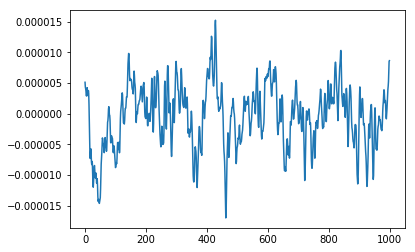

In [21]:
plt.plot(data[0][0])

In [22]:
from pyedflib import EdfReader

In [7]:
reader = EdfReader('/home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012966/s002_2015_09_02/00012966_s002_t005.edf')

NameError: name 'EdfReader' is not defined

In [27]:
util_funcs.get_common_channel_names()[0]

'EEG T5-REF'

In [30]:
reader.getSignalHeaders()[14]

{'label': 'EEG T5-REF',
 'dimension': 'uV',
 'sample_rate': 256,
 'physical_max': 5482.288,
 'physical_min': -5482.28,
 'digital_max': 32767,
 'digital_min': -32767,
 'prefilter': 'HP:0.000 Hz LP:0.0 Hz N:0.0',
 'transducer': 'Unknown'}

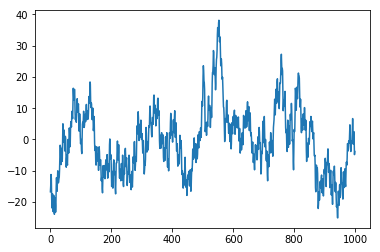

In [32]:
plt.plot(reader.readSignal(14, start=0, n=250*4))

In [3]:
test_filenames=["/n/scratch2/ms994/medium_size/test_1.tfrecords","/n/scratch2/ms994/medium_size/test_2.tfrecords","/n/scratch2/ms994/medium_size/test_3.tfrecords","/n/scratch2/ms994/medium_size/test_0.tfrecords"]
def read_tfrecord(example):
    features = {'original_index': tf.io.FixedLenFeature([1], tf.int64, ),\
               'data':  tf.FixedLenFeature([9*21*1000], tf.float32,),\
               'label':  tf.FixedLenFeature([10], tf.int64, [0 for i in range(10)]),\
               'subtypeLabel':  tf.FixedLenFeature([10], tf.int64, [0 for i in range(10)]),\
               'patient':  tf.FixedLenFeature([1], tf.int64,), \
               'session':  tf.FixedLenFeature([1], tf.int64,),
                       }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
#     return example

    data = tf.reshape(example['data'], [9,21,1000,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)


    return data, tf.one_hot(class_label[:9], 2)
def get_batched_dataset(filenames=test_filenames, batch_size=4, use_fft=False, max_queue_size=40, max_std=100, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=6024, num_parallel_calls=n_process)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    if is_train and max_std != None:
        dataset = dataset.filter(lambda x, y: tf.reduce_all(tf.math.reduce_std(x, axis=0) < max_std))
    if use_fft:
        dataset = dataset.map(lambda x, y: ( \
                                            tf.cast(tf.signal.fft( tf.cast(x, tf.complex64)), tf.float64), \
                                            y), num_parallel_calls=n_process)
#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(128)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(max_queue_size)
    return dataset
train_filenames=["/n/scratch2/ms994/medium_size/train_1.tfrecords","/n/scratch2/ms994/medium_size/train_2.tfrecords","/n/scratch2/ms994/medium_size/train_3.tfrecords","/n/scratch2/ms994/medium_size/train_0.tfrecords"]

def get_test_dataset(test_filenames=test_filenames):
    return get_batched_dataset(test_filenames, is_train=False)
def get_train_dataset(test_filenames=train_filenames):
    return get_batched_dataset(test_filenames, is_train=False)


In [4]:
test = get_test_dataset()
train = get_train_dataset()

In [5]:
import sys, os
sys.path.append(os.path.realpath(".."))
from keras_models.metrics import f1, sensitivity, specificity
model = tf.keras.models.load_model("/n/scratch2/ms994/out/WGBYHTDBVOQAXBVX.h5", custom_objects={"f1":f1,"sensitivity":sensitivity,"specificity":specificity})

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
from importlib import reload
import keras_models.metrics as kmetrics
reload(kmetrics)

<module 'keras_models.metrics' from '/home/ms994/dbmi_eeg_clustering/keras_models/metrics.py'>

In [26]:
model.metrics.append(kmetrics.sensitivity)
model.metrics.append(kmetrics.specificity)

In [32]:
tf.enable_v2_behavior()
tf.__version__

'1.13.1'

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 9, 21, 1000, 1)    0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 9, 21, 1000, 1)    0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 9, 21, 1000, 1)    4         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 19, 998, 4)     40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 19, 499, 4)     0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 9, 19, 499, 4)     16        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 17, 497, 4)     148       
__________

In [ ]:
values = model.predict(train, steps=100)

In [ ]:
# reload(kmetrics)
# model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy", kmetrics.f1, kmetrics.sensitivity])
scores=model.evaluate(test, steps=1)
print(scores)

In [ ]:
test = get_test_dataset()
testIterator = test.take(754).make_one_shot_iterator()
all_ys = []
predicted_ys = []
# model.compile("adam", loss="categorical_crossentropy")
for x, y in testIterator:
#     print(x.shape)
#     pbrint(y.shape)
    all_ys.append(y.numpy())
#     predicted_ys.append(model.predict(x.numpy()))
    
# scores = model.evaluate(test, steps=16000)

In [14]:
def get_test_index():
    return pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb"))
def get_test_labels():
    test_index = get_test_index()
    #made a mistake, it should be the first 9 instead
    return np.array([test_index[key].time_seizure_label[:9] for key in test_index.keys()])

In [64]:
testLabels = get_test_labels()

In [43]:
len(testLabels)/4

6024.25

In [44]:
interleavedTestLabels = []
ind = {0:0,1:0,2:0,3:0}
for i in range(1506):
    for j in range(4):
        interleavedTestLabels.append(testLabels[6024*j + ind[j]*16:(ind[j]+1)*16])
        ind[j]+=1

In [48]:
np.vstack(interleavedTestLabels).shape

(24096, 9)

In [16]:
testLabels[0]

array([False, False, False, False, False, False, False, False, False])

In [66]:
all_ys = np.vstack(all_ys)

In [67]:
(all_ys[:24097].argmax(2) == testLabels).all()

False

In [37]:
(np.vstack([l for l in testLabels]).flatten() == all_ys.argmax(2)[:24097].flatten()).sum() - 25097*9

-49342

In [50]:
(all_ys.argmax(2)[:24096] == np.vstack(interleavedTestLabels)).all()

False

In [51]:

predicted_ys = np.vstack(predicted_ys)

In [62]:
all_ys[0:2].reshape(18,2)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [66]:
from sklearn.metrics import classification_report, roc_auc_score
# all_ys.reshape(-1, 2).shape
print()
print()b


              precision    recall  f1-score   support

           0       0.94      0.47      0.62    194543
           1       0.13      0.72      0.23     22321

    accuracy                           0.49    216864
   macro avg       0.53      0.59      0.42    216864
weighted avg       0.85      0.49      0.58    216864

0.5930394703495446


# Switch single 4 second data to tfrecords too

In [14]:
edss =  er.EdfDatasetSegments(pre_cooldown=0, post_cooldown=0, sample_time=0, num_seconds=2, n_process=8)

Starting 8 processes
retrieving: 0
Starting 8 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [15]:
trainFiles = edss.get_train_split()
validFiles = edss.get_valid_split()
testFiles = edss.get_test_split()

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
starting custom_annotater
Starting 20 processes
retrieving: 0
starting custom_annotater
Starting 20 processes
retrieving: 0


In [17]:
import preprocessingV2.preprocessingV2 as ppv2

In [18]:
ppv2.FileDataReader(split="test", directory="/n/scratch2/ms994/medium_size/test", split="train", filename="/home/ms994/i")

KeyboardInterrupt: 